TEAM A1

Gabriel Anzalone- 80543

Daniel Granados Olvera- 102453

Jules Remlinger- 73178
___

# Moving Averages Strategy
___

In order for the Machine learning part to be run properly, we used Google Colab's cloud computing services. Such large models would be impossible to compute on a 'normal' PC. Therefore the notebook is intended to work on google colab where the data is on Google Drive. Further information is provided in this notebook on how to set up the computation properly.

___
## 1. Importations

Please make sure you have the right dependencies installed.

In [ ]:
# =====================================
# Basic Libraries
# =====================================

import os
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import itertools
from itertools                import combinations
from collections              import Counter, defaultdict
from mpl_toolkits.mplot3d     import Axes3D  # necessary for 3D plotting if needed

# =====================================
# Scikit-Learn
# =====================================

from sklearn.model_selection   import GridSearchCV
from sklearn.ensemble          import RandomForestClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.metrics           import (accuracy_score, precision_score,recall_score, roc_auc_score)

# =====================================
# Data management libraries
# =====================================
import pickle
from google.colab              import drive

# =====================================
# External Libraries
# =====================================
!pip install wrds --quiet
import wrds       # WRDS database connection
!pip install ta --quiet
import ta         # Technical analysis indicators

print('Imports done !')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 158.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 54.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Imports done !


___
## 2. Loading Data

**Function:** `fetch_wrds_data()`

This function queries the WRDS database to extract daily stock-level data for S&P 500 constituents between 2008-01-01 and 2022-01-01. It uses a SQL query to join multiple CRSP and Compustat tables to retrieve a clean, survivorship-bias-free dataset for return and price analysis.

**Requirements:**
- You must have valid WRDS credentials and establish a working database connection (e.g., via `wrds.Connection()`).
- The `db.raw_sql()` function used in this code assumes an active WRDS session and the appropriate permissions to access the `crsp` and `comp` libraries.

**Key Components of the Query:**
- crsp.msp500list (`sp`): Defines the S&P 500 universe and membership periods.
- crsp.dsf (`dsf`): Provides daily stock data:
  - `ret`: daily returns
  - `prc`: daily closing prices (absolute value removes sign)
  - `vol`: trading volume
- crsp.msenames (`names`): Used to match tickers and company names valid for the observation date.
- crsp.ccmxpf_linktable (`link`): Maps CRSP `permno` to Compustat `gvkey` using valid and primary links only (`linktype IN ('LU', 'LC')`, `linkprim IN ('P', 'C')`).
- comp.company (`co`): Confirms that the security is associated with a valid Compustat company.

**Output:**

Returns a pandas DataFrame with the following columns:
- `date`: trading date
- `permno`: CRSP unique security identifier
- `ret`: daily return
- `prc`: closing price (absolute)
- `vol`: volume
- `ticker`: stock ticker
- `comnam`: company name


In [ ]:
# Connect to WRDS

#username : jules_remlinger
#mdp      : tafpax-meJdin-mysbe9
db = wrds.Connection()

Enter your WRDS username [root]:jules_remlinger
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [ ]:
def fetch_wrds_data():
# Select daily returns, fully-adjusted price (splits & dividends), and split-adjusted volume
# for S&P 500 constituents from 2006-01–01 through 2022–01–01

  query = '''
  SELECT
      dsf.date,
      dsf.permno,
      dsf.ret,                             -- CRSP total return (already split & dividend adjusted)
      ABS(dsf.prc)  / dsf.cfacpr   AS prc_adj,   -- price adjusted for all splits AND distributions
      dsf.vol      / dsf.cfacshr   AS vol_adj,   -- volume adjusted for splits only
      names.ticker,
      names.comnam
  FROM crsp.msp500list      AS sp
  JOIN crsp.dsf             AS dsf
    ON dsf.permno = sp.permno
  AND dsf.date  BETWEEN sp.start  AND sp.ending
  JOIN crsp.msenames        AS names
    ON dsf.permno = names.permno
  AND dsf.date  BETWEEN names.namedt
                    AND COALESCE(names.nameendt, '9999-12-31')
  JOIN crsp.ccmxpf_linktable AS link
    ON dsf.permno   = link.lpermno
  AND dsf.date     BETWEEN link.linkdt
                        AND COALESCE(link.linkenddt, '9999-12-31')
  AND link.linktype IN ('LU','LC')
  AND link.linkprim IN ('P','C')
  JOIN comp.company         AS co
    ON co.gvkey = link.gvkey
  WHERE dsf.date BETWEEN '2006-01-01' AND '2022-01-01'
  ORDER BY dsf.permno, dsf.date;
  '''

  return db.raw_sql(query, date_cols=['date'])

# Fetch WRDS returns
wrds_data = fetch_wrds_data()

___
## 3. Inspecting the Data

In [ ]:
wrds_data

date  permno       ret     prc_adj         vol_adj ticker  \
0    2006-01-03   10078  0.031026       17.28     193101036.0   SUNW   
1    2006-01-04   10078  0.020833       17.64     166168016.0   SUNW   
2    2006-01-05   10078  0.063039      18.752     287172064.0   SUNW   
3    2006-01-06   10078  0.004693       18.84     391777348.0   SUNW   
4    2006-01-09   10078 -0.014862       18.56     345710160.0   SUNW   
...         ...     ...       ...         ...             ...    ...   
9795 2021-12-27   93436  0.025248  364.646647  7898416.333333   TSLA   
9796 2021-12-28   93436    -0.005  362.823323  6675175.333333   TSLA   
9797 2021-12-29   93436 -0.002095  362.063313  6233222.333333   TSLA   
9798 2021-12-30   93436 -0.014592   356.77999  5198494.666667   TSLA   
9799 2021-12-31   93436 -0.012669   352.26001  4510024.666667   TSLA   

                    comnam  
0     SUN MICROSYSTEMS INC  
1     SUN MICROSYSTEMS INC  
2     SUN MICROSYSTEMS INC  
3     SUN MICROSYSTEMS INC  
4     SUN MICROSYSTEMS INC  
...                    ...  
9795             TESLA INC  
9796             TESLA INC  
9797             TESLA INC  
9798             TESLA INC  
9799             TESLA INC  

[2009800 rows x 7 columns]

### 3.1 Choice of scope

Our query begins in 2006 because we need prior data in order to calibrate the different features (e.g a moving average on the last X days needs X days of data prior to the start date)

In [ ]:
start_date = '2008-01-01'
end_date   = '2022-01-01'

#list the tickers that have a price in between the start and end date
tickers_list = wrds_data[(wrds_data['date'] >= start_date) & (wrds_data['date'] <= end_date)]['ticker'].unique()

print("Number of tickers:", len(tickers_list))


Number of tickers: 856


### 3.2 Analyzing data

We can take a look at the number of tickers over time to see if we indeed have 500 or close to 500 at all dates:

#### 3.2.1 Number of tickers

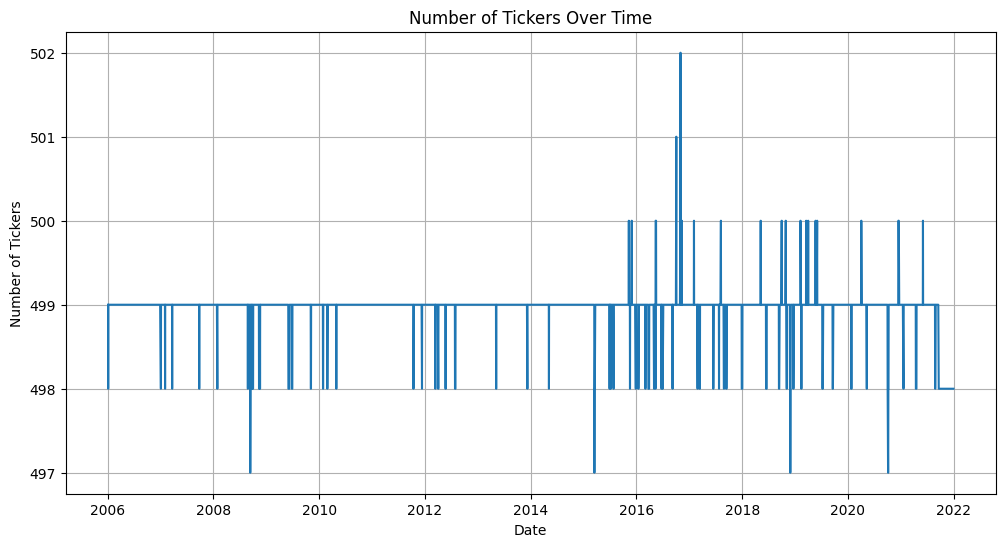

In [ ]:
#Plot the number of tickers for ech date
tickers_over_time = wrds_data.groupby('date')['ticker'].nunique()
plt.figure(figsize=(12, 6))
plt.plot(tickers_over_time.index, tickers_over_time.values, linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Tickers')
plt.title('Number of Tickers Over Time')
plt.grid(True)
plt.show()

We can see that we have 500 or close to 500 stocks for each date. The dates where we don't have 500 stocks might be due to some sudden delistings or to stocks having price not listed on a certain date.

The data is stock split adjusted so we don't need to take that into consideration.

#### 3.2.2 Dealing with NaNs and negative values

First, we check for negative prices :

In [ ]:
#Check if we have negative prices in the data
print('Number of negative prices :',len(wrds_data[wrds_data['prc_adj'] < 0]))

Number of negative prices : 0


Then, we check for NaNs.

There will be some NaNs for the first returns because there was no previous prices so we separate that case from the others.

In [ ]:
#Make a copy and add a flag for when it is the first observation for said permno
wrds_data_copy = wrds_data.copy()
wrds_data_copy['is_first_obs'] = (wrds_data_copy['date'] == wrds_data_copy.groupby('permno')['date'].transform('min'))

#See if we have some NaNs in the data
nan_rows = wrds_data_copy[wrds_data_copy.isna().any(axis=1)]
print('* Number of NaNs :',len(nan_rows))

#Count the NaNs per column
nan_counts = nan_rows.isna().sum()
print('\n* NaN Count per row : \n',nan_counts)

#Isolate the NaNs that happen because it is the first date for said permno (IPOs for example)
nan_on_first = nan_rows[nan_rows['is_first_obs']]
print('\n* Rows on first date with NaNs:', len(nan_on_first))
print('\n* NaNs per column on first date:\n', nan_on_first.isna().sum())

#Remove them from the list and print the remaining NaNs
nan_not_first = nan_rows[~nan_rows['is_first_obs']]
print('\n* remaining NaNs : ', len(nan_not_first))

nan_not_first

* Number of NaNs : 74

* NaN Count per row : 
 date             0
permno           0
ret             70
prc_adj          5
vol_adj          9
ticker           0
comnam           0
is_first_obs     0
dtype: int64

* Rows on first date with NaNs: 65

* NaNs per column on first date:
 date             0
permno           0
ret             65
prc_adj          0
vol_adj          0
ticker           0
comnam           0
is_first_obs     0
dtype: int64

* remaining NaNs :  9


date  permno       ret  prc_adj  vol_adj ticker  \
164117 2009-08-05   70519  0.101538     35.8     <NA>      C   
164211 2009-12-17   70519 -0.072464     32.0     <NA>      C   
164212 2009-12-18   70519    0.0625     34.0     <NA>      C   
164455 2010-12-07   70519  0.038202     46.2     <NA>      C   
279243 2015-06-09   76614      <NA>     <NA>     <NA>   REGN   
296621 2015-05-12   76744      <NA>     <NA>     <NA>   VRTX   
300175 2006-03-07   76841      <NA>     <NA>     <NA>   BIIB   
300176 2006-03-08   76841      <NA>     <NA>     <NA>   BIIB   
303870 2020-11-06   76841      <NA>     <NA>     <NA>   BIIB   

                               comnam  is_first_obs  
164117                  CITIGROUP INC         False  
164211                  CITIGROUP INC         False  
164212                  CITIGROUP INC         False  
164455                  CITIGROUP INC         False  
279243  REGENERON PHARMACEUTICALS INC         False  
296621     VERTEX PHARMACEUTICALS INC         False  
300175                BIOGEN IDEC INC         False  
300176                BIOGEN IDEC INC         False  
303870                     BIOGEN INC         False

We can analyze all the remaining NaNs:

* **For the Citigroup missing values** : CRSP DSF volume is sometimes suppressed on days with corporate-action adjustments (ex-dividend, splits) or trading halts. Price and return exist, so we choose to forward-fill volume here.

  - 2009-08-05: is likely a ex-dividend/special session day.
  - 2009-12-17: is likely a ex-dividend/special session day.
  - 2009-12-18: A low-liquidity or holiday-adjacent session where CRSP did not report consolidated volume.
  - 2010-12-07: Another corporate-action or data-vendor gap day; price and return are valid.

For the remaining NaNs we go line by line:

- **2015-06-09 (permno 76614, REGN – Regeneron Pharmaceuticals Inc)** : New permno issued on spin-off or corporate event; placeholder row before first actual trade under REGN.

- **2015-05-12 (permno 76744, VRTX – Vertex Pharmaceuticals Inc)** : Initial permno assignment on IPO/spin-off day, with no trading until the next session.

- **2006-03-07 (permno 76841, BIIB – Biogen Idec Inc)** : Placeholder for the new BIIB Idec permno before it began trading.

- **2006-03-08 (permno 76841, BIIB – Biogen Idec Inc)** :  Still pre-trading placeholder; first actual trade comes after this.

- **2020-11-06 (permno 76841, BIIB – Biogen Inc)** : Corporate action/name change (Biogen Idec → Biogen Inc); this row marks the permno transition with no trade data.

We will forward fill the Citigroup volumes and remove all the remaining NaNs

In [ ]:
# Forward fill the volumes for Citigroup
wrds_data = wrds_data.sort_values(['permno', 'date'])
mask_c = wrds_data['permno'] == 70519
wrds_data.loc[mask_c, 'vol_adj'] = wrds_data.loc[mask_c, 'vol_adj'].ffill()
print("Remaining Citigroup vol NaNs:", wrds_data.loc[mask_c, 'vol_adj'].isna().sum())

wrds_data = wrds_data.dropna()
print("Remaining NaNs:", wrds_data.isna().sum().sum())

Remaining Citigroup vol NaNs: 0
Remaining NaNs: 0


___
## 4. Moving Average And Momentum Strategies

The concept of this strategy is to try and use Moving Averages and momentum indicators (like RSI) in order to try and get positive returns.

Let us first define the terms that we will use:

**Moving Average**

In finance, a moving average (MA) is a stock indicator commonly used in technical analysis. The reason for calculating the moving average of a stock is to help smooth out the price data by creating a constantly updated average price.

- **Simple Moving Average (SMA)**:  
  The SMA is the unweighted mean of the previous $ n $ prices. Mathematically, for a time series $ P_t $, the SMA over a window of size $ n $ is defined as:  
  $$
  \text{SMA}_t = \frac{1}{n} \sum_{i=0}^{n-1} P_{t-i}
  $$  
  It reacts slowly to price changes, making it useful for identifying longer-term trends.

- **Exponential Moving Average (EMA)**:  
  The EMA gives more weight to recent prices, making it more responsive to new information. It is defined recursively as:  
  $$
  \text{EMA}_t = \alpha \cdot P_t + (1 - \alpha) \cdot \text{EMA}_{t-1}
  $$  
  where $ \alpha = \frac{2}{n+1} $ is the smoothing factor and $ n $ is the chosen period. EMA is widely used in crossover strategies for its responsiveness.

**Relative Strength Index (RSI)**

The RSI is a momentum oscillator that measures the speed and change of price movements on a scale of 0 to 100. It is used to identify overbought or oversold conditions in a market. The RSI is calculated as:  
$$
\text{RSI} = 100 - \frac{100}{1 + RS}
\quad \text{where} \quad RS = \frac{\text{Average Gain over } n \text{ periods}}{\text{Average Loss over } n \text{ periods}}
$$  
Typically, an RSI above 70 indicates an overbought condition, while below 30 suggests oversold.

___

We will focus on the Exponential moving average rather than the simple one since it has been relatively documented in financial litterature that if one indicator has predictive power, it would be EMA.

There are 2 types of strategies that we will delve into:

1) The naïve strategies, Where one tries to get return based on simple rules (e.g. BUY if MA(n=10) > MA(n=50) or BUY if RSI < 30)

2) The Machine Learning Classification strategies. Where we use those metrics as features in a classification.


### 4.1 Features discussion

In order to get features that make sense across stocks, we modify a little bit the features. Given a set of windows, we compute

- the EMA ratios (EMA/price). Dividing by the price makes more sense because we have effectively standardized the feature relatively to the price of the stock.

- The EMA stratardized differences (EMA(a) - EMA(b))/ EMA(a). The rationale for those features is that the algorithms will have a sense of what is the momentum profile of the stock. It is also divided by one of the EMAs in order to be standardized.

- RSI, as defined earlier.

### 4.2 Naïve strategies

#### 4.2.1 Feature Creation

We first define a range of windows and then we compute the EMAs via dict - comprehension on the range of windows. We repeat the same operation on the RSI and then compute the crossovers.

We also remove the warm-up period for the EMAs/RSIs, meaning that we remove the first days of the EMA computation up to the largest window so that there aren't any issues with EMAs crossing at the beginning of the computation.

Once everything is computed, we then filter the dataframe to our start_date and end_date.

In [ ]:
# Define Windows
windows       = [1, 5, 20, 35, 50, 70, 100, 130]   # 1 is just the price series
window_pairs  = [(l, s) for l, s in itertools.product(windows, windows) if l > s]
max_window    = max(windows)

# Sort & copy
wrds_data_EMA = wrds_data.sort_values(['permno','date']).copy()

# Compute EMAs on adjusted price
for w in windows:
    wrds_data_EMA[f'ema_{w}'] = (
        wrds_data_EMA
          .groupby('permno')['prc_adj']
          .transform(lambda x: x.ewm(span=w, adjust=False).mean())
    )

# Compute gains/losses from the adjusted price
wrds_data_EMA['delta'] = wrds_data_EMA.groupby('permno')['prc_adj'].diff()
wrds_data_EMA['gain']  = wrds_data_EMA['delta'].clip(lower=0)
wrds_data_EMA['loss']  = (-wrds_data_EMA['delta']).clip(lower=0)

# Compute RSI for each window via dict‐comprehension
rsi_signals = {
    f'rsi_{w}': 100 - (
        100 / (
            1 + (
                # avg gain over w periods (Wilder’s smoothing via EMA with alpha=1/w)
                wrds_data_EMA
                  .groupby('permno')['gain']
                  .transform(lambda x: x.ewm(alpha=1/w, adjust=False).mean())
              /
                wrds_data_EMA
                  .groupby('permno')['loss']
                  .transform(lambda x: x.ewm(alpha=1/w, adjust=False).mean())
            )
        )
    )
    for w in windows
}
wrds_data_EMA = wrds_data_EMA.assign(**rsi_signals)

# 4) warm‐up drop
wrds_data_EMA['idx'] = wrds_data_EMA.groupby('permno').cumcount()
wrds_data_EMA_filtered = (
    wrds_data_EMA
      .loc[wrds_data_EMA['idx'] >= max_window]
      .drop(columns='idx')
)

# Computing crossover signals
crossover_signals = {
    f'ema_{l}_over_{s}': (
        wrds_data_EMA_filtered[f'ema_{l}']
        < wrds_data_EMA_filtered[f'ema_{s}']
    ).astype(int)
    for l, s in window_pairs
}
wrds_data_EMA_final = wrds_data_EMA_filtered.assign(**crossover_signals)

# Filter to the date range
wrds_data_EMA_final = wrds_data_EMA_final[
    (wrds_data_EMA_final['date'] >= start_date) &
    (wrds_data_EMA_final['date'] <= end_date)
]

Here is an example of what the EMAs look like for a random ticker:

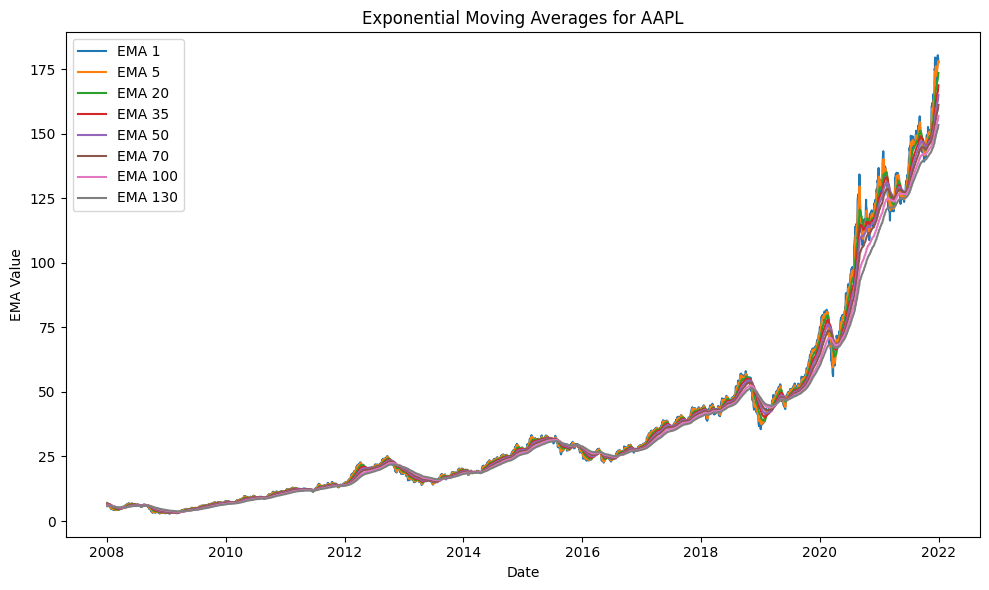

In [ ]:
ticker = 'AAPL'  # change this to any ticker you want to plot

# Filter for chosen ticker
example_df = wrds_data_EMA_final.loc[wrds_data_EMA_final['ticker'] == ticker]

# Plot each EMA (EMA 1 will match the price series)
plt.figure(figsize=(10, 6))
for w in windows:
    plt.plot(example_df['date'], example_df[f'ema_{w}'], label=f'EMA {w}')

plt.legend()
plt.title(f'Exponential Moving Averages for {ticker}')
plt.xlabel('Date')
plt.ylabel('EMA Value')
plt.tight_layout()
plt.show()

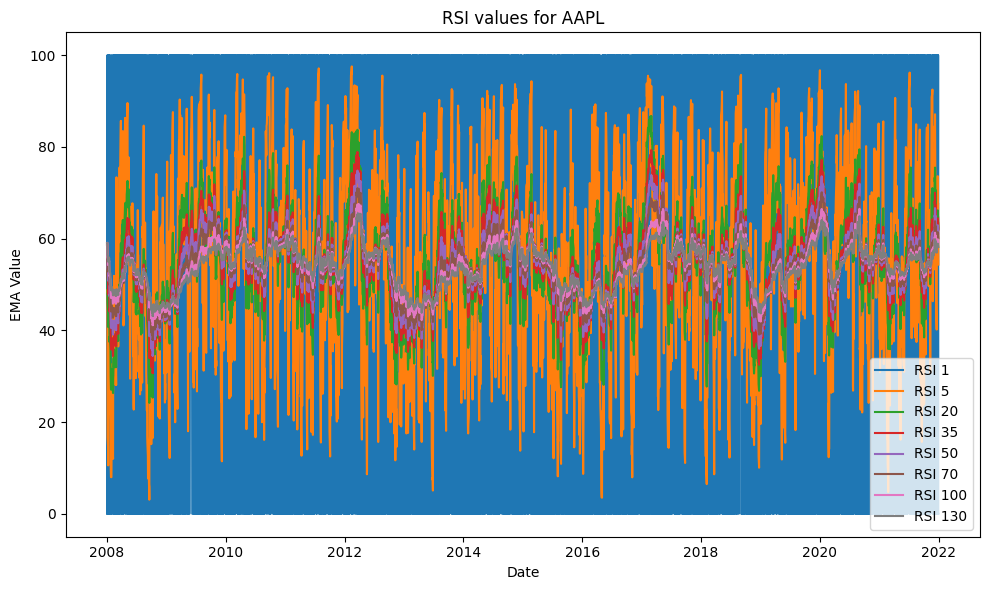

In [ ]:
ticker = 'AAPL'  # change this to any ticker you want to plot

# Filter for chosen ticker
example_df = wrds_data_EMA_final.loc[wrds_data_EMA_final['ticker'] == ticker]

# Plot each EMA (EMA 1 will match the price series)
plt.figure(figsize=(10, 6))
for w in windows:
    plt.plot(example_df['date'], example_df[f'rsi_{w}'], label=f'RSI {w}')

plt.legend()
plt.title(f'RSI values for {ticker}')
plt.xlabel('Date')
plt.ylabel('EMA Value')
plt.tight_layout()
plt.show()

#### 4.2.2 Strategy comparison

In [ ]:
for l, s in window_pairs:
    sig_col = f'ema_{l}_over_{s}'
    pos_col = f'pos_{l}_{s}'
    ret_col = f'strat_ret_{l}_{s}'
    eqt_col = f'cumstrat_{l}_{s}'

    #Shift signal by one trading day
    wrds_data_EMA_final[pos_col] = (
        wrds_data_EMA_final
          .groupby('permno')[sig_col]
          .shift(1)
          .fillna(0)
    )

    # Daily strategy return = position × actual return
    wrds_data_EMA_final[ret_col] = (
        wrds_data_EMA_final[pos_col]
        * wrds_data_EMA_final['ret']
    )

    # Cumulative strategy return
    wrds_data_EMA_final[eqt_col] = (
        wrds_data_EMA_final
          .groupby('permno')[ret_col]
          .transform(lambda x: (1 + x).cumprod())
    )


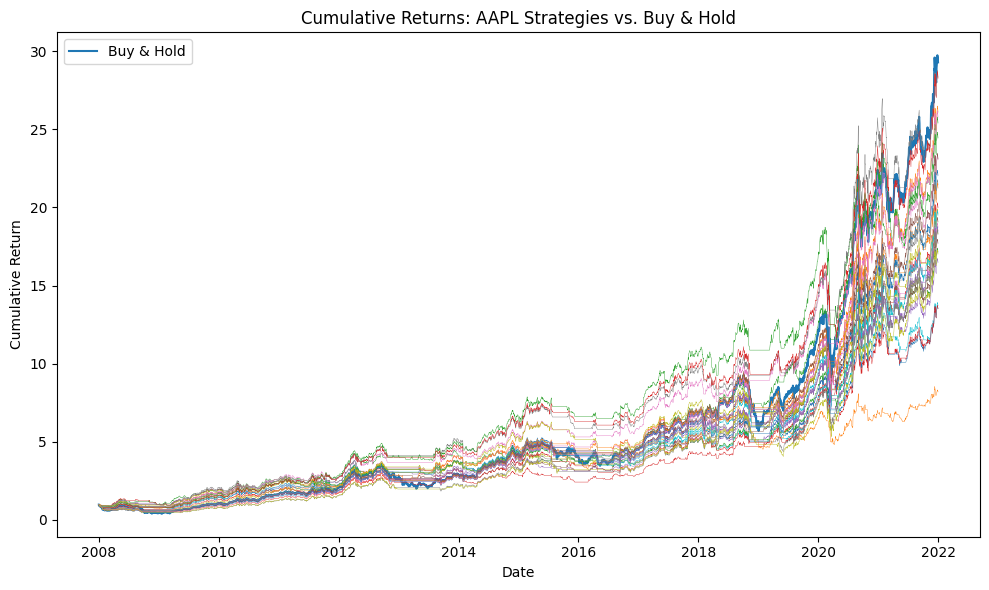

In [ ]:
# Choose the ticker you want to plot
ticker = 'AAPL'  # replace with your desired ticker

# Filter the final EMA DataFrame for the chosen ticker
df = wrds_data_EMA_final[wrds_data_EMA_final['ticker'] == ticker].sort_values('date').copy()

# Compute buy & hold cumulative returns
df['cum_buy_hold'] = (1 + df['ret']).cumprod()

# Plot buy & hold
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['cum_buy_hold'], label='Buy & Hold')

# Plot each strategy's cumulative returns
for col in df.columns:
    if col.startswith('cumstrat_'):
        plt.plot(df['date'], df[col],
                 #label=col,
                 linewidth = 0.3)

plt.legend()
plt.title(f'Cumulative Returns: {ticker} Strategies vs. Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.tight_layout()
plt.show()


In [ ]:
# Identify strategy return columns
strat_ret_cols = [col for col in wrds_data_EMA_final.columns if col.startswith('strat_ret_')]

# Compute buy & hold portfolio returns (equal weight across stocks each day)
bh_portfolio = wrds_data_EMA_final.groupby('date')['ret'].mean()

# Compute each crossover portfolio return (1/N across stocks)
strategy_returns = {'Buy & Hold': bh_portfolio}
for col in strat_ret_cols:
    strategy_name = col.replace('strat_ret_', 'EMA ')
    strategy_returns[strategy_name] = wrds_data_EMA_final.groupby('date')[col].mean()

# Build a DataFrame of daily portfolio returns
portf_ret = pd.DataFrame(strategy_returns).dropna()

# Compute performance metrics
metrics = []
trading_days = 252
for strat in portf_ret.columns:
    daily_returns = portf_ret[strat]
    # Annualized return (geometric)
    ann_return = (daily_returns + 1).prod()**(trading_days / len(daily_returns)) - 1
    # Annualized volatility
    ann_vol = daily_returns.std() * np.sqrt(trading_days)
    # Annualized Sharpe ratio (assuming zero risk-free rate)
    sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(trading_days)
    metrics.append({
        'Strategy': strat,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Annualized Sharpe': sharpe
    })

metrics_df = pd.DataFrame(metrics).sort_values('Annualized Sharpe', ascending=False).reset_index(drop=True)
metrics_df


Strategy  Annualized Return  Annualized Volatility  Annualized Sharpe
0     EMA 70_50           0.076377               0.100929           0.779887
1    EMA 130_20           0.073959               0.098489           0.773896
2    EMA 100_35           0.075267               0.100485           0.772621
3    EMA 100_20           0.073879               0.098585           0.772480
4     EMA 70_35           0.074754               0.099995           0.771133
5    EMA 130_35           0.074719               0.100945           0.764521
6    EMA 100_50           0.074430               0.101833           0.756111
7    EMA 100_70           0.075217               0.103444           0.753039
8    EMA 130_50           0.074626               0.102854           0.751414
9     EMA 130_5           0.068466               0.094941           0.745189
10    EMA 50_35           0.071625               0.100413           0.739308
11   EMA 130_70           0.074636               0.105142           0.737454
12    EMA 70_20           0.070639               0.099340           0.736943
13  EMA 130_100           0.075401               0.107905           0.727922
14    EMA 100_5           0.066378               0.095601           0.720255
15    EMA 50_20           0.067418               0.100769           0.698027
16    EMA 130_1           0.060627               0.093060           0.679203
17    EMA 35_20           0.064614               0.101762           0.666368
18     EMA 70_5           0.061067               0.097458           0.657145
19    EMA 100_1           0.056679               0.093958           0.633921
20     EMA 50_5           0.059249               0.099073           0.630719
21   Buy & Hold           0.123488               0.232102           0.618194
22     EMA 35_5           0.057412               0.100895           0.603918
23     EMA 70_1           0.052337               0.095761           0.580786
24     EMA 20_5           0.053163               0.104163           0.549469
25     EMA 50_1           0.048672               0.097737           0.535306
26     EMA 35_1           0.045679               0.100146           0.496259
27     EMA 20_1           0.037707               0.104823           0.405698
28      EMA 5_1           0.024560               0.114038           0.270107

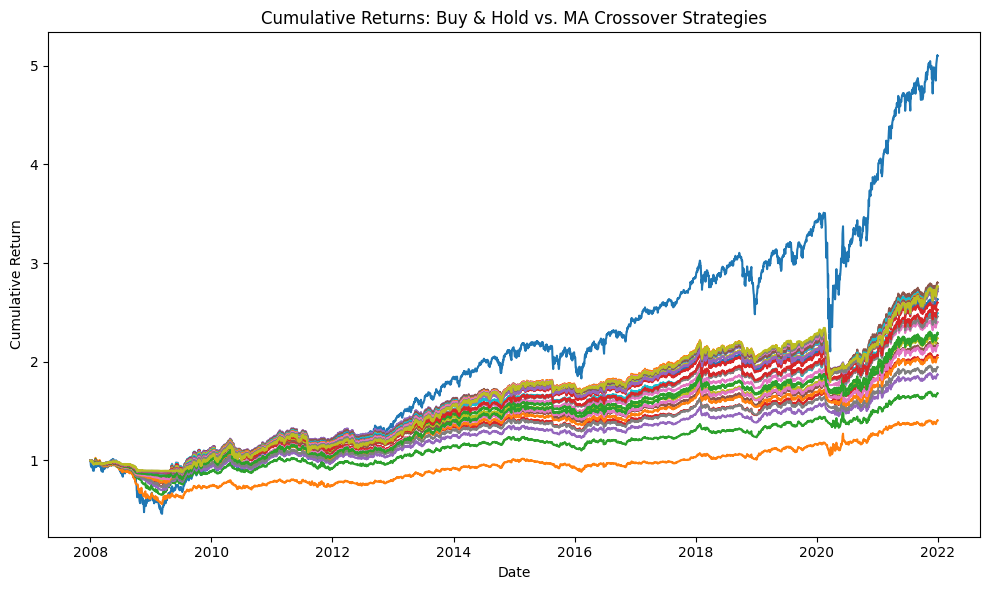

In [ ]:
# Rebuild the daily portfolio returns (1/N across stocks)
strat_ret_cols = [col for col in wrds_data_EMA_final.columns if col.startswith('strat_ret_')]

# Buy & hold portfolio: equal-weight average of ret
bh_portfolio = wrds_data_EMA_final.groupby('date')['ret'].mean()

# Build each crossover portfolio return (1/N across stocks)
strategy_returns = {'Buy & Hold': bh_portfolio}
for col in strat_ret_cols:
    name = col.replace('strat_ret_', 'EMA ')
    strategy_returns[name] = wrds_data_EMA_final.groupby('date')[col].mean()

# DataFrame of daily portfolio returns
portf_ret = pd.DataFrame(strategy_returns).dropna()

# Compute cumulative returns for each strategy
cum_returns = (1 + portf_ret).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
for strat in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[strat],
             #label=strat
             )

#plt.legend()
plt.title('Cumulative Returns: Buy & Hold vs. MA Crossover Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.tight_layout()
plt.show()


### 4.3 ML Classification

#### 4.3.1 Feature Creation

In [ ]:
# assume wrds_data has columns ['permno','date','prc_adj']
df = wrds_data.copy()

# ensure datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['permno','date'])

# windows and window‐pairs
windows = [1, 5, 20, 50, 100]
window_pairs = [(l, s) for l, s in itertools.product(windows, windows) if l > s]
max_window = max(windows)

# RETURNS
df['current_return'] = df.groupby('permno')['prc_adj'].pct_change()
df['next_day_return']  = df.groupby('permno')['prc_adj'].pct_change().shift(-1)

# EMA RATIOS
for w in windows:
    df[f'ema_ratio_{w}'] = (
        df
        .groupby('permno')['prc_adj']
        .apply(lambda x: x.ewm(span=w, adjust=False).mean().div(x))
        .reset_index(level=0, drop=True)
    )

# DIFF FEATURES: (EMA_l – EMA_s) / EMA_s
for l, s in window_pairs:
    df[f'diff_{l}_{s}'] = (
        (df[f'ema_ratio_{l}'] - df[f'ema_ratio_{s}'])
        .div(df[f'ema_ratio_{s}'])
    )

# RSI FEATURES
df['delta'] = df.groupby('permno')['prc_adj'].diff()
df['gain']  = df['delta'].clip(lower=0)
df['loss']  = -df['delta'].clip(upper=0)

for w in windows:
    avg_gain = df.groupby('permno')['gain'].transform(lambda x: x.rolling(window=w).mean())
    avg_loss = df.groupby('permno')['loss'].transform(lambda x: x.rolling(window=w).mean())
    rs       = avg_gain.div(avg_loss)
    df[f'rsi_{w}'] = 100 - (100 / (1 + rs))

# drop intermediates
df = df.drop(columns=['delta','gain','loss'])

# 5) WARM‐UP DROP
#    remove the first max_window rows per permno so all EMAs/RSIs are fully "warmed up"
df['idx'] = df.groupby('permno').cumcount()
df = df.loc[df['idx'] >= max_window].drop(columns='idx')

#Drop ema_ratio_1 as it is always 1
df = df.drop(columns=['ema_ratio_1'])

# 6) FILTER BY DATE RANGE
start_date = pd.to_datetime(start_date)
end_date   = pd.to_datetime(end_date)

mask = (df['date'] >= start_date) & (df['date'] <= end_date)
X_df = df.loc[mask].reset_index(drop=True)

#Show what it looks like
X_df.head()

date  permno       ret  prc_adj     vol_adj ticker  \
0 2008-01-02   10078 -0.039162    17.42  11338448.0   JAVA   
1 2008-01-03   10078   -0.0155    17.15   9660955.0   JAVA   
2 2008-01-04   10078  -0.04898    16.31  13884504.0   JAVA   
3 2008-01-07   10078 -0.012262    16.11  15257281.0   JAVA   
4 2008-01-08   10078 -0.015518    15.86  12592171.0   JAVA   

                 comnam  current_return  next_day_return  ema_ratio_5  ...  \
0  SUN MICROSYSTEMS INC       -0.039162        -0.015499     1.034651  ...   
1  SUN MICROSYSTEMS INC       -0.015499         -0.04898      1.03396  ...   
2  SUN MICROSYSTEMS INC        -0.04898        -0.012262     1.058141  ...   
3  SUN MICROSYSTEMS INC       -0.012262        -0.015518     1.047518  ...   
4  SUN MICROSYSTEMS INC       -0.015518         -0.01261     1.042687  ...   

   diff_50_20  diff_100_1  diff_100_5  diff_100_20  diff_100_50  rsi_1  \
0    0.057371    0.192435      0.1525      0.09358     0.034245    0.0   
1    0.061127    0.207026    0.167382     0.099978     0.036613    0.0   
2     0.06705     0.26386    0.194415     0.109445     0.039731    0.0   
3     0.07279    0.274014    0.216222     0.118811     0.042898    0.0   
4    0.078537    0.288273    0.235532     0.128331     0.046169    0.0   

      rsi_5     rsi_20     rsi_50    rsi_100  
0  1.052632  13.502935  34.190782  47.801256  
1  0.847458  13.582677  33.137986  47.760342  
2  0.000000  12.277580  30.585796  46.343514  
3  0.000000  12.000000  31.101740  46.239866  
4  0.000000  11.694915  31.151003  46.175321  

[5 rows x 28 columns]

#### 4.3.2 Training and Prediction on a rolling window

In order to assess effectiveness accross periods, and also to have a standardized test for further parts of the project, we use a rolling window analysis.

Every model will be trained on the past 750 days of data, then tested on the next 250.

___

The next cell should be ran carefully as it requires a lot of computing power. We recommend using google cloud computing services (notably a TPU works great here). Else, one can always load the results from memory in the next section.

In [ ]:
#Scikit-Learn Importations
from sklearn.model_selection   import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble          import RandomForestClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.metrics           import (accuracy_score, precision_score,recall_score, roc_auc_score)
from sklearn.decomposition     import PCA
from sklearn.preprocessing     import StandardScaler
from sklearn.metrics           import confusion_matrix, ConfusionMatrixDisplay

#Importations to save data for future analysis :
import pickle
from google.colab import drive

# Rolling Window parameters
training_window = 750
test_window     = 250

# Pivot just to get an ordered list of dates
returns_df = X_df.pivot(index='date',columns='permno',values='current_return')
dates   = returns_df.index
n_periods = (len(dates) - training_window - test_window) // test_window + 1

# MODELS & GRIDS
models = {
    "rf":  RandomForestClassifier(random_state=0, n_jobs=-1),
    "ann": MLPClassifier(
                random_state=0,
                max_iter=300,
                early_stopping=True
            )
}

param_grids = {
    "rf": {
        "n_estimators": [50, 100],
        "max_depth":    [None, 3, 5]
    },
    "ann": {
        "hidden_layer_sizes": [(50, 30, 10), (100, 50, 25)],
        "alpha":              [1e-3, 1e-2],        # L2
        "learning_rate_init": [1e-3, 1e-4]
    }
}

results = []

# ROLLING BACKTEST :
for i in range(n_periods):
    # compute our train & test date ranges
    start_idx   = i * test_window
    train_dates = dates[start_idx : start_idx + training_window]
    test_dates  = dates[
        start_idx + training_window :
        start_idx + training_window + test_window
    ]

    print(f"\nPeriod {i+1}/{n_periods}")
    print(f" Train: {train_dates[0]} → {train_dates[-1]}")
    print(f" Test : {test_dates[0]} → {test_dates[-1]}")


    # Build train set
    mask_tr   = X_df['date'].between(train_dates[0], train_dates[-1])
    train_data = X_df.loc[mask_tr].dropna().copy()

    # Record which permnos we trained on
    train_permnos = train_data['permno'].unique()

    # Build test set but only keep those permnos
    mask_te   = X_df['date'].between(test_dates[0], test_dates[-1])
    test_data = (
        X_df
          .loc[mask_te & X_df['permno'].isin(train_permnos)]
          .dropna()
          .copy()
    )

    #Print number of tickers
    print(f"  Train/test on {len(train_data['ticker'].unique())} tickers")

    # Labels
    tr_med = train_data.groupby('date')['next_day_return'].transform('median')
    te_med = test_data.groupby('date')['next_day_return'].transform('median')

    train_data['label'] = (train_data['next_day_return'] > tr_med).astype(int)
    test_data['label']  = (test_data['next_day_return']  > te_med).astype(int)

    # Print train class balance
    train_counts = train_data['label'].value_counts().sort_index()
    train_pct    = train_data['label'].value_counts(normalize=True).sort_index() * 100
    print("Train class distribution:")
    for lbl in train_counts.index:
        print(f"  Label {lbl}: {train_counts[lbl]} samples ({train_pct[lbl]:.1f}%)")

    # Print test class balance
    test_counts = test_data['label'].value_counts().sort_index()
    test_pct    = test_data['label'].value_counts(normalize=True).sort_index() * 100
    print("Test class distribution:")
    for lbl in test_counts.index:
        print(f"  Label {lbl}: {test_counts[lbl]} samples ({test_pct[lbl]:.1f}%)")

    # Split X / y
    feature_cols = [c for c in train_data.columns if c not in ('date', 'permno', 'label', 'ticker', 'comnam', 'vol_adj', 'next_day_return')]
    X_tr, y_tr = train_data[feature_cols], train_data['label']
    X_te, y_te = test_data[feature_cols],  test_data['label']

    #Add scaling :
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)

    # PCA dimensionality reduction on training data, then apply to test data
    pca = PCA(n_components=10)               # reduce to top principal components
    X_tr = pca.fit_transform(X_tr)           # fit PCA only on train
    X_te = pca.transform(X_te)               # transform test with same PCA

    # Grid‐search on TRAINING SET
    best_models = {}
    train_scores = {}

    tscv = TimeSeriesSplit(n_splits=5)

    for name, clf in models.items():
        gs = GridSearchCV(
            estimator=clf,
            param_grid=param_grids[name],
            scoring='roc_auc',
            cv=tscv,
            n_jobs=-1,
            refit=True,
            verbose=1
        )
        gs.fit(X_tr, y_tr)

        best_models[name]  = gs.best_estimator_
        train_scores[name] = gs.best_score_   # that's mean CV ROC‐AUC

    # Pick winner by TRAINING‐ROC‐AUC
    winner = max(train_scores, key=train_scores.get)
    winner_model = best_models[winner]

    # Evaluate that winner on the TEST SET
    y_prob = winner_model.predict_proba(X_te)[:, 1]
    y_pred = winner_model.predict(X_te)

    # Print test set prediction balance
    n_test_ones = (y_pred == 1).sum()
    print(f"Number of predicted 1’s in test set: {n_test_ones} "
          f"out of {len(y_pred)} ({n_test_ones/len(y_pred)*100:.1f}%)")

    # Bind the proba back onto the test_data rows ──
    test_data = test_data.copy()                    # avoid SettingWithCopyWarning
    test_data['prediction_proba'] = y_prob           # probability of class 1
    test_data['predicted_label']   = y_pred           # optional, but useful

    # Create test predictions :
    trade_predictions_df = test_data

    #Get train metrics :
    train_acc  = accuracy_score(y_tr, winner_model.predict(X_tr))
    train_prec = precision_score(y_tr, winner_model.predict(X_tr))
    train_rec  = recall_score(y_tr, winner_model.predict(X_tr))
    train_roc  = roc_auc_score(y_tr, winner_model.predict_proba(X_tr)[:, 1])

    #Get test metrics :
    test_acc  = accuracy_score(y_te, y_pred)
    test_prec = precision_score(y_te, y_pred)
    test_rec  = recall_score(y_te, y_pred)
    test_roc  = roc_auc_score(y_te, y_prob)

    #Printing metrics table :
    print(f"\n→ Winner (by train ROC‐AUC): {winner}\n")
    print(f"{'':4} {'Set':<8} {'Accuracy':>8} {'Recall':>8} {'Precision':>10} {'ROC-AUC':>8}")
    print("-" * 54)
    print(f"{'':4} {'Train':<8} "
          f"{train_acc:8.3f} {train_rec:8.3f} "
          f"{train_prec:10.3f} {train_roc:8.3f}")
    print(f"{'':4} {'Test':<8}  "
          f"{test_acc:8.3f} {test_rec:8.3f} "
          f"{test_prec:10.3f} {test_roc:8.3f}")

    results.append({
        "period": i,
        "train_range": (train_dates[0], train_dates[-1]),
        "test_range": (test_dates[0],  test_dates[-1]),
        "best_model": winner,
        "best_params": winner_model.get_params(),
        "train_accuracy": train_acc,
        "train_recall": train_rec,
        "train_precision": train_prec,
        "train_roc_auc": train_roc,
        "val_accuracy": test_acc,
        "val_recall": test_rec,
        "val_precision": test_prec,
        "val_roc_auc": test_roc,
        "trade_predictions": trade_predictions_df
    })

# ----- Save results --------

# Mount Google Drive
drive.mount('/content/drive')

# Create a save folder
save_dir = "/content/drive/MyDrive/MASTER_PROJECT/MA_backup/"
os.makedirs(save_dir, exist_ok=True)

# Save results in that file.
with open(os.path.join(save_dir, "results.pkl"), "wb") as f:
    pickle.dump(results, f)

print("✅ All key variables saved to:", save_dir)



Period 1/11
 Train: 2008-01-02 00:00:00 → 2010-12-21 00:00:00
 Test : 2010-12-22 00:00:00 → 2011-12-16 00:00:00
  Train/test on 577 tickers
Train class distribution:
  Label 0: 181580 samples (50.1%)
  Label 1: 181152 samples (49.9%)
Test class distribution:
  Label 0: 60618 samples (50.1%)
  Label 1: 60479 samples (49.9%)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Number of predicted 1’s in test set: 63658 out of 121097 (52.6%)

→ Winner (by train ROC‐AUC): ann

     Set      Accuracy   Recall  Precision  ROC-AUC
------------------------------------------------------
     Train       0.525    0.557      0.523    0.537
     Test         0.504    0.530      0.503    0.508

Period 2/11
 Train: 2008-12-29 00:00:00 → 2011-12-16 00:00:00
 Test : 2011-12-19 00:00:00 → 2012-12-17 00:00:00
  Train/test on 558 tickers
Train class distribution:
  Label 0: 182332 samples (50.1%)
  Label 1: 181928 samples (49.9%)
Test cl

#### 4.3.3 Loading results

Here is the cell in order to load results from memory if one doesn't want to run the whole simulation again   

In [ ]:
#Imports if not done earlier.
import os
import pickle
from google.colab import drive

# Force remount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define your save directory and file path
save_dir = "/content/drive/MyDrive/MASTER_PROJECT/MA_backup/"
file_path = os.path.join(save_dir, "results.pkl")

# Load the pickle file
with open(file_path, "rb") as f:
    results = pickle.load(f)

print("✅ Results loaded")


Mounted at /content/drive
✅ Results loaded


#### 4.3.4 Results analysis

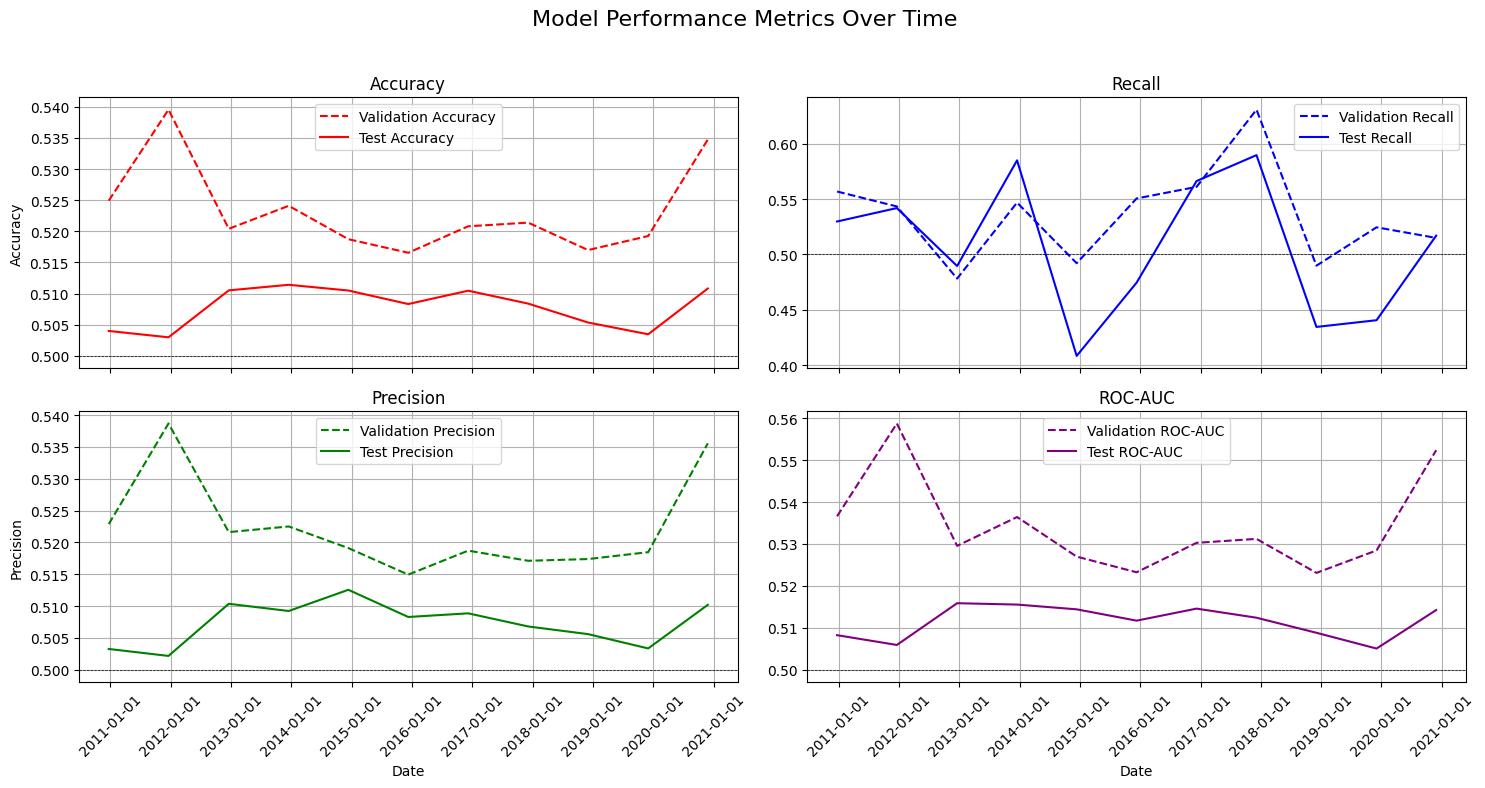

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

val_acc = []
val_rec = []
val_prec = []
val_roc_auc = []

test_acc = []
test_rec = []
test_prec = []
test_roc_auc = []

dates = []

for period in results:
    val_acc.append(period['train_accuracy'])
    val_rec.append(period['train_recall'])
    val_prec.append(period['train_precision'])
    val_roc_auc.append(period['train_roc_auc'])

    test_acc.append(period['val_accuracy'])
    test_rec.append(period['val_recall'])
    test_prec.append(period['val_precision'])
    test_roc_auc.append(period['val_roc_auc'])

    dates.append(period['test_range'][0])

fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=True)
fig.suptitle('Model Performance Metrics Over Time', fontsize=16)

# Create a date formatter
date_fmt = mdates.DateFormatter('%Y-%m-%d')

# Accuracy
axs[0, 0].plot(dates, val_acc, label='Validation Accuracy', color='red', linestyle='--')
axs[0, 0].plot(dates, test_acc, label='Test Accuracy', color='red')
axs[0, 0].axhline(y=0.5, color='k', linestyle='--', linewidth=0.5)
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Recall
axs[0, 1].plot(dates, val_rec, label='Validation Recall', color='blue', linestyle='--')
axs[0, 1].plot(dates, test_rec, label='Test Recall', color='blue')
axs[0, 1].axhline(y=0.5, color='k', linestyle='--', linewidth=0.5)
axs[0, 1].set_title('Recall')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(dates, val_prec, label='Validation Precision', color='green', linestyle='--')
axs[1, 0].plot(dates, test_prec, label='Test Precision', color='green')
axs[1, 0].axhline(y=0.5, color='k', linestyle='--', linewidth=0.5)
axs[1, 0].set_ylabel('Precision')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_title('Precision')
axs[1, 0].legend()
axs[1, 0].grid(True)

# ROC-AUC
axs[1, 1].plot(dates, val_roc_auc, label='Validation ROC-AUC', color='purple', linestyle='--')
axs[1, 1].plot(dates, test_roc_auc, label='Test ROC-AUC', color='purple')
axs[1, 1].axhline(y=0.5, color='k', linestyle='--', linewidth=0.5)
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_title('ROC-AUC')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Apply date formatting to x-axis on the bottom row
for ax in axs[1, :]:
    ax.xaxis.set_major_formatter(date_fmt)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, t

# Metrics to analyze
metric_dict = {
    'Accuracy':    test_acc,
    'Recall':      test_rec,
    'Precision':   test_prec,
    'ROC-AUC':     test_roc_auc
}

summary_data = []

for name, values in metric_dict.items():
    values_array = np.array(values)
    mean = np.mean(values_array)
    std = np.std(values_array, ddof=1)

    # One-sample t-test vs. 0.5
    t_stat, p_value = ttest_1samp(values_array, 0.5)

    # 95% confidence interval
    n = len(values_array)
    conf_int = t.interval(0.95, df=n-1, loc=mean, scale=std/np.sqrt(n))

    summary_data.append({
        'Metric': name,
        'Mean': round(mean, 4),
        'Std Dev': round(std, 4),
        'p-value vs 0.5': round(p_value, 4),
        '95% CI Lower': round(conf_int[0], 4),
        '95% CI Upper': round(conf_int[1], 4)
    })

# Convert to DataFrame and display
summary_df = pd.DataFrame(summary_data)

summary_df

Metric    Mean  Std Dev  p-value vs 0.5  95% CI Lower  95% CI Upper
0   Accuracy  0.5078   0.0033          0.0000        0.5056        0.5100
1     Recall  0.5070   0.0623          0.7163        0.4651        0.5489
2  Precision  0.5073   0.0034          0.0000        0.5051        0.5096
3    ROC-AUC  0.5115   0.0039          0.0000        0.5089        0.5141

___
## 5. Strategy Backtesting

Now that we have our predictions, we can create strategies based on them. Our methodology will be the following:

- For every strategy, create a function that transforms the dataframe of predictions into a dataframe of positions and returns
- Create a backtesting function that tests the strategy and outputs useful metrics.

Following this cell is the backtesting function that we are going to use.

In [ ]:
def backtesting(results, strategy_func, trading_days = 252,  **strategy_params):

  #Accumulate all trade predictions in a single dataframe
  all_trade_predictions_df = pd.concat(
    [period['trade_predictions'] for period in results],
    ignore_index=True)

  #Pass through strategy function
  #The new dataframe gets 2 new columns
  # * ['strategy_position'] : position based on the strategy function. float between -1*leverage and 1*leverage.
  # * ['strategy_return'] : position * next_day_return.
  strategy_df = strategy_func(all_trade_predictions_df, **strategy_params)

  # ----- Compute Overall Metrics ------

  # --- Strategy metrics
  overall_mean_daily_return = strategy_df['strategy_return'].mean()
  overall_volatility_daily = strategy_df['strategy_return'].std()
  overall_annualized_return = overall_mean_daily_return * trading_days
  overall_annualized_volatility = overall_volatility_daily * np.sqrt(trading_days)
  overall_annualized_sharpe_ratio = np.sqrt(trading_days) * (overall_mean_daily_return / overall_volatility_daily) if overall_volatility_daily != 0 else 0

  # - Strategy max drawdown
  daily_ret = (
    strategy_df
    .groupby('date')['strategy_return']
    .mean()
    .sort_index())

  equity = (1 + daily_ret).cumprod()
  rolling_max = equity.cummax()
  drawdown = (equity - rolling_max) / rolling_max
  overall_max_drawdown = drawdown.min()

  # - Strategy Hit Ratio
  wins = (strategy_df['strategy_return'] > 0).sum()
  trades = (strategy_df['strategy_return'] != 0).sum()
  overall_hit_ratio = wins / trades if trades > 0 else 0

  # - Exposure metrics
  overall_long_positions = (strategy_df['strategy_position'] > 0).sum()
  overall_short_positions = (strategy_df['strategy_position'] < 0).sum()
  overall_total_positions = (strategy_df['strategy_position'] != 0).sum()
  overall_long_pct = overall_long_positions / overall_total_positions if overall_total_positions else 0

  daily = strategy_df.groupby('date')['strategy_position']
  daily_net   = daily.sum()           # sum of signed weights each day
  daily_gross = daily.apply(lambda x: x.abs().sum())

  overall_avg_net_exposure   = daily_net.mean()
  overall_avg_gross_exposure = daily_gross.mean()

  # --- Benchmark metrics
  benchmark_mean_daily_return = strategy_df['next_day_return'].mean()
  benchmark_volatility_daily = strategy_df['next_day_return'].std()
  benchmark_annualized_return = benchmark_mean_daily_return * trading_days
  benchmark_annualized_volatility = benchmark_volatility_daily * np.sqrt(trading_days)
  benchmark_annualized_sharpe_ratio = np.sqrt(trading_days) * (benchmark_mean_daily_return / benchmark_volatility_daily) if benchmark_volatility_daily != 0 else 0

  # - Benchmark max drawdown
  daily_ret = (
    strategy_df
    .groupby('date')['next_day_return']
    .mean()
    .sort_index())

  equity = (1 + daily_ret).cumprod()
  rolling_max = equity.cummax()
  drawdown = (equity - rolling_max) / rolling_max
  benchmark_max_drawdown = drawdown.min()

  # - Benchmark Hit Ratio
  wins = (strategy_df['next_day_return'] > 0).sum()
  trades = (strategy_df['next_day_return'] != 0).sum()
  benchmark_hit_ratio = wins / trades if trades > 0 else 0

  benchmark_backtest_results = {
    'overall mean daily return': f'{benchmark_mean_daily_return * 100:.4f}%',
    'overall volatility daily': f'{benchmark_volatility_daily * 100:.4f}%',
    'overall annualized return': f'{benchmark_annualized_return * 100:.2f}%',
    'overall annualized volatility': f'{benchmark_annualized_volatility * 100:.2f}%',
    'overall max drawdown': f'{benchmark_max_drawdown * 100:.2f}%',
    'overall sharpe ratio': benchmark_annualized_sharpe_ratio,
    'overall hit ratio': f'{benchmark_hit_ratio * 100:.2f}%',
    'overall average net exposure': np.nan,
    'overall average gross exposure': np.nan,
    'overall total positions': np.nan,
    'overall long %': np.nan
      }

  strategy_backtest_results = {
    'overall mean daily return': f'{overall_mean_daily_return * 100:.4f}%',
    'overall volatility daily': f'{overall_volatility_daily * 100:.4f}%',
    'overall annualized return': f'{overall_annualized_return * 100:.2f}%',
    'overall annualized volatility': f'{overall_annualized_volatility * 100:.2f}%',
    'overall max drawdown': f'{overall_max_drawdown * 100:.2f}%',
    'overall sharpe ratio': overall_annualized_sharpe_ratio,
    'overall hit ratio': f'{overall_hit_ratio * 100:.2f}%',
    'overall average net exposure': f'{overall_avg_net_exposure:.2f}',
    'overall average gross exposure': f'{overall_avg_gross_exposure:.2f}',
    'overall total positions': f'{overall_total_positions:.0f}',
    'overall long %': f'{overall_long_pct * 100:.2f}%'
      }

  backtest_results_df = pd.DataFrame([benchmark_backtest_results, strategy_backtest_results], index=['Benchmark', 'Strategy'])
  backtest_results_df = backtest_results_df.T

  # Compute cumulative strategy returns and benchmark returns
  pivot_strategy_df = strategy_df.pivot(index='date', columns='permno', values='strategy_return')
  pivot_benchmark_df = strategy_df.pivot(index='date', columns='permno', values='next_day_return')

  avg_strategy_daily = pivot_strategy_df.mean(axis=1)
  avg_benchmark_daily = pivot_benchmark_df.mean(axis=1)

  cum_strategy_returns  = (1 + avg_strategy_daily).cumprod()  - 1
  cum_benchmark_returns = (1 + avg_benchmark_daily).cumprod() - 1

  # plot cumulative strategy returns and benchmark returns
  plt.figure(figsize=(8,4))
  plt.plot(cum_strategy_returns,  label='Strategy')
  plt.plot(cum_benchmark_returns, label='Benchmark', color = 'red', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.title('Strategy vs. Benchmark Cumulative Returns')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

  # ----- Compute Per-period metrics ------

  start_dates = []

  strat_mean_daily_returns = []
  strat_volatilities = []
  strat_sharpe_ratios = []
  strat_max_drawdown = []
  strat_hit_ratio = []
  strat_long_positions = []
  strat_short_positions = []
  strat_total_positions = []
  strat_avg_net_exposure = []
  strat_avg_gross_exposure = []

  bench_mean_daily_returns = []
  bench_volatilities = []
  bench_sharpe_ratios = []
  bench_max_drawdown = []
  bench_hit_ratio = []

  for period in results:

    #Period slicing
    period_dates = period['test_range']
    period_df = strategy_df.loc[(strategy_df['date'] >= period_dates[0]) & (strategy_df['date'] <= period_dates[1])]

    #Compute per period metrics and append
    start_dates.append(period_dates[0])

    # --- Strategy Metrics
    strat_mean_daily_returns.append(period_df['strategy_return'].mean())
    strat_volatilities.append(period_df['strategy_return'].std())
    strat_sharpe_ratios.append(np.sqrt(trading_days) * (period_df['strategy_return'].mean() / period_df['strategy_return'].std()) if period_df['strategy_return'].std() != 0 else 0)

    # - Strategy Max Drawdown
    daily_ret = (
      period_df
      .groupby('date')['strategy_return']
      .mean()
      .sort_index())

    equity = (1 + daily_ret).cumprod()
    rolling_max = equity.cummax()
    drawdown = (equity - rolling_max) / rolling_max
    strat_max_drawdown.append(drawdown.min())

    # - Strategy Hit Ratio
    wins = (period_df['strategy_return'] > 0).sum()
    trades = (period_df['strategy_return'] != 0).sum()
    strat_hit_ratio.append(wins / trades if trades > 0 else 0)

    # - Strategy long/short positions
    strat_long_positions.append((period_df['strategy_position'] > 0).sum())
    strat_short_positions.append((period_df['strategy_position'] < 0).sum())
    strat_total_positions.append((period_df['strategy_position'] != 0).sum())

    # - Exposure Metrics

    daily = period_df.groupby('date')['strategy_position']
    daily_net   = daily.sum()           # sum of signed weights each day
    daily_gross = daily.apply(lambda x: x.abs().sum())

    strat_avg_net_exposure.append(daily_net.mean())
    strat_avg_gross_exposure.append(daily_gross.mean())

    # --- Benchmark Metrics
    bench_mean_daily_returns.append(period_df['next_day_return'].mean())
    bench_volatilities.append(period_df['next_day_return'].std())
    bench_sharpe_ratios.append(np.sqrt(trading_days) * (period_df['next_day_return'].mean() / period_df['next_day_return'].std()) if period_df['next_day_return'].std() != 0 else 0)

    # - Benchmark Max Drawdown
    daily_ret = (
      period_df
      .groupby('date')['next_day_return']
      .mean()
      .sort_index())

    equity = (1 + daily_ret).cumprod()
    rolling_max = equity.cummax()
    drawdown = (equity - rolling_max) / rolling_max
    bench_max_drawdown.append(drawdown.min())

    # - Benchmark Hit ratio
    wins = (period_df['next_day_return'] > 0).sum()
    trades = (period_df['next_day_return'] != 0).sum()
    bench_hit_ratio.append(wins / trades if trades > 0 else 0)

  # ----- Plot metrics ------

  #Plot per period mean daily returns
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_mean_daily_returns, label='Strategy')
  plt.plot(start_dates, bench_mean_daily_returns, label='Benchmark', color = 'red', linestyle = '--', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Period')
  plt.ylabel('Mean daily Return')
  plt.title('Mean daily Return per Period')
  plt.grid(True)
  plt.legend()
  plt.show()

  #Plot per period volatility
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_volatilities, label='Strategy')
  plt.plot(start_dates, bench_volatilities, label='Benchmark', color = 'red', linestyle = '--', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Period')
  plt.ylabel('Volatility')
  plt.title('Volatility per Period')
  plt.grid(True)
  plt.legend()
  plt.show()

  #Plot per period max drawdown
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_max_drawdown, label='Strategy')
  plt.plot(start_dates, bench_max_drawdown, label='Benchmark', color = 'red', linestyle = '--', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Period')
  plt.ylabel('Max Drawdown')
  plt.title('Max Drawdown per Period')
  plt.grid(True)
  plt.legend()
  plt.show()

  #Plot per period Hit Ratio
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_hit_ratio, label='Strategy')
  plt.plot(start_dates, bench_hit_ratio, label='Benchmark', color = 'red', linestyle = '--', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Period')
  plt.ylabel('Hit Ratio')
  plt.title('Hit Ratio per Period')
  plt.grid(True)
  plt.legend()
  plt.show()

  #Stackplot of the long and short positions.
  plt.figure(figsize=(7,4))
  plt.stackplot(
      start_dates,
      strat_long_positions,
      strat_short_positions,
      labels=['Long positions', 'Short positions'],
      colors=['green', 'red'],
      alpha=0.3
  )
  plt.xlabel('Period')
  plt.ylabel('Number of Positions')
  plt.title('Long vs. Short Positions per Period (Stacked)')
  plt.legend(loc='upper left')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  # Exposure Metrics
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_avg_net_exposure, label='average net exposure')
  plt.plot(start_dates, strat_avg_gross_exposure, label='average gross exposure')
  plt.xlabel('Period')
  plt.ylabel('Exposure')
  plt.title('Exposure per Period')
  plt.grid(True)
  plt.legend()
  plt.show()

  #Plot per period sharpe
  plt.figure(figsize=(8,4))
  plt.plot(start_dates, strat_sharpe_ratios, label='Strategy')
  plt.plot(start_dates, bench_sharpe_ratios, label='Benchmark', color = 'red', linestyle = '--', alpha = 0.5, linewidth = 0.7)
  plt.xlabel('Period')
  plt.ylabel('Sharpe Ratio')
  plt.title('Annualized Sharpe Ratio per Period')
  plt.grid(True)
  plt.legend()
  plt.show()


  return backtest_results_df

### 5.1 Binary Classification Trading

The first obvious strategy is to go long the stocks where the prediction is above 0.5 + a theshold and go short the stocks where the prediction is 0.5 - a threshold.

most of the papers on the subject use a threshold of 0 to fully demonstrate the strength (or weakness) of an algorithm.

We create a function that computes the positions as a dataframe consiting of -1, 0s and 1s (respectively representing 'SELL' 'HOLD' and 'BUY') based on the aforementioned rules and then computes the returns via simple multiplication.

Here the threshold is called 'K'

In [ ]:
def binary_strategy_performance(trade_predictions_df, K=0.00, leverage=1, LongOnly=False):
    #Copy to avoid modifying original
    df = trade_predictions_df.copy()

    # 2) Build the position logic
    if LongOnly:
        # only long vs. flat
        df['strategy_position'] = np.where(
          df['prediction_proba'] > 0.5 + K,
            1 * leverage,
            0
        )
    else:
        # long vs. short vs. flat
        df['strategy_position'] = np.where(
            df['prediction_proba'] > 0.5 + K,
            1 * leverage,
            np.where(
                df['prediction_proba'] < 0.5 - K,
                -1 * leverage,
                0
            )
        )

    # 3) Compute strategy returns
    df['strategy_return'] = df['strategy_position'] * df['next_day_return']

    return df

We then loop that function over every period of our dataset and plot it to see how our trading strategy performed.

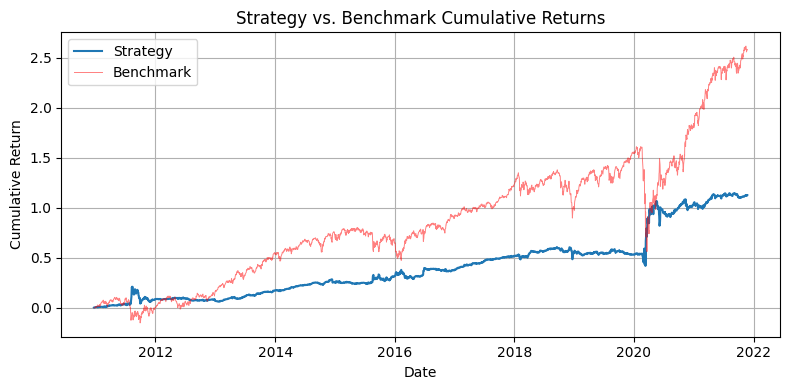

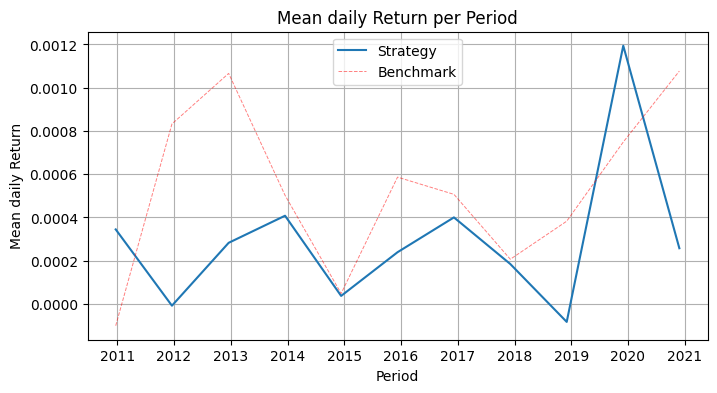

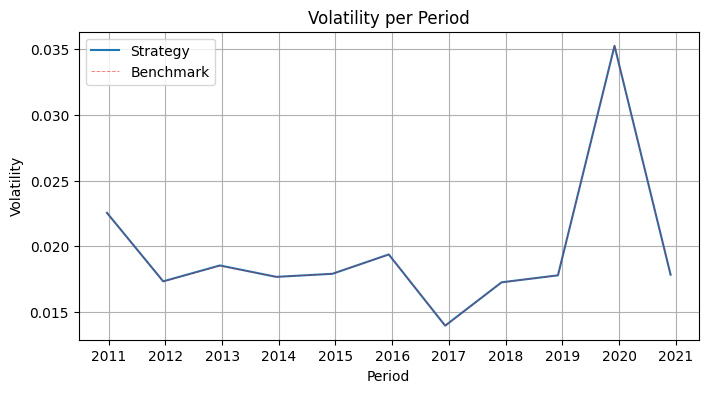

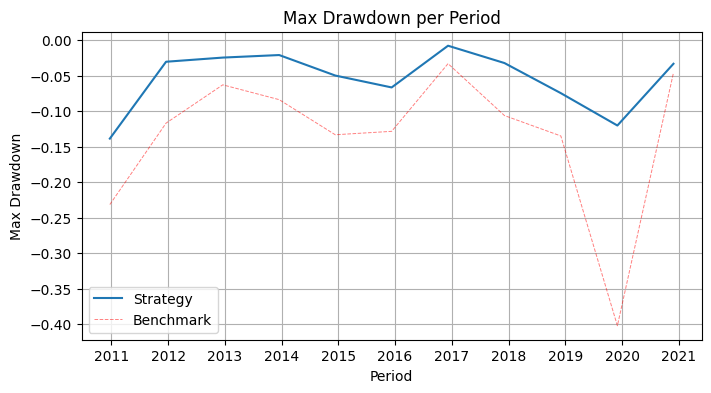

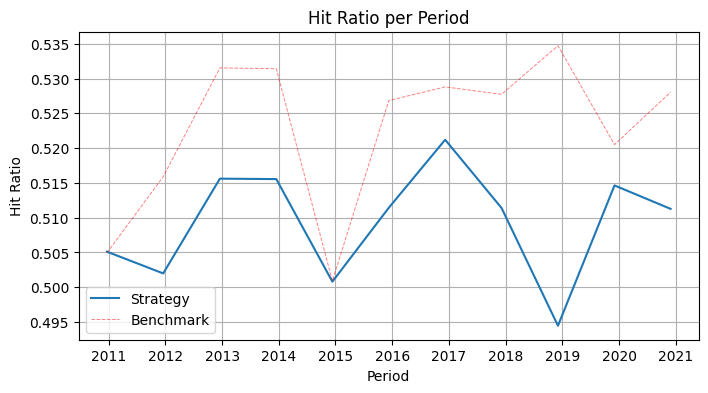

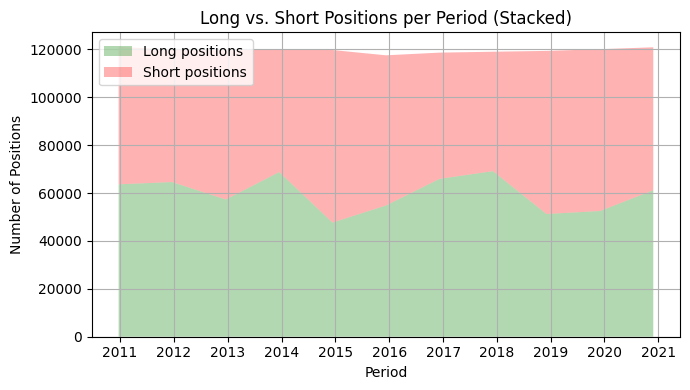

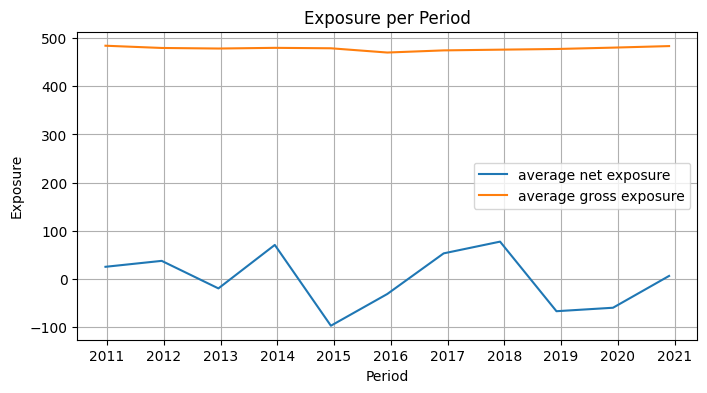

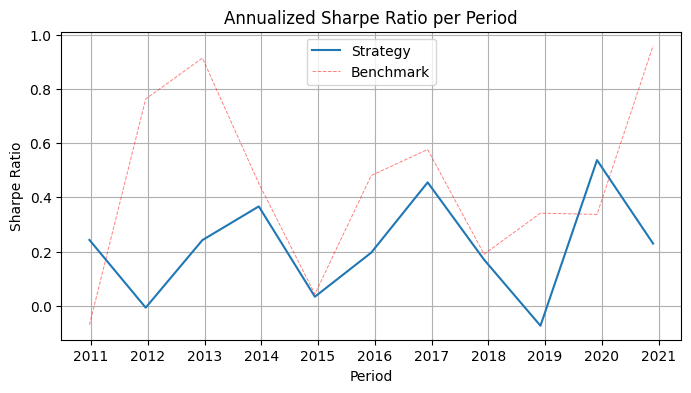

Benchmark  Strategy
overall mean daily return        0.0533%   0.0297%
overall volatility daily         2.0306%   2.0311%
overall annualized return         13.42%     7.48%
overall annualized volatility     32.24%    32.24%
overall max drawdown             -40.20%   -13.88%
overall sharpe ratio            0.416365  0.231884
overall hit ratio                 52.28%    50.94%
overall average net exposure         NaN     -0.78
overall average gross exposure       NaN    478.59
overall total positions              NaN   1316119
overall long %                       NaN    49.92%

In [ ]:
binary_strategy_metrics = backtesting(results, binary_strategy_performance, K=0.00, leverage=1, LongOnly=False)
binary_strategy_metrics

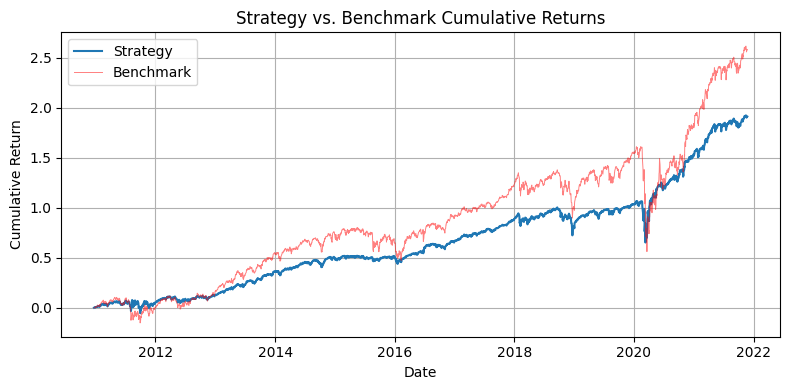

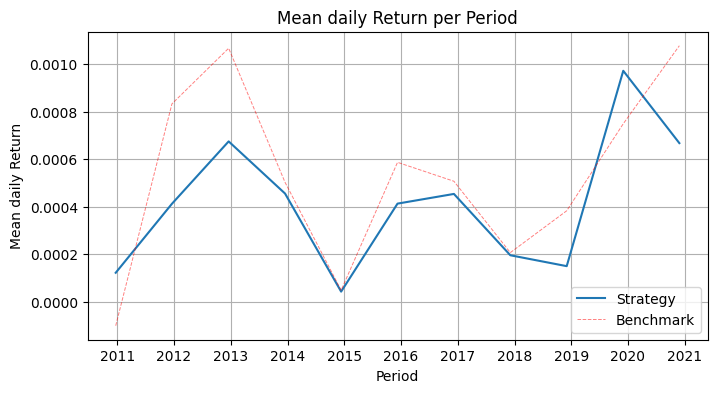

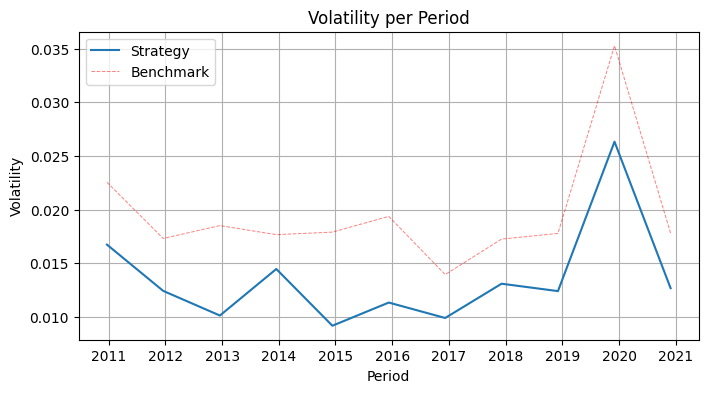

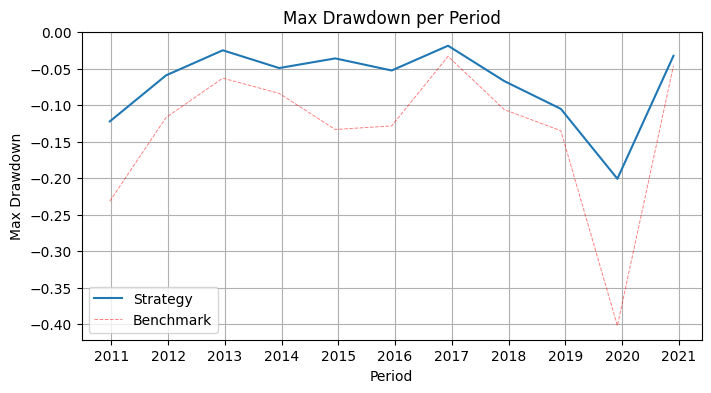

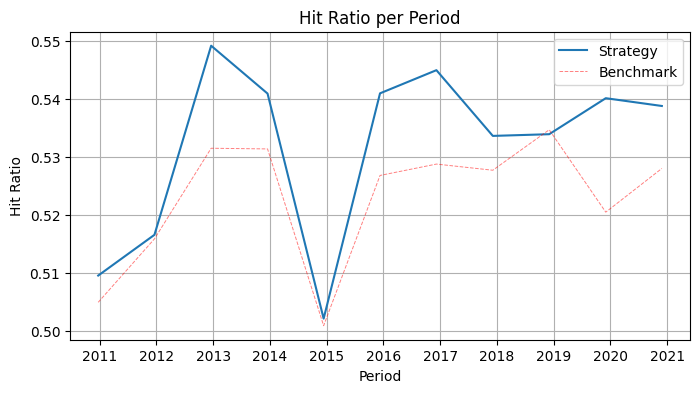

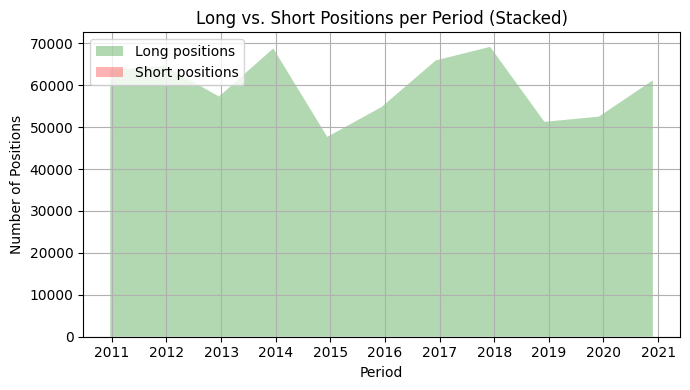

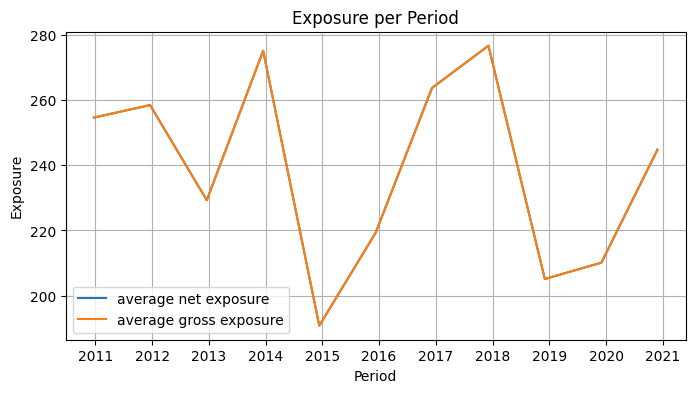

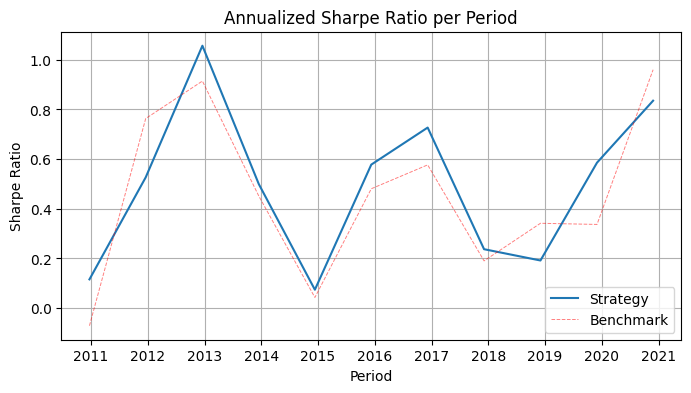

Benchmark  Strategy
overall mean daily return        0.0533%   0.0415%
overall volatility daily         2.0306%   1.4279%
overall annualized return         13.42%    10.45%
overall annualized volatility     32.24%    22.67%
overall max drawdown             -40.20%   -20.09%
overall sharpe ratio            0.416365  0.460968
overall hit ratio                 52.28%    53.23%
overall average net exposure         NaN    238.91
overall average gross exposure       NaN    238.91
overall total positions              NaN    656992
overall long %                       NaN   100.00%

In [ ]:
binary_strategy_metrics = backtesting(results, binary_strategy_performance, K=0.00, leverage=1, LongOnly=True)
binary_strategy_metrics

### 5.2 Continuous Transformation strategies

An other approach that might be worth exploring is to apply a mapping to the prediction. In other terms, mapping the prediction that are bewteen 0 and 1 onto the positions (between -1 and 1) using a particular function.

To make more clear what that means, lets consider an example that we will backtest. Lets say the prediction for stock ABC is 1, then we go long, 0.5, we hold and 0 we go short. What happens in between those is what we are interested in. We could imagine mapping $[0,1]$ to $[-1,1]$ linearly using the function $f(x) = 2x - 1$.

But in reality, we could use any function that maps properly those segments together.

Below is a list of several mappings that might make sense along with their corresponding functions:

- **Linear Mapping**  
  This is the simplest mapping, where the transformation is linear:
  $$
  f(x) = 2x - 1
  $$
  More generally, for mapping an interval $[a,b]$ to $[-1,1]$, you can use:
  $$
  f(x) = \frac{2(x-a)}{b-a} - 1
  $$

- **Sinusoidal Mapping (Using Sine)**  
  This provides a smooth "S-curve" transformation:
  $$
  f(x) = \sin\left(\pi\left(x - \frac{1}{2}\right)\right)
  $$

- **Cosine-Based Mapping**  
  Another smooth mapping using cosine:
  $$
  f(x) = -\cos(\pi x)
  $$

- **Logistic Sigmoid Mapping**  
  A logistic sigmoid function modified to map the interval $[0,1]$ onto $[-1,1]$. Here, $k$ is a parameter controlling the steepness:
  $$
  f(x) = \frac{2}{1 + e^{-k\left(x-\frac{1}{2}\right)}} - 1
  $$

- **Hyperbolic Tangent Mapping**  
  Using the hyperbolic tangent, which naturally has an output range of $[-1, 1]$. Again, $k$ controls the steepness:
  $$
  f(x) = \tanh\left(k\left(x-\frac{1}{2}\right)\right)
  $$

- **Power Law Mapping (Generalized Non-Linear Mapping)**  
  Here, $\gamma$ is a parameter that introduces curvature. The linear mapping is recovered when $\gamma=1$:
  $$
  f(x) = 2x^\gamma - 1
  $$


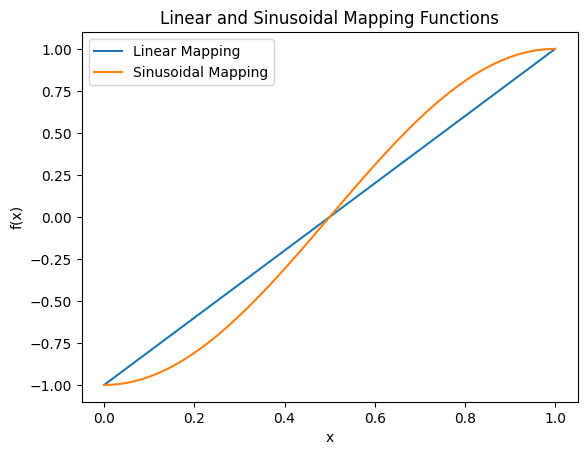

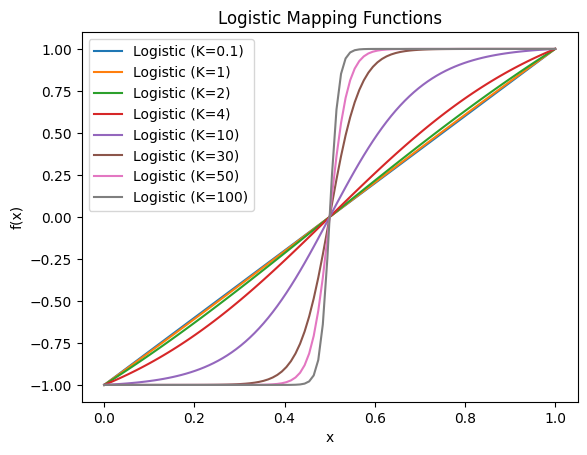

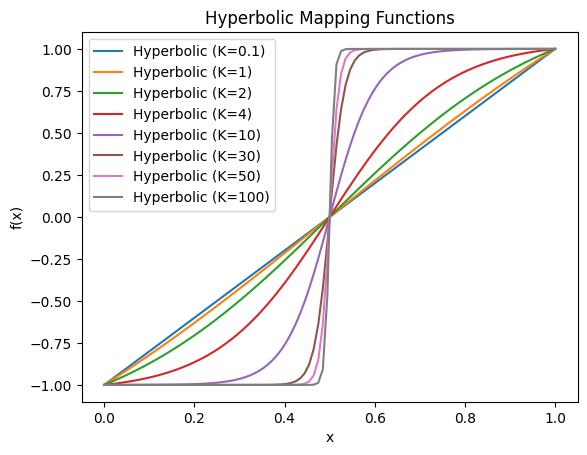

In [ ]:
def linear_mapping(x, K = None):
    # Linear mapping: f(x) = 2x - 1
    return 2 * x - 1

def sinusoidal_mapping(x, K=None):
    # Sinusoidal mapping: f(x) = sin(π(x - 1/2))
    return np.sin(np.pi * (x - 0.5))

def logistic_mapping(x, K=1):
    # Logistic sigmoid function:
    S = 1 / (1 + np.exp(-K * (x - 0.5)))
    # Compute endpoint values:
    S0 = 1 / (1 + np.exp( K/2))   # S(0)
    S1 = 1 / (1 + np.exp(-K/2))    # S(1)
    # Affine transformation to force S(0) -> -1 and S(1) -> 1:
    return 2 * (S - S0) / (S1 - S0) - 1

def hyperbolic_mapping(x, K=1):
    # The unscaled function value:
    T = np.tanh(0.5 * K)
    # Scale so that at x=0, tanh(-0.5*K) = -T becomes -1 and at x=1, tanh(0.5*K) = T becomes 1:
    return np.tanh(K * (x - 0.5)) / T

# Generate 100 points between 0 and 1.
x = np.linspace(0, 1, 100)

# Plot Linear and Sinusoidal Mappings
plt.figure()
plt.plot(x, linear_mapping(x), label='Linear Mapping')
plt.plot(x, sinusoidal_mapping(x), label='Sinusoidal Mapping')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Linear and Sinusoidal Mapping Functions')
plt.legend()
plt.show()


# Plot Strict Logistic Mappings for various K values
K_values = [0.1, 1, 2, 4, 10, 30, 50, 100]
plt.figure()
for K in K_values:
    plt.plot(x, logistic_mapping(x, K), label=f'Logistic (K={K})')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Logistic Mapping Functions')
plt.legend()
plt.show()

# Plot Strict Hyperbolic Mappings for various K values
plt.figure()
for K in K_values:
    plt.plot(x, hyperbolic_mapping(x, K), label=f'Hyperbolic (K={K})')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Hyperbolic Mapping Functions')
plt.legend()
plt.show()


As we can see, the edge cases are:   

- a linear mapping if k is very small
- a step function at $x = 0.5$ , which is equivalent to our binary trading algorithm.

all of those functions are stricly ascending, so the rankings won't be affected. We won't use those functions in conjunction with the Long/Short or Long only solutions because they involve a ranking that wouldn't be changed.

In [ ]:
def convolution_strategy_performance(trade_predictions_df, leverage=1, convolution=None, K=None, LongOnly = False):

  #Create a copy to avoid dataframe issues
  df = trade_predictions_df.copy()

  #Create positions
  df['strategy_position'] = convolution(df['prediction_proba'], K) * leverage

  #Apply long only filter
  if LongOnly:
    df['strategy_position'] = df['strategy_position'].clip(lower=0)

  #Compute returns
  df['strategy_return'] = df['strategy_position'] * df['next_day_return']

  return df

Linear convolution and it's long only counterpart :

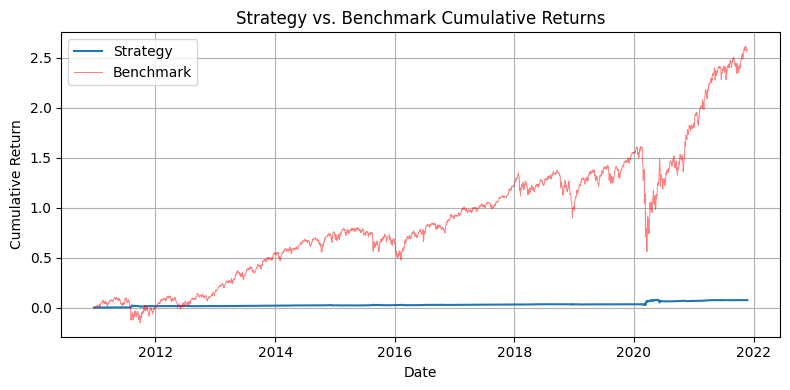

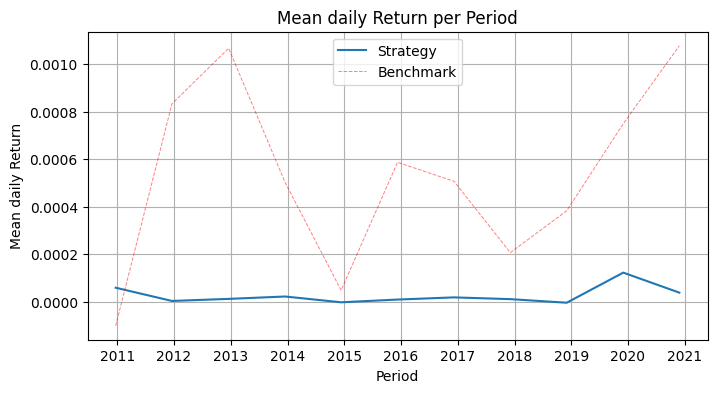

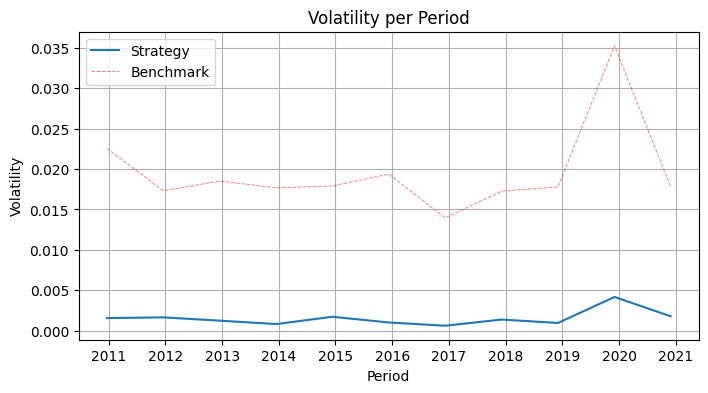

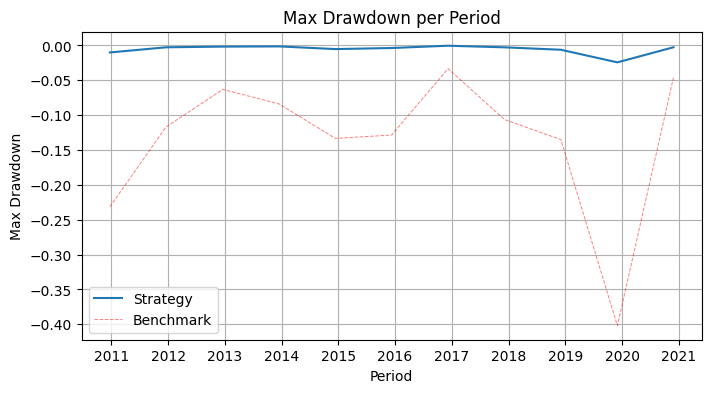

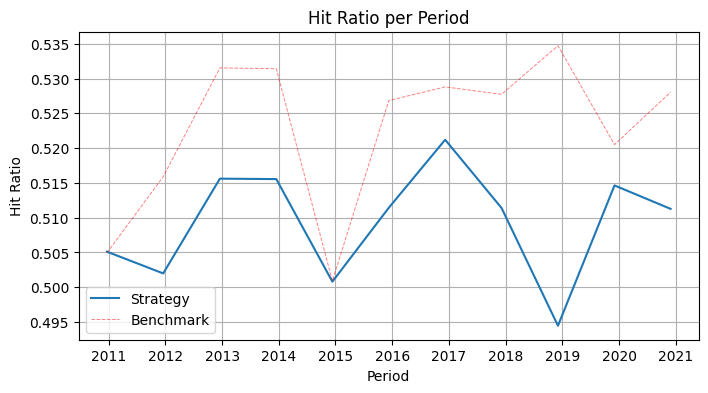

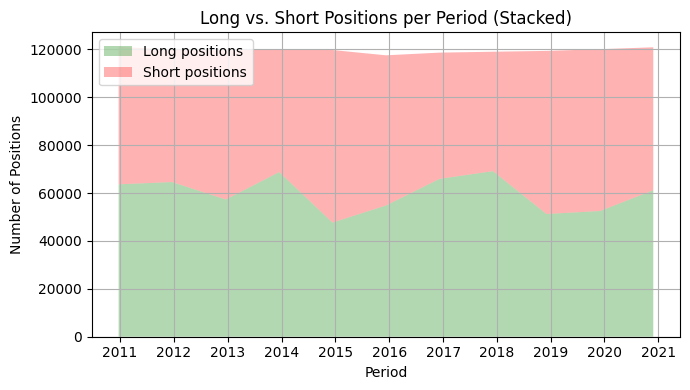

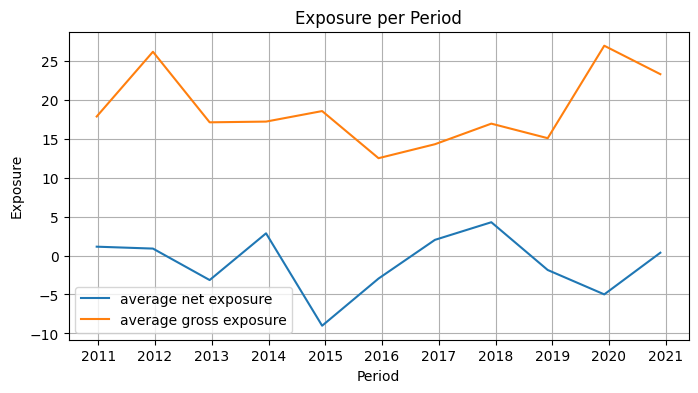

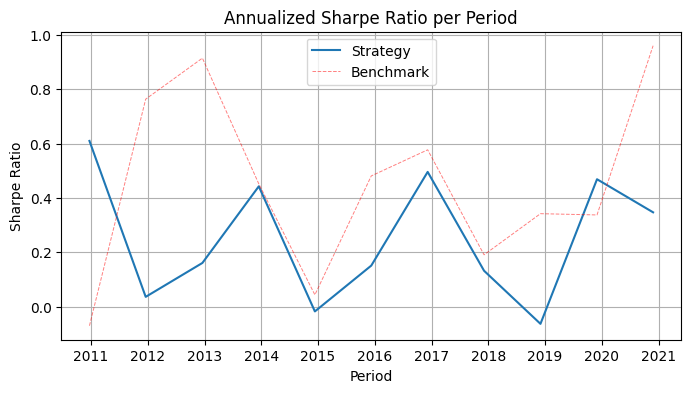

Benchmark  Strategy
overall mean daily return        0.0533%   0.0027%
overall volatility daily         2.0306%   0.1777%
overall annualized return         13.42%     0.67%
overall annualized volatility     32.24%     2.82%
overall max drawdown             -40.20%    -2.43%
overall sharpe ratio            0.416365  0.238736
overall hit ratio                 52.28%    50.94%
overall average net exposure         NaN     -0.95
overall average gross exposure       NaN     18.72
overall total positions              NaN   1316119
overall long %                       NaN    49.92%

In [ ]:
conv_linear_strategy_metrics = backtesting(results, convolution_strategy_performance,
                                           convolution = linear_mapping,
                                           K=None,
                                           leverage=1,
                                           LongOnly=False)
conv_linear_strategy_metrics

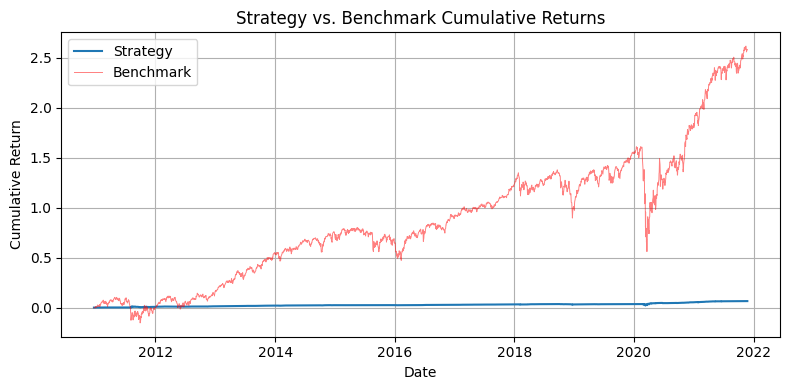

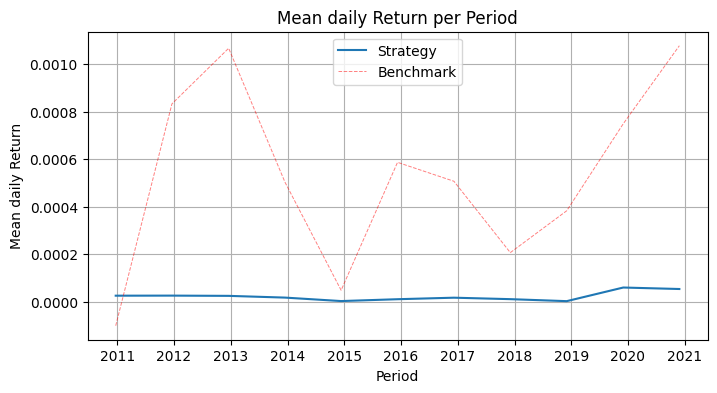

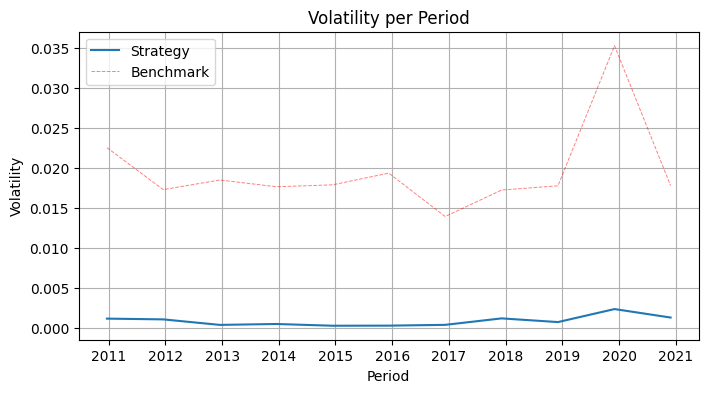

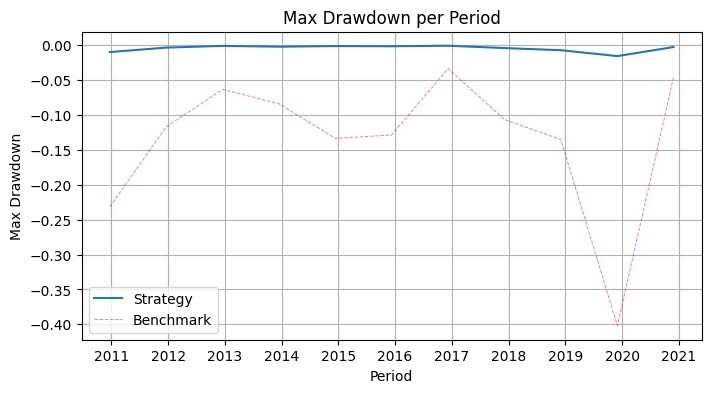

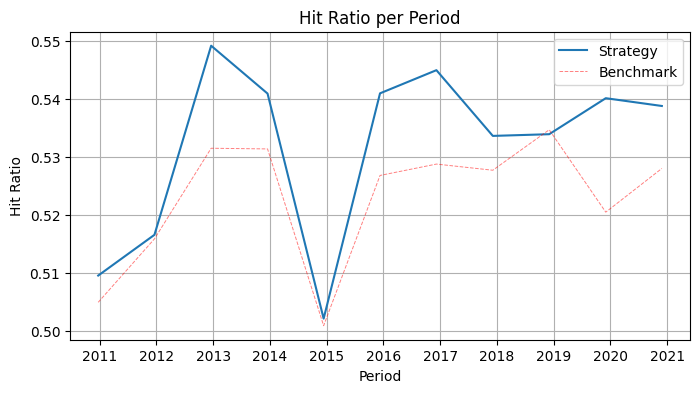

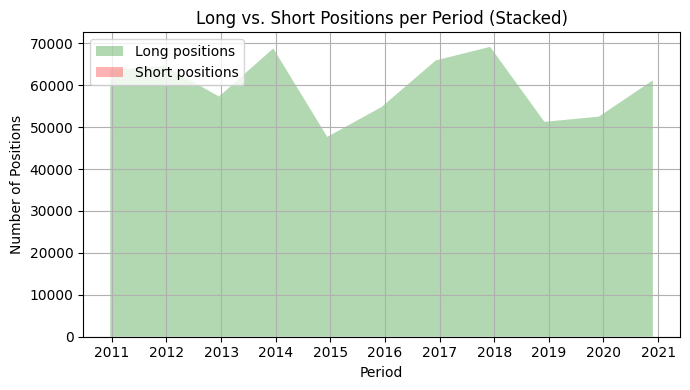

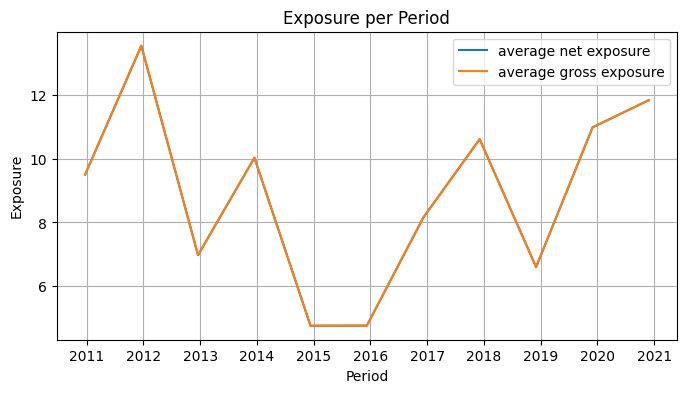

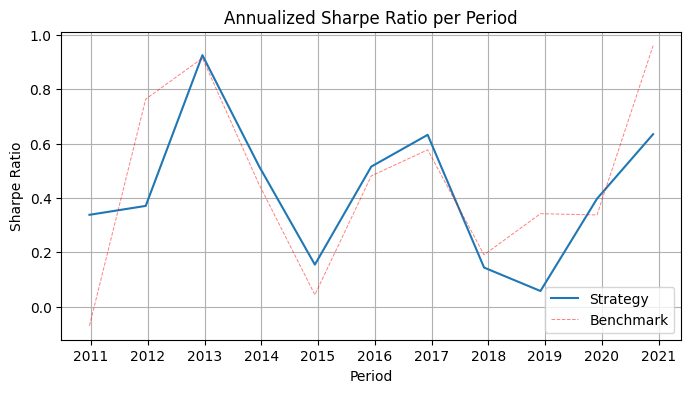

Benchmark Strategy
overall mean daily return        0.0533%  0.0023%
overall volatility daily         2.0306%  0.1105%
overall annualized return         13.42%    0.58%
overall annualized volatility     32.24%    1.75%
overall max drawdown             -40.20%   -1.54%
overall sharpe ratio            0.416365  0.33315
overall hit ratio                 52.28%   53.23%
overall average net exposure         NaN     8.88
overall average gross exposure       NaN     8.88
overall total positions              NaN   656992
overall long %                       NaN  100.00%

In [ ]:
conv_linear_LO_strategy_metrics = backtesting(results, convolution_strategy_performance,
                                           convolution = linear_mapping,
                                           K=None,
                                           leverage=1,
                                           LongOnly=True)
conv_linear_LO_strategy_metrics

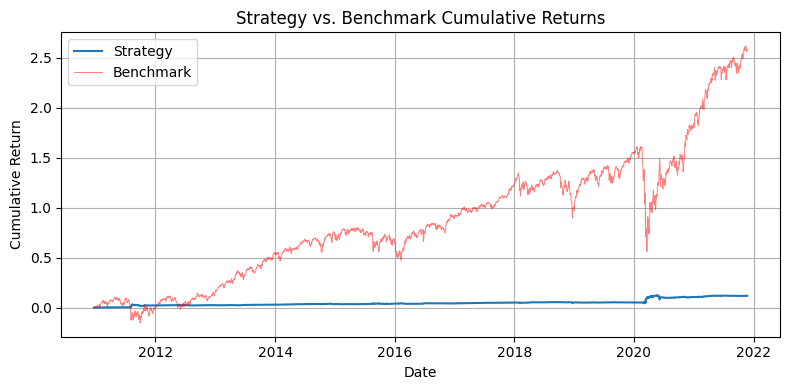

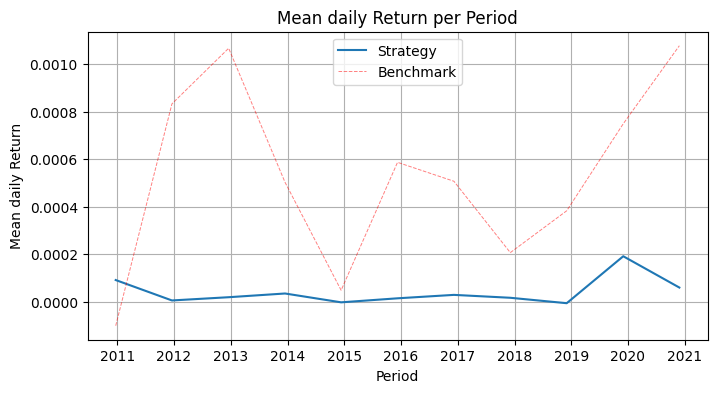

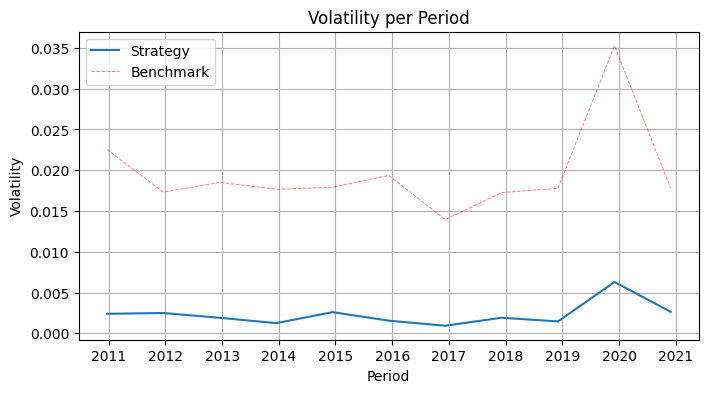

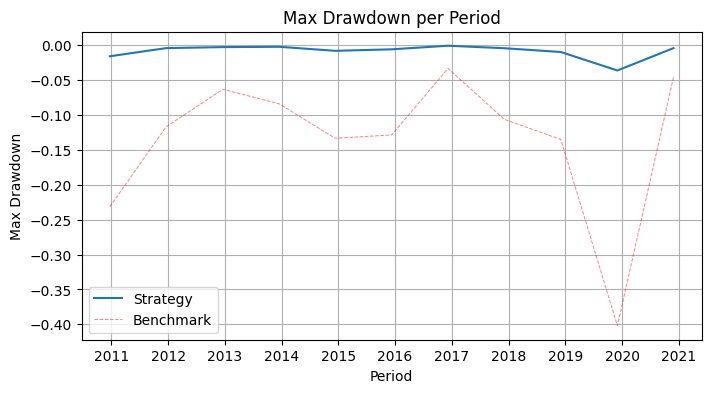

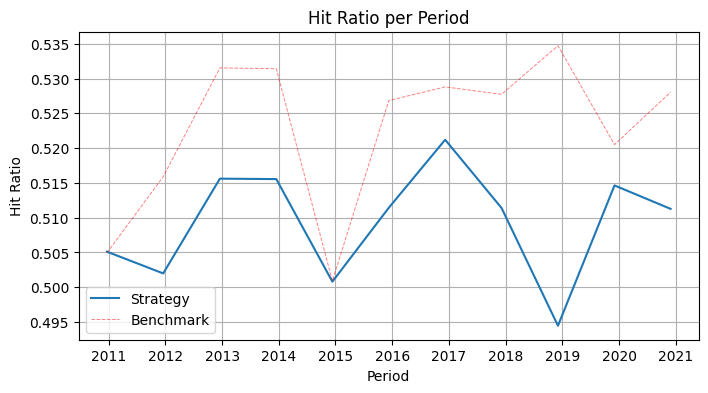

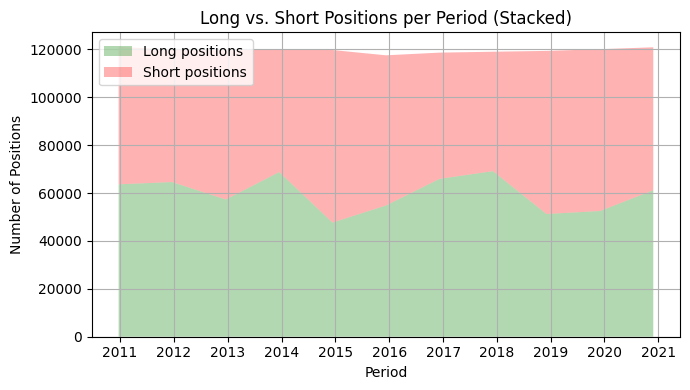

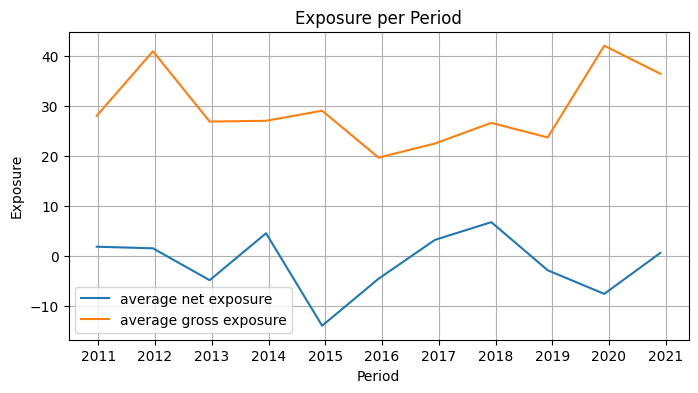

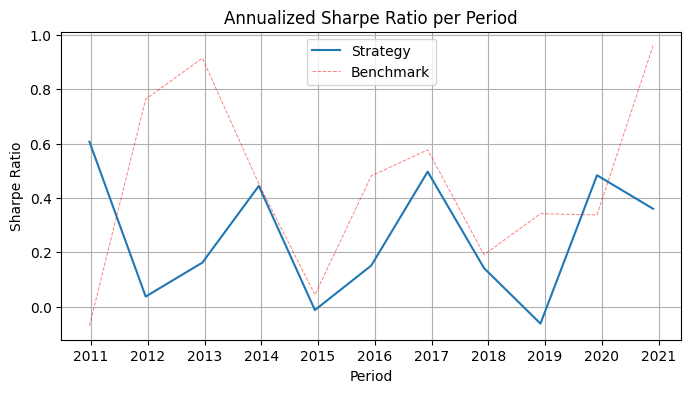

Benchmark  Strategy
overall mean daily return        0.0533%   0.0042%
overall volatility daily         2.0306%   0.2695%
overall annualized return         13.42%     1.05%
overall annualized volatility     32.24%     4.28%
overall max drawdown             -40.20%    -3.62%
overall sharpe ratio            0.416365  0.245473
overall hit ratio                 52.28%    50.94%
overall average net exposure         NaN     -1.45
overall average gross exposure       NaN     29.28
overall total positions              NaN   1316119
overall long %                       NaN    49.92%

In [ ]:
conv_sin_strategy_metrics = backtesting(results, convolution_strategy_performance,
                                           convolution = sinusoidal_mapping,
                                           K=None,
                                           leverage=1,
                                           LongOnly=False)
conv_sin_strategy_metrics

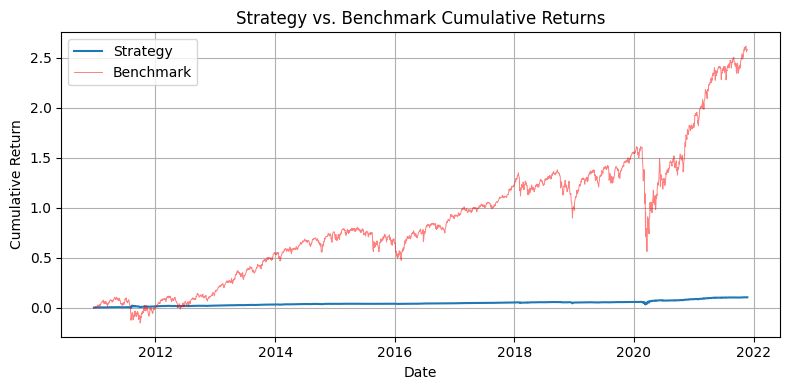

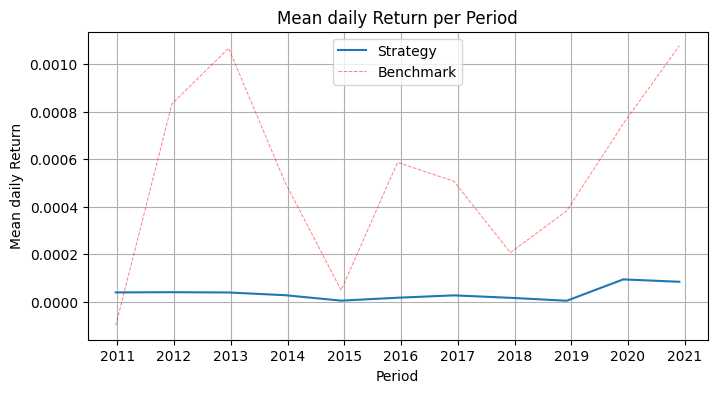

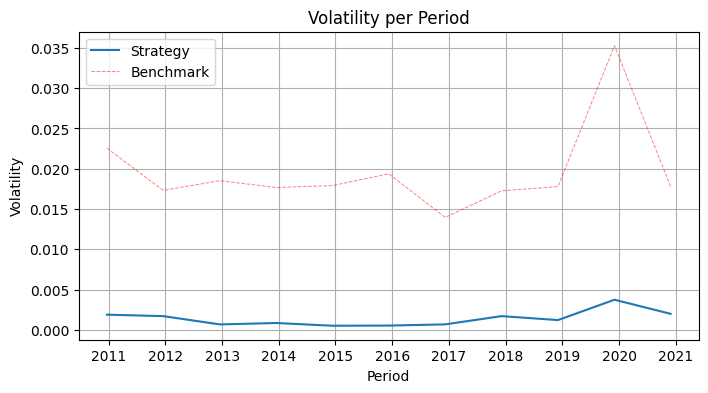

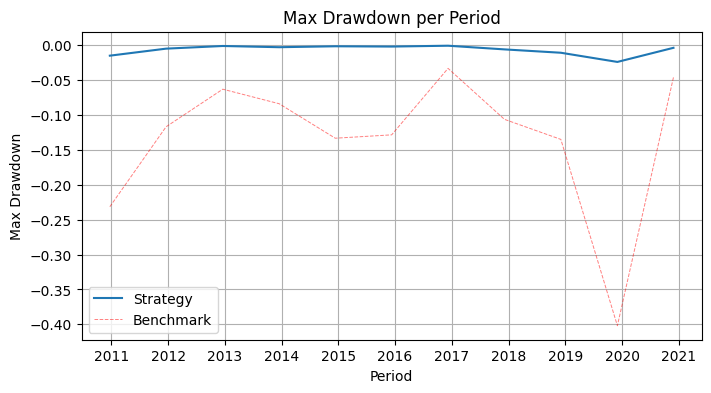

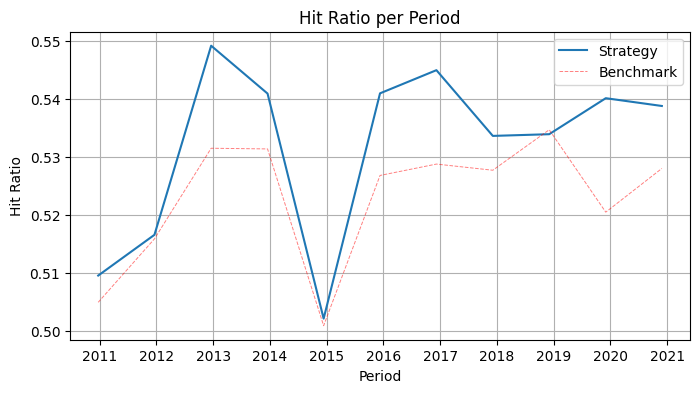

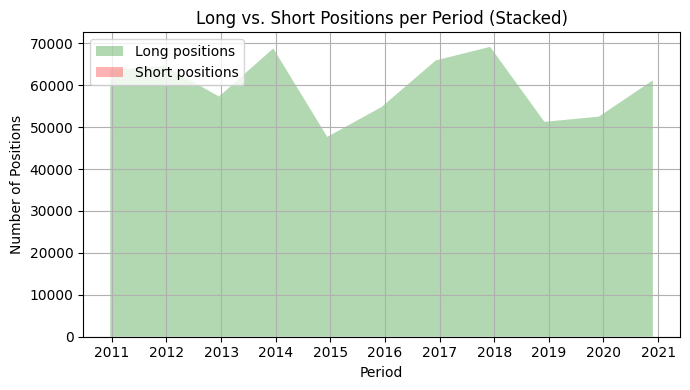

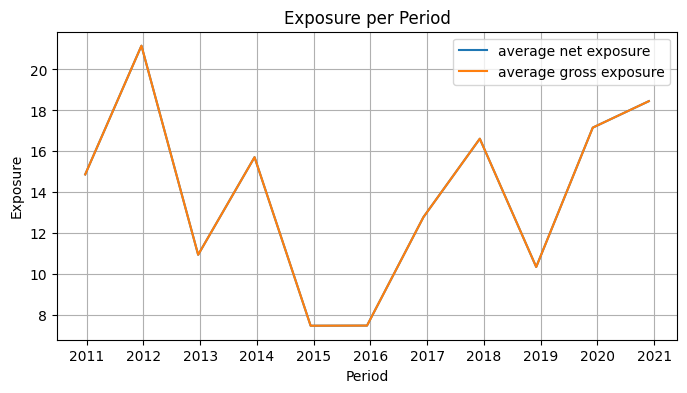

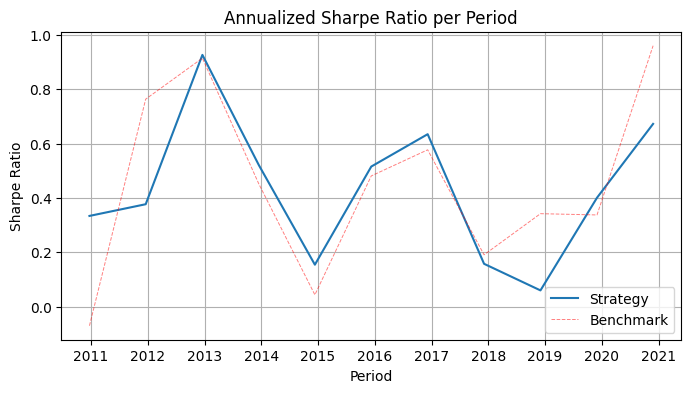

Benchmark  Strategy
overall mean daily return        0.0533%   0.0036%
overall volatility daily         2.0306%   0.1681%
overall annualized return         13.42%     0.91%
overall annualized volatility     32.24%     2.67%
overall max drawdown             -40.20%    -2.41%
overall sharpe ratio            0.416365  0.341479
overall hit ratio                 52.28%    53.23%
overall average net exposure         NaN     13.91
overall average gross exposure       NaN     13.91
overall total positions              NaN    656992
overall long %                       NaN   100.00%

In [ ]:
conv_sin_LO_strategy_metrics = backtesting(results, convolution_strategy_performance,
                                           convolution = sinusoidal_mapping,
                                           K=None,
                                           leverage=1,
                                           LongOnly=True)
conv_sin_LO_strategy_metrics

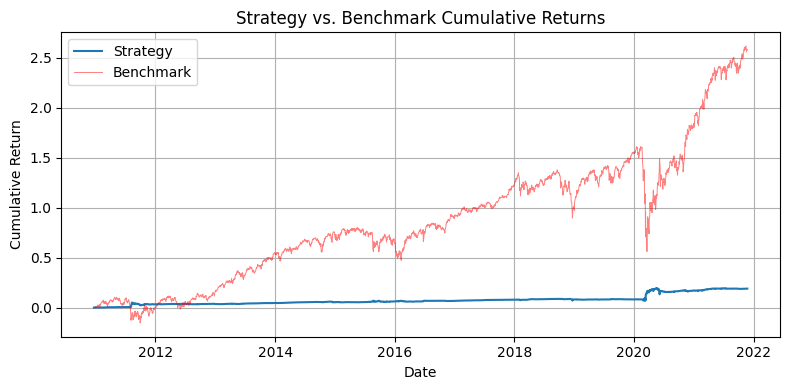

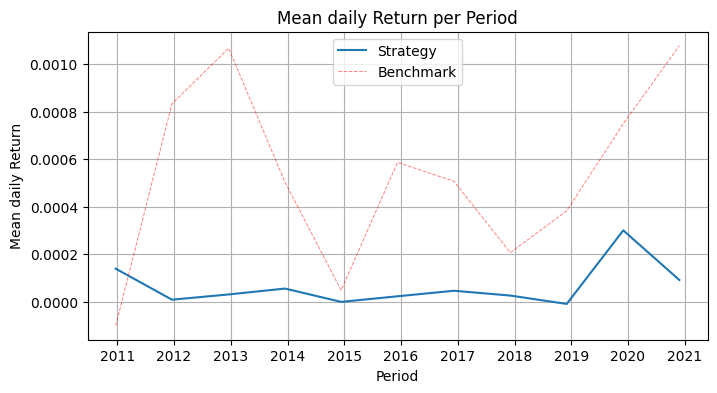

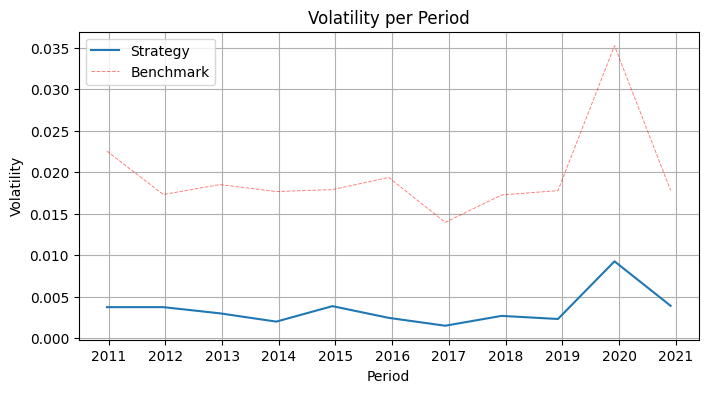

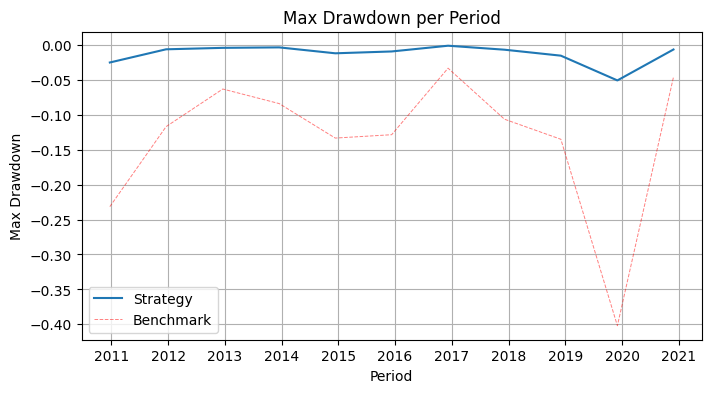

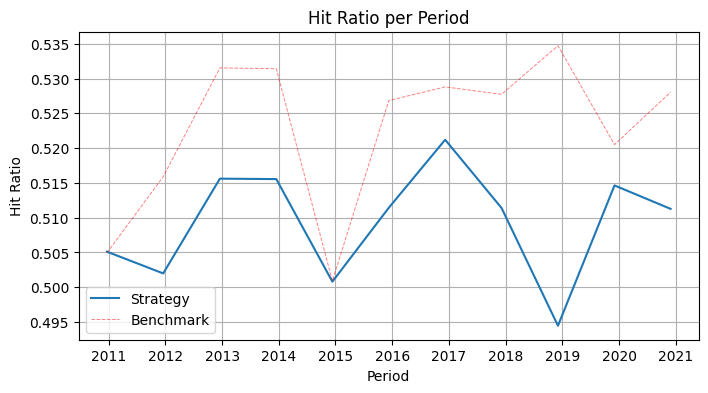

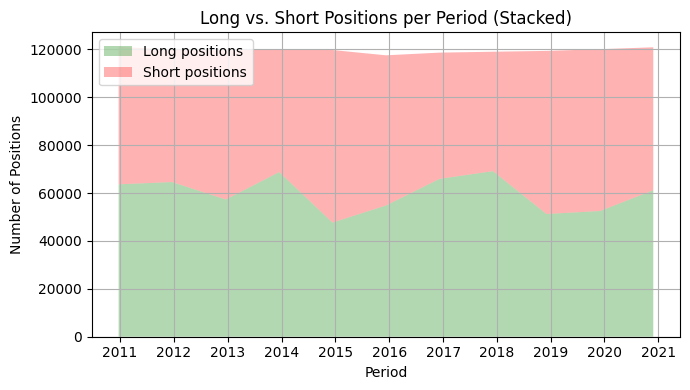

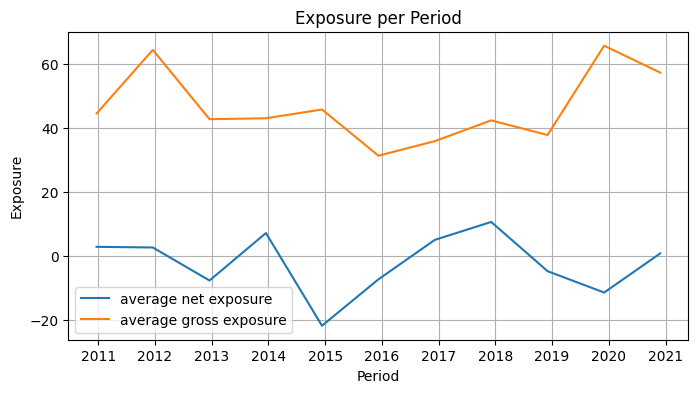

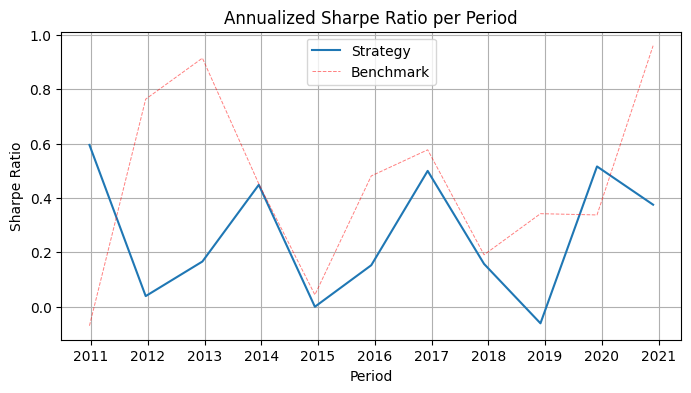

Benchmark  Strategy
overall mean daily return        0.0533%   0.0065%
overall volatility daily         2.0306%   0.4011%
overall annualized return         13.42%     1.64%
overall annualized volatility     32.24%     6.37%
overall max drawdown             -40.20%    -5.08%
overall sharpe ratio            0.416365  0.258123
overall hit ratio                 52.28%    50.94%
overall average net exposure         NaN     -2.15
overall average gross exposure       NaN     46.53
overall total positions              NaN   1316119
overall long %                       NaN    49.92%

In [ ]:
conv_log_strategy_metrics = backtesting(results, convolution_strategy_performance,
                                           convolution = logistic_mapping,
                                           K=10,
                                           leverage=1,
                                           LongOnly=False)
conv_log_strategy_metrics

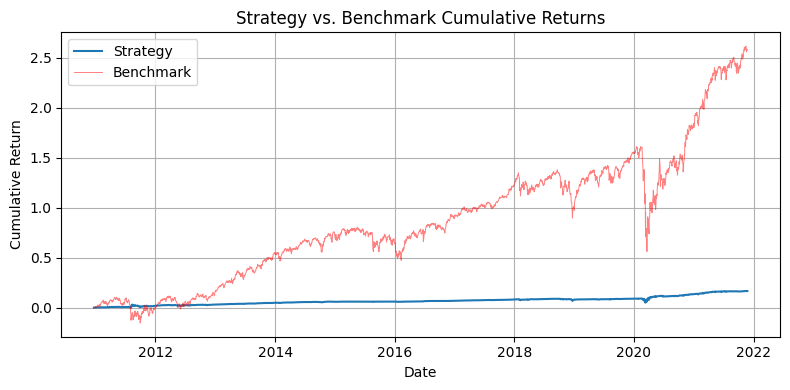

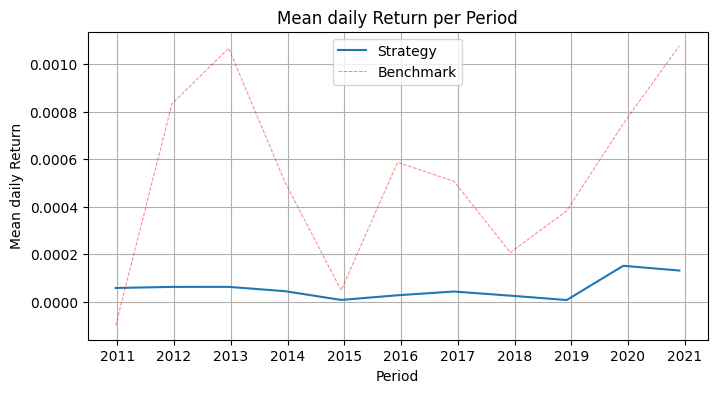

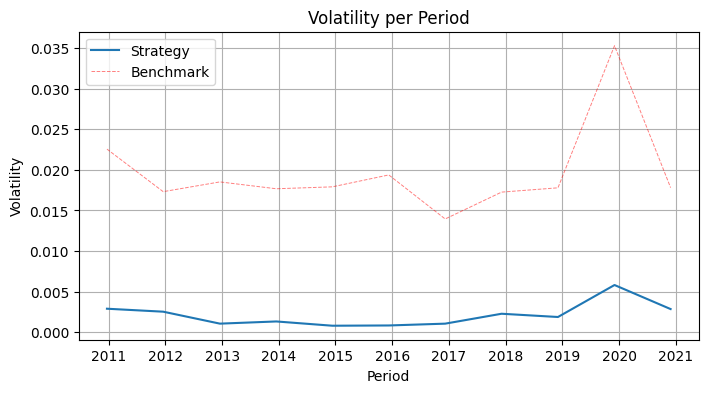

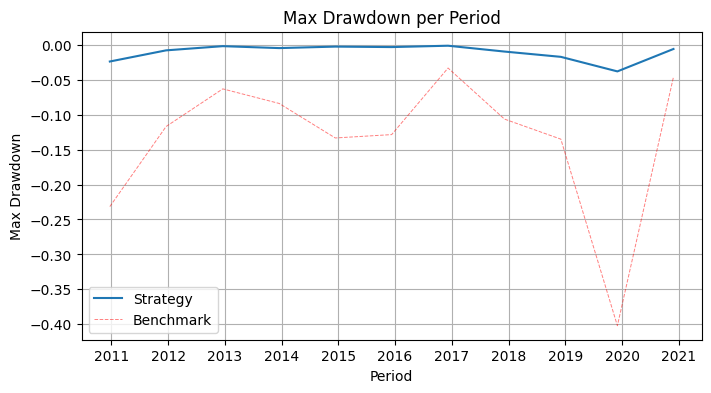

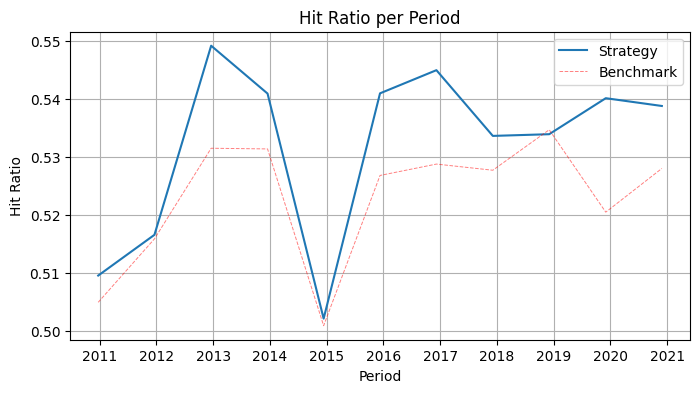

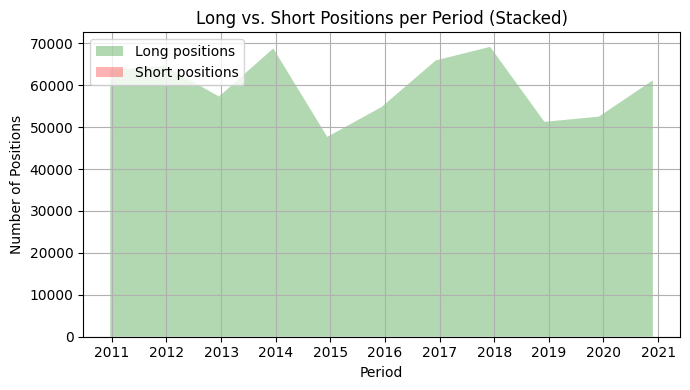

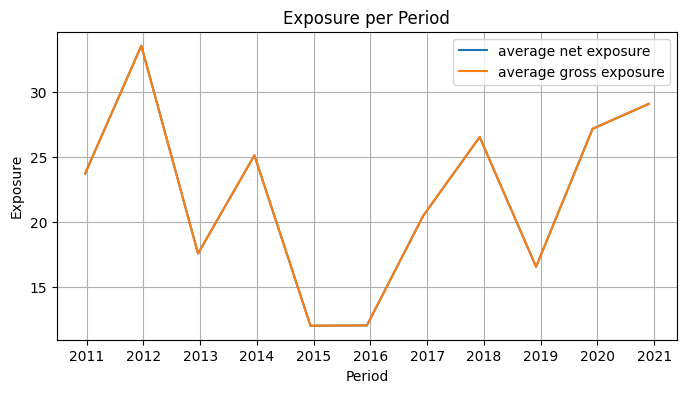

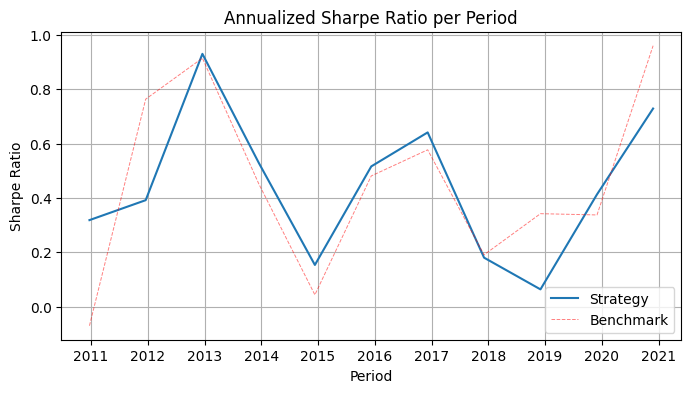

Benchmark  Strategy
overall mean daily return        0.0533%   0.0057%
overall volatility daily         2.0306%   0.2554%
overall annualized return         13.42%     1.43%
overall annualized volatility     32.24%     4.05%
overall max drawdown             -40.20%    -3.81%
overall sharpe ratio            0.416365  0.353762
overall hit ratio                 52.28%    53.23%
overall average net exposure         NaN     22.19
overall average gross exposure       NaN     22.19
overall total positions              NaN    656992
overall long %                       NaN   100.00%

In [ ]:
conv_log_LO_strategy_metrics = backtesting(results, convolution_strategy_performance,
                                           convolution = logistic_mapping,
                                           K=10,
                                           leverage=1,
                                           LongOnly=True)
conv_log_LO_strategy_metrics

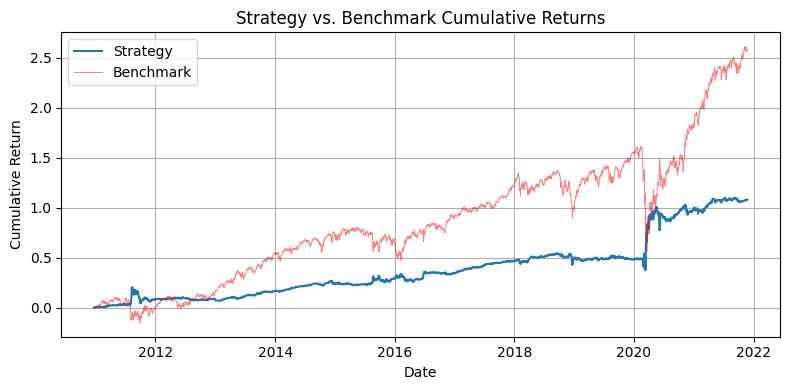

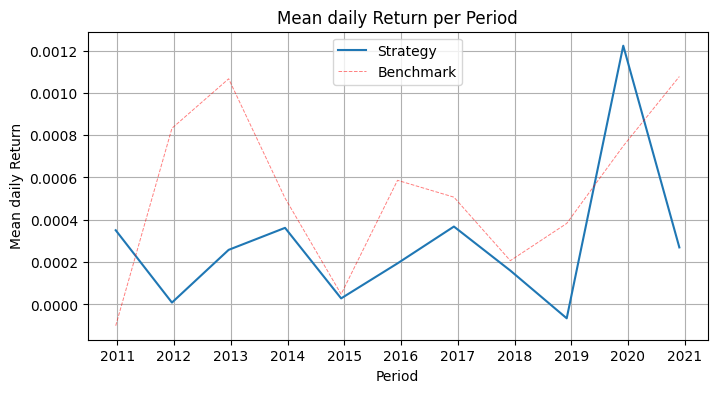

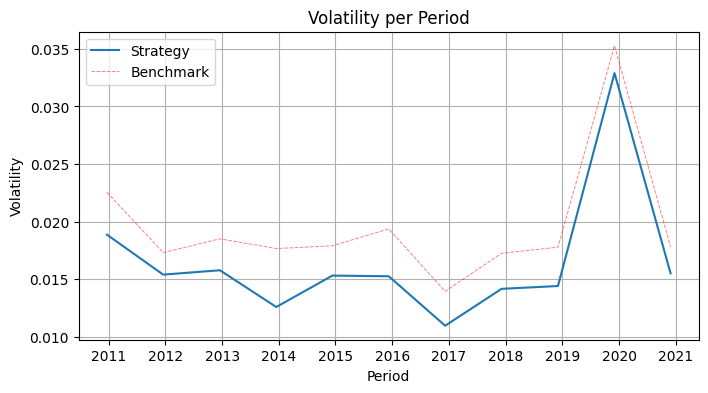

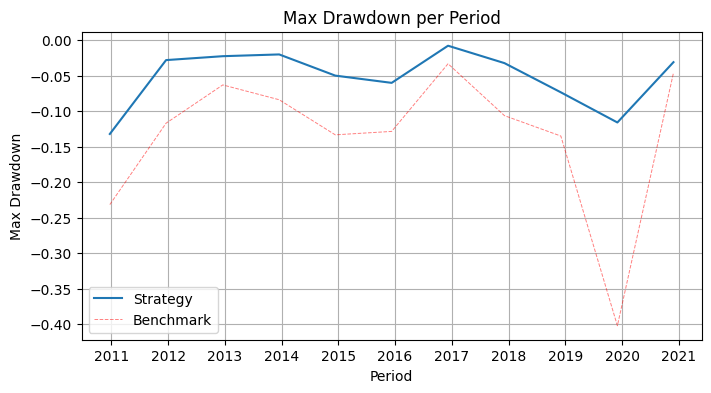

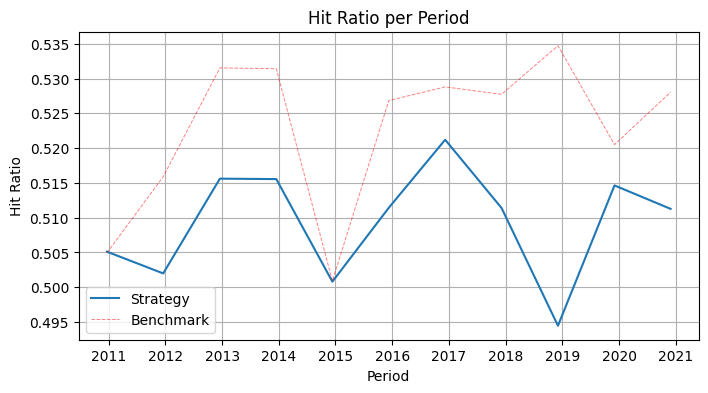

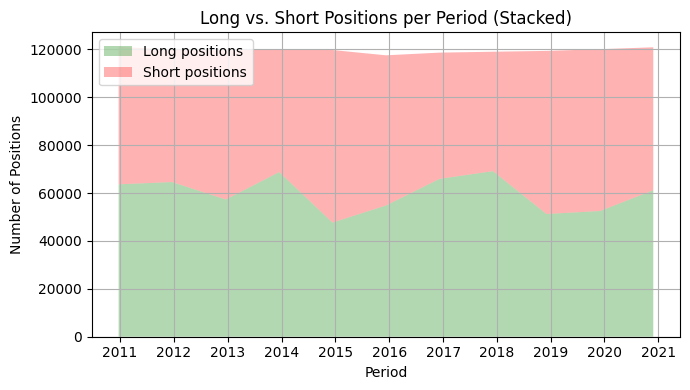

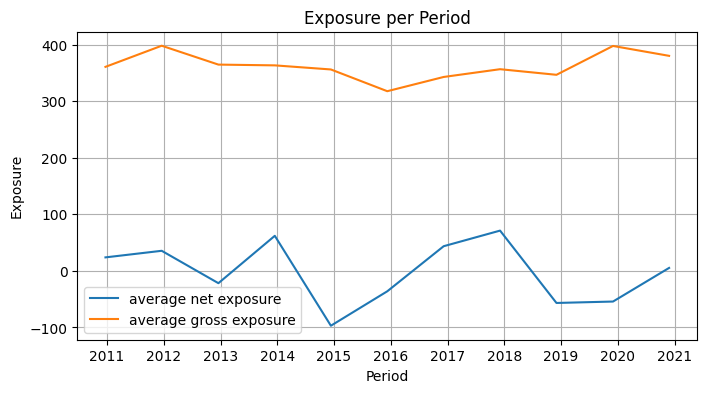

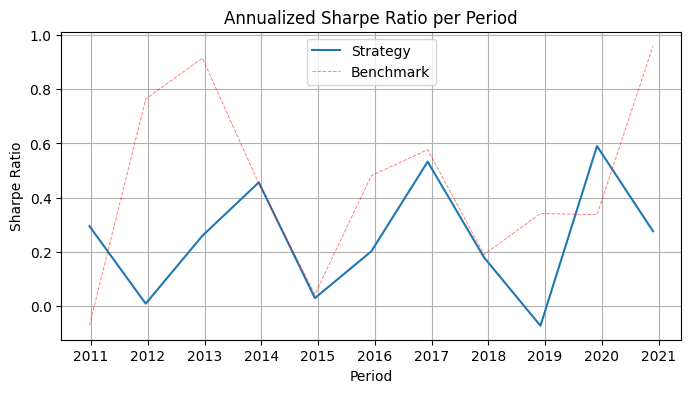

Benchmark  Strategy
overall mean daily return        0.0533%   0.0288%
overall volatility daily         2.0306%   1.7392%
overall annualized return         13.42%     7.25%
overall annualized volatility     32.24%    27.61%
overall max drawdown             -40.20%   -13.21%
overall sharpe ratio            0.416365  0.262477
overall hit ratio                 52.28%    50.94%
overall average net exposure         NaN     -2.17
overall average gross exposure       NaN    362.15
overall total positions              NaN   1316119
overall long %                       NaN    49.92%

In [ ]:
conv_hyp_strategy_metrics = backtesting(results, convolution_strategy_performance,
                                           convolution = hyperbolic_mapping,
                                           K=100,
                                           leverage=1,
                                           LongOnly=False)
conv_hyp_strategy_metrics

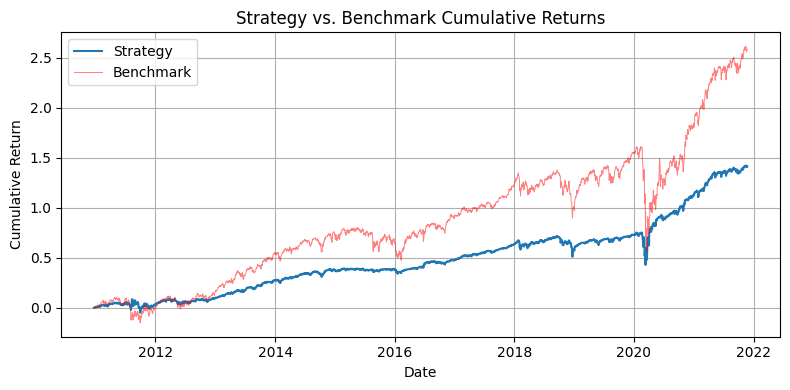

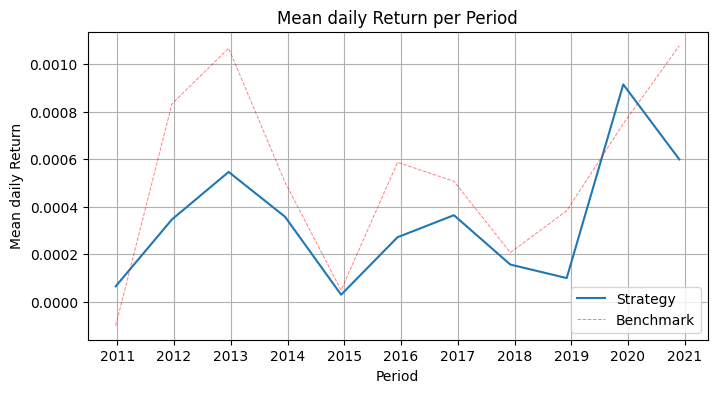

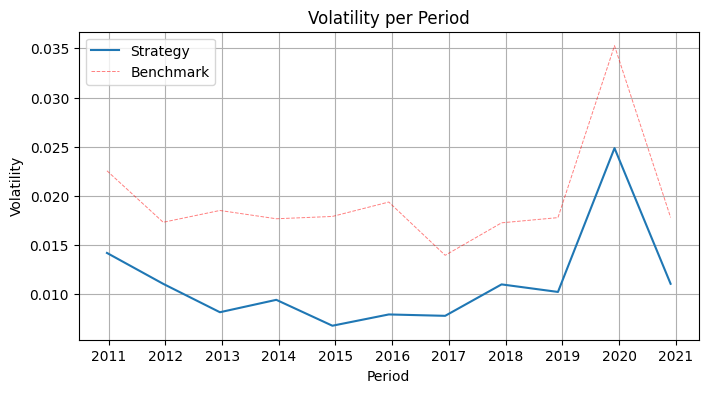

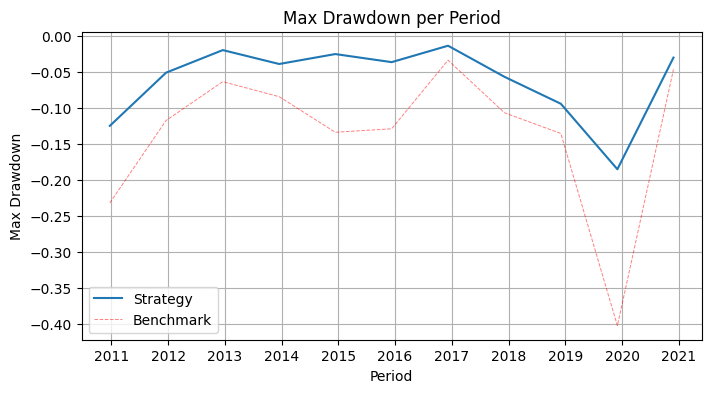

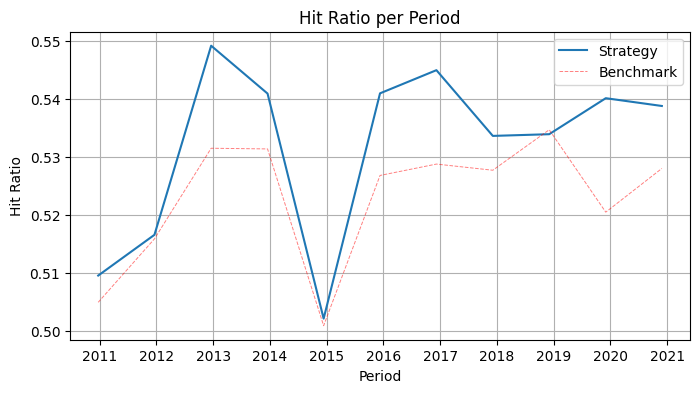

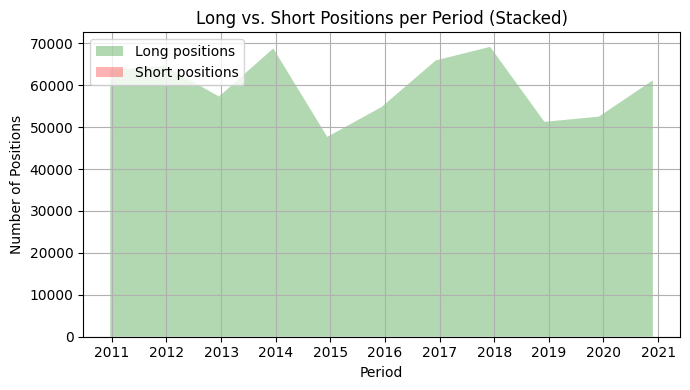

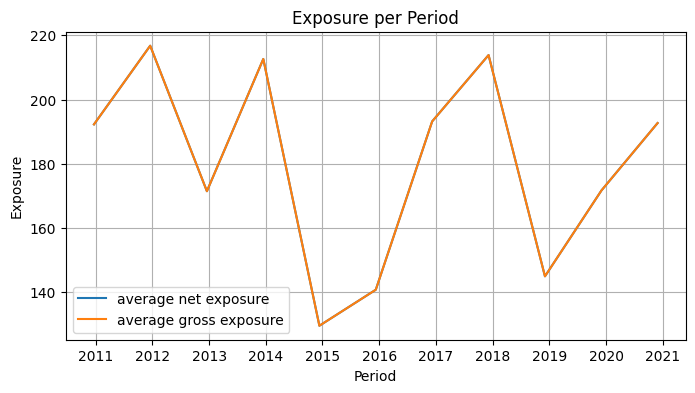

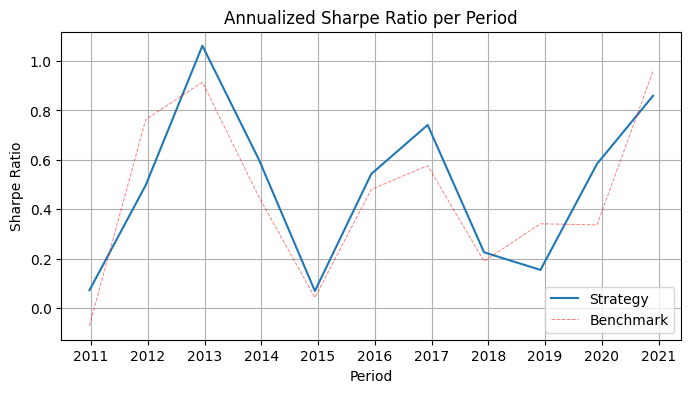

Benchmark  Strategy
overall mean daily return        0.0533%   0.0341%
overall volatility daily         2.0306%   1.2133%
overall annualized return         13.42%     8.60%
overall annualized volatility     32.24%    19.26%
overall max drawdown             -40.20%   -18.47%
overall sharpe ratio            0.416365  0.446545
overall hit ratio                 52.28%    53.23%
overall average net exposure         NaN    179.99
overall average gross exposure       NaN    179.99
overall total positions              NaN    656992
overall long %                       NaN   100.00%

In [ ]:
conv_hyp_LO_strategy_metrics = backtesting(results, convolution_strategy_performance,
                                           convolution = hyperbolic_mapping,
                                           K=100,
                                           leverage=1,
                                           LongOnly=True)
conv_hyp_LO_strategy_metrics

### 5.2 Portfolio optimization strategies.

Another strategy is to go long the K stocks where the algorithm is the most 'sure they're going up' (meaning where the value of the prediction is closest to 1) and go short the K stocks where the algorithm is the most 'sure they are going down' (meaning where the value of the prediction is closest to 0).

In this section, we test 4 strategies:

- Long/Short K (absolute), where we do what is described above.
- Long/Short K (relative). Where instead of selecting an absolute number of stocks, we go long the upper K% and short the lower K%.

- Long only K (aboslute) where we do the same as before but go long only.
- Long only K (relative) where we do the same as before but go long only.

On all these functions, we allow leverage if one might want to test using it.

In [ ]:
def LSK_absolute_strategy_performance(trade_predictions_df, leverage=1, K=10, LongOnly=False):
    df = trade_predictions_df.copy()
    # rank 1..N within each date
    df['rank_asc']  = df.groupby('date')['prediction_proba'].rank(method='first')
    df['rank_desc'] = df.groupby('date')['prediction_proba'].rank(method='first', ascending=False)

    # long = top K  ⇒ rank_desc <= K
    df['strategy_position'] = np.where(
        df['rank_desc'] <= K,
        1 * leverage,
        0
    )
    # short = bottom K ⇒ rank_asc <= K (unless LongOnly)
    if not LongOnly:
        df['strategy_position'] = np.where(
            df['rank_asc'] <= K,
            -1 * leverage,
            df['strategy_position']
        )

    df['strategy_return'] = df['strategy_position'] * df['next_day_return']

    df.drop(columns=['rank_asc', 'rank_desc'], inplace=True)

    return df


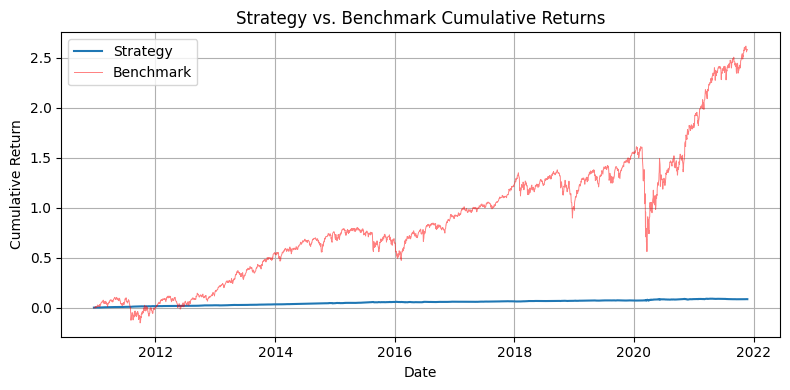

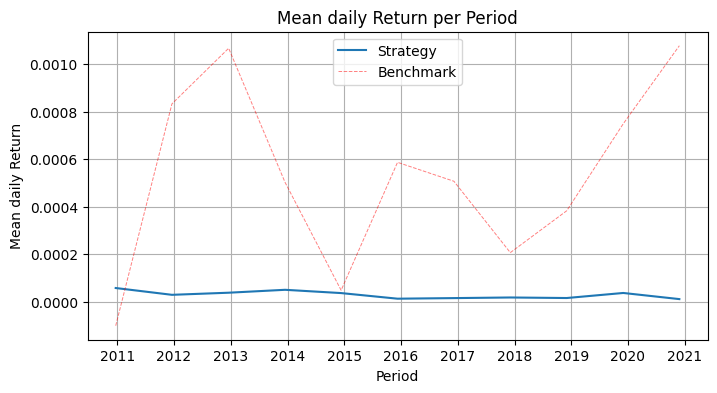

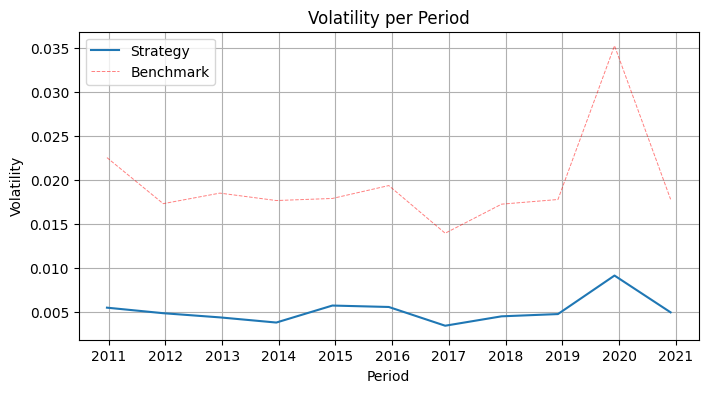

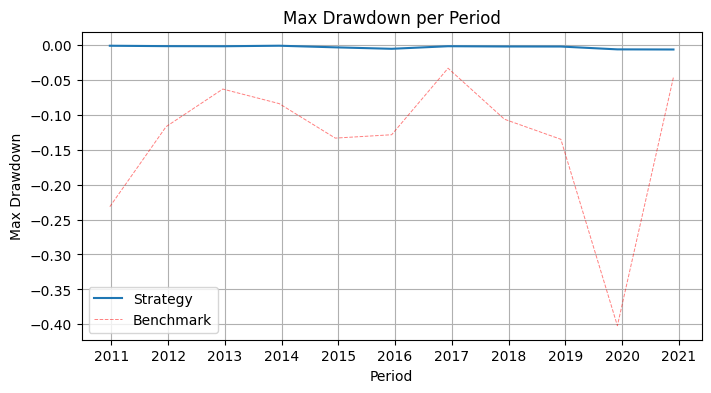

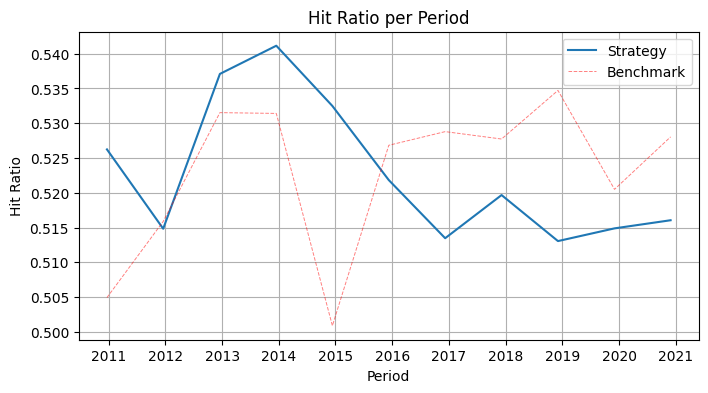

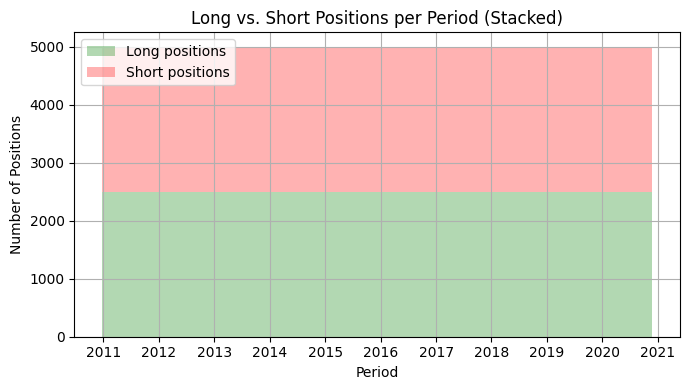

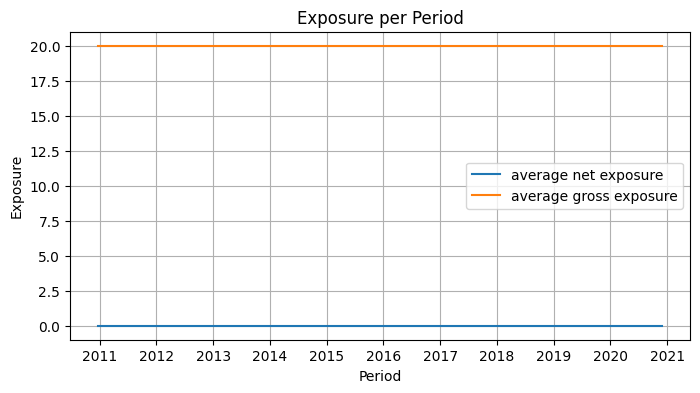

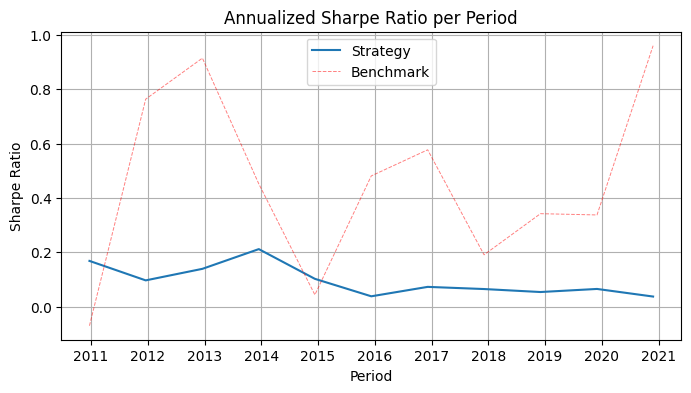

Benchmark  Strategy
overall mean daily return        0.0533%   0.0030%
overall volatility daily         2.0306%   0.5347%
overall annualized return         13.42%     0.75%
overall annualized volatility     32.24%     8.49%
overall max drawdown             -40.20%    -0.65%
overall sharpe ratio            0.416365  0.087868
overall hit ratio                 52.28%    52.28%
overall average net exposure         NaN      0.00
overall average gross exposure       NaN     20.00
overall total positions              NaN     55000
overall long %                       NaN    50.00%

In [ ]:
LSK_abs_strategy_metrics = backtesting(results, LSK_absolute_strategy_performance,
                                           K=10,
                                           leverage=1,
                                           LongOnly=False)
LSK_abs_strategy_metrics

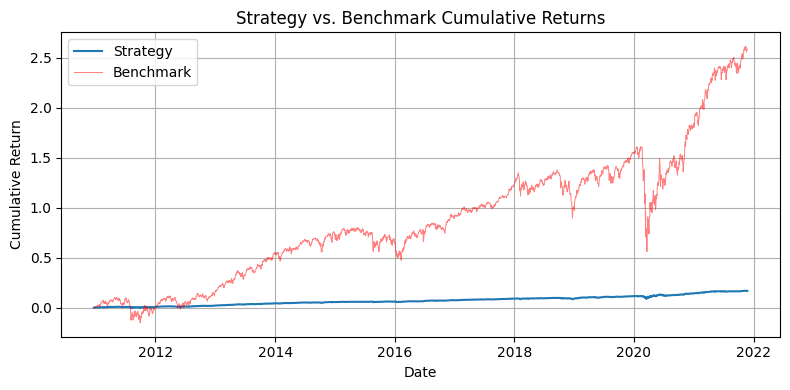

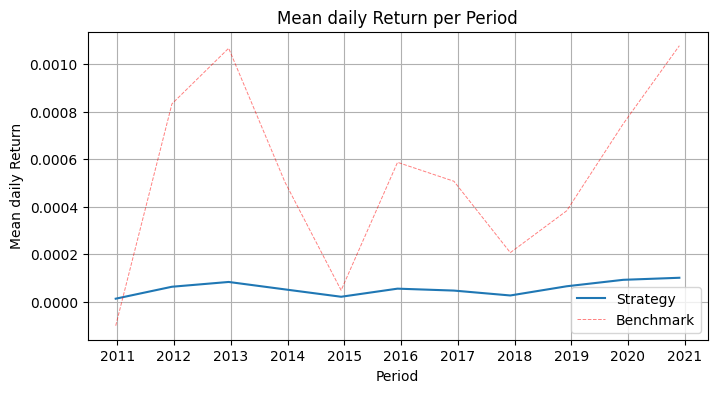

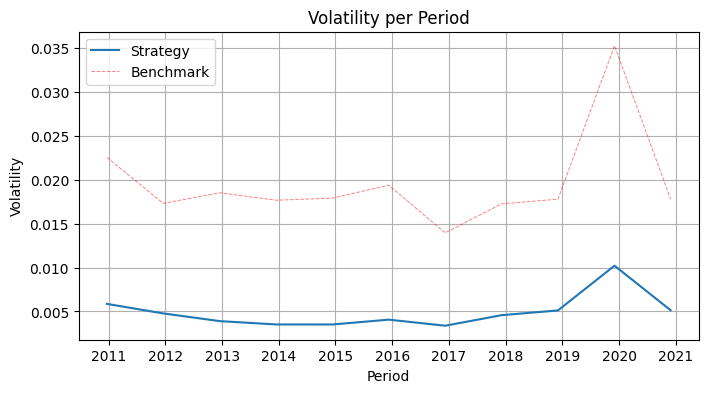

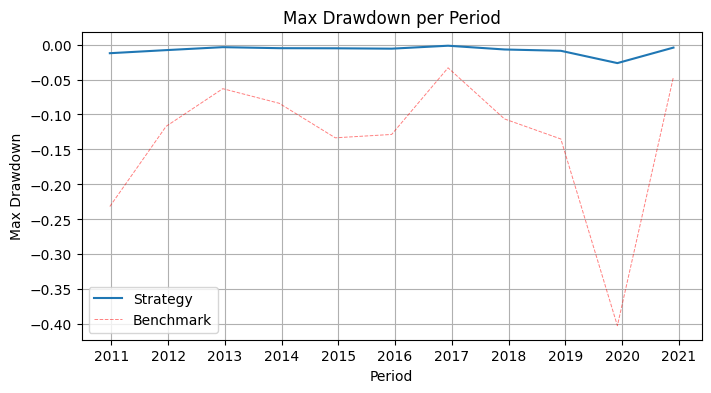

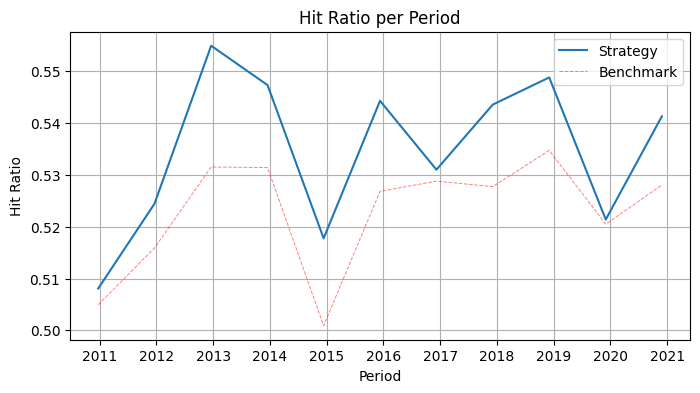

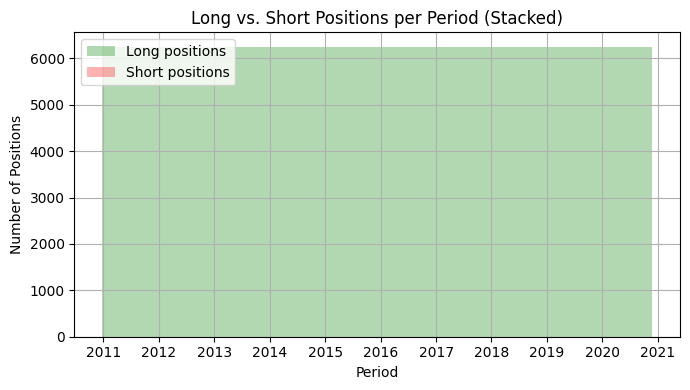

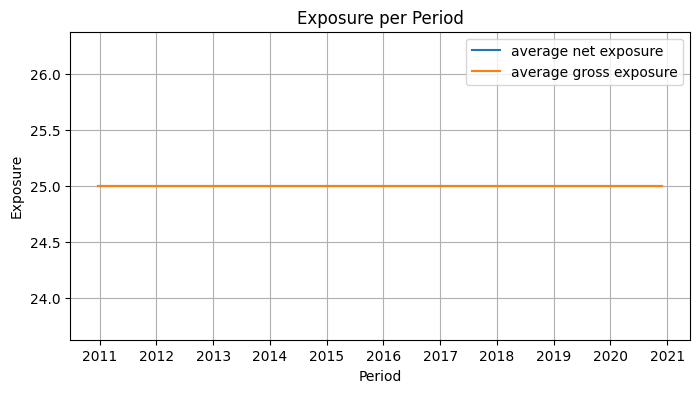

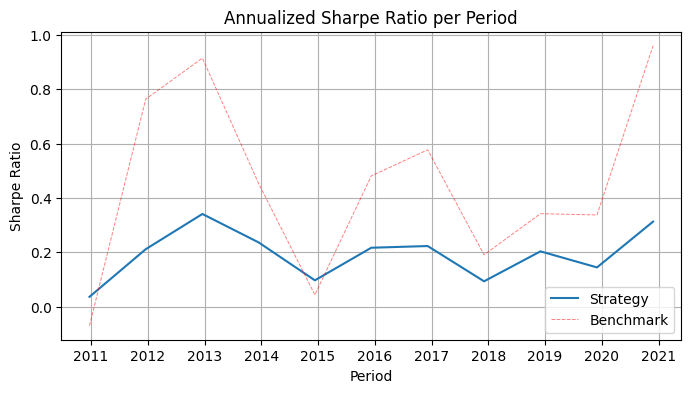

Benchmark  Strategy
overall mean daily return        0.0533%   0.0057%
overall volatility daily         2.0306%   0.5249%
overall annualized return         13.42%     1.43%
overall annualized volatility     32.24%     8.33%
overall max drawdown             -40.20%    -2.65%
overall sharpe ratio            0.416365  0.171075
overall hit ratio                 52.28%    53.48%
overall average net exposure         NaN     25.00
overall average gross exposure       NaN     25.00
overall total positions              NaN     68750
overall long %                       NaN   100.00%

In [ ]:
LSK_abs_LO_strategy_metrics = backtesting(results, LSK_absolute_strategy_performance,
                                           K=25,
                                           leverage=1,
                                           LongOnly=True)
LSK_abs_LO_strategy_metrics

In [ ]:
import numpy as np

def LSK_relative_strategy_performance(trade_predictions_df,leverage = 1, K = 0.10, LongOnly = False):
    """
    Each day, go long the top K*100% of symbols by prediction_proba
    and (unless LongOnly) short the bottom K*100%.
    """
    df = trade_predictions_df.copy()

    # 1) percentile rank within each date (0 < rank_K <= 1)
    df['rank_K'] = (
        df
        .groupby('date')['prediction_proba']
        .rank(method='first', pct=True)
    )

    # 2) build positions
    #    long if rank_K >= 1 - K
    #    short if rank_K <= K (unless LongOnly)
    df['strategy_position'] = np.where(
        df['rank_K'] >= 1 - K,
        1 * leverage,
        0
    )

    if not LongOnly:
        df['strategy_position'] = np.where(
            df['rank_K'] <= K,
            -1 * leverage,
            df['strategy_position']
        )

    # 3) compute returns
    df['strategy_return'] = df['strategy_position'] * df['next_day_return']

    # 4) clean up
    df.drop(columns='rank_K', inplace=True)

    return df



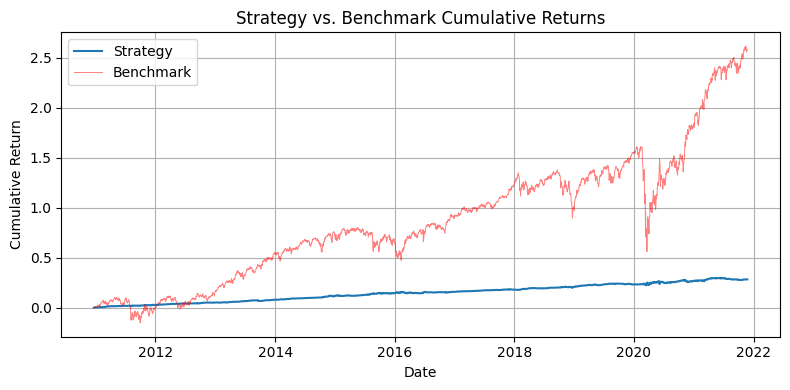

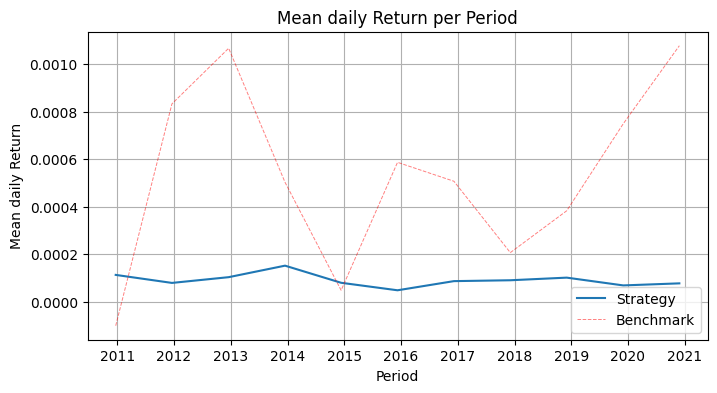

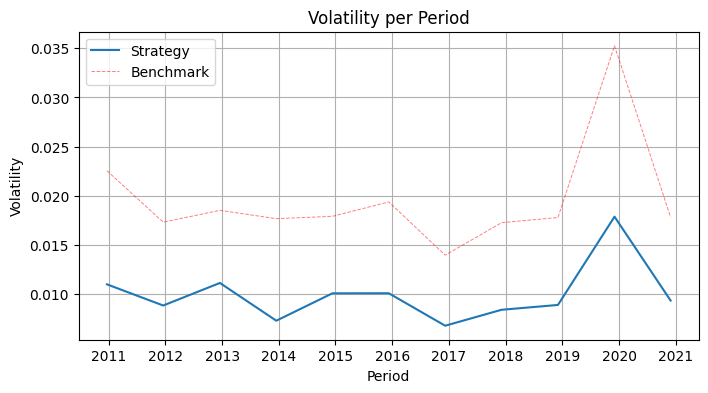

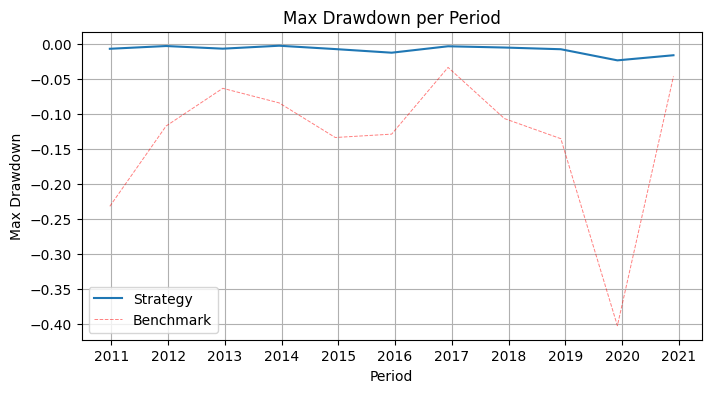

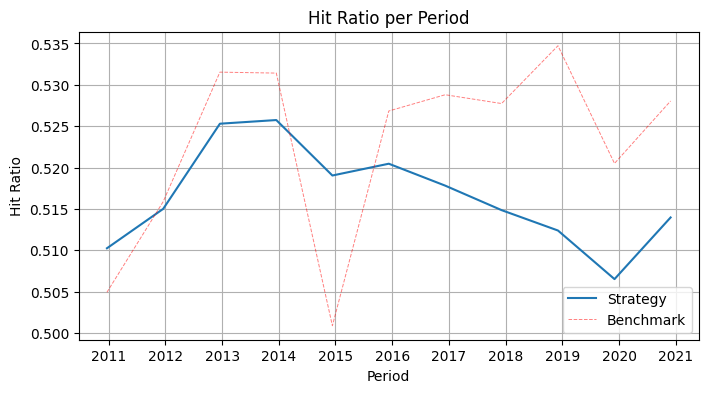

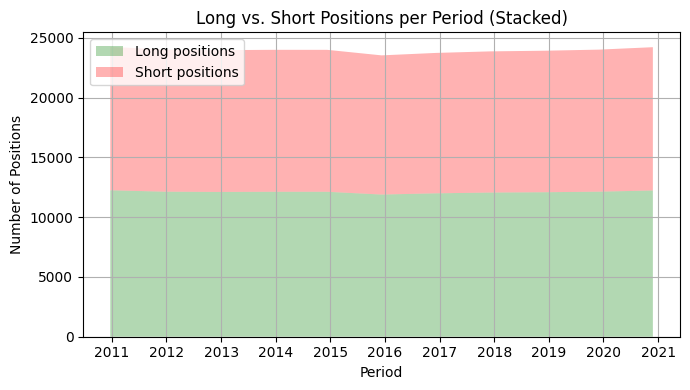

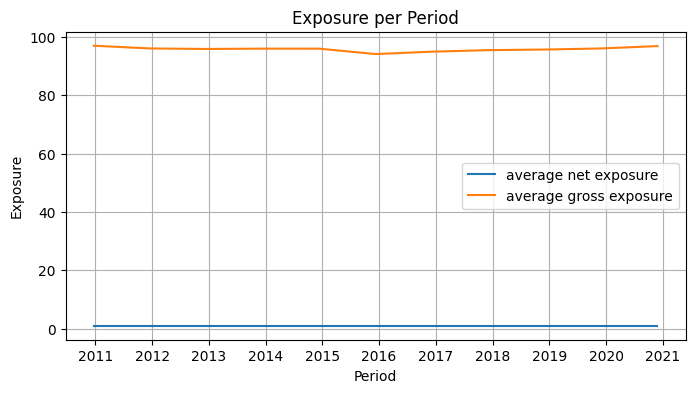

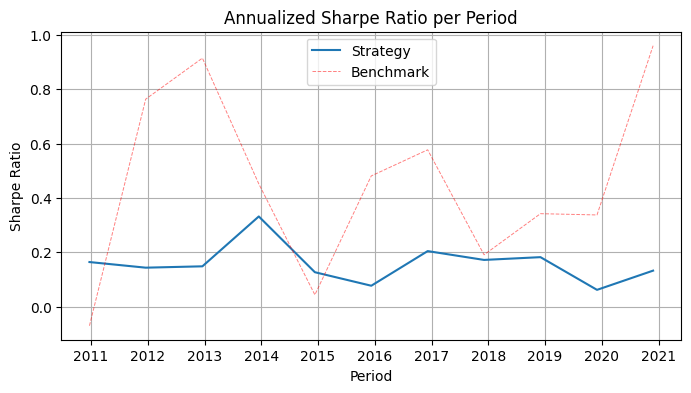

Benchmark  Strategy
overall mean daily return        0.0533%   0.0091%
overall volatility daily         2.0306%   1.0364%
overall annualized return         13.42%     2.30%
overall annualized volatility     32.24%    16.45%
overall max drawdown             -40.20%    -2.32%
overall sharpe ratio            0.416365  0.139809
overall hit ratio                 52.28%    51.65%
overall average net exposure         NaN      1.00
overall average gross exposure       NaN     95.85
overall total positions              NaN    263586
overall long %                       NaN    50.52%

In [ ]:
LSK_rel_strategy_metrics = backtesting(results, LSK_relative_strategy_performance,
                                           K=0.10,
                                           leverage=1,
                                           LongOnly=False)
LSK_rel_strategy_metrics

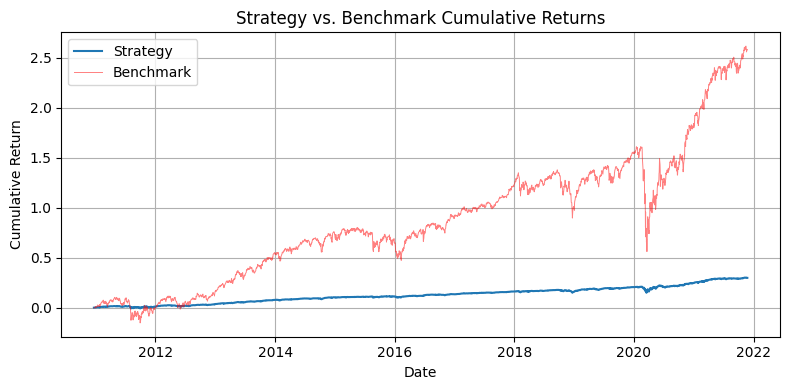

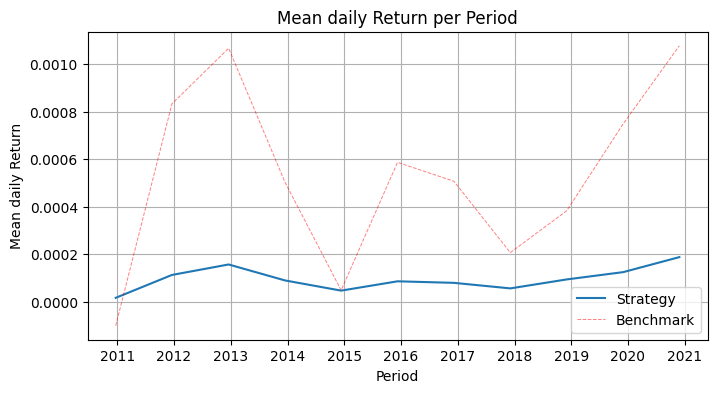

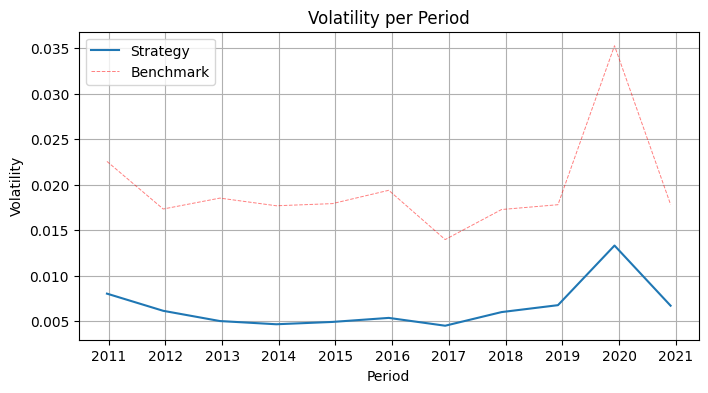

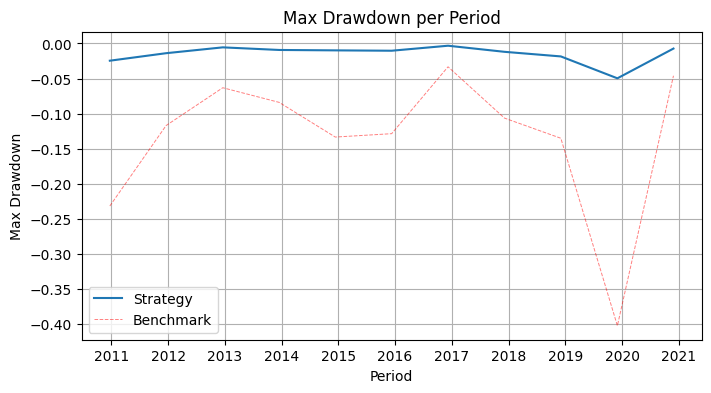

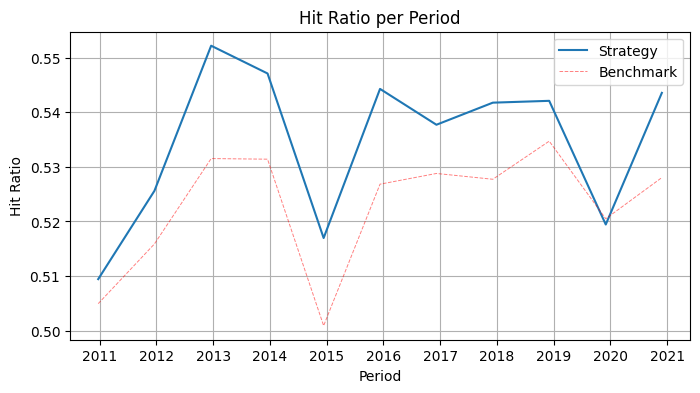

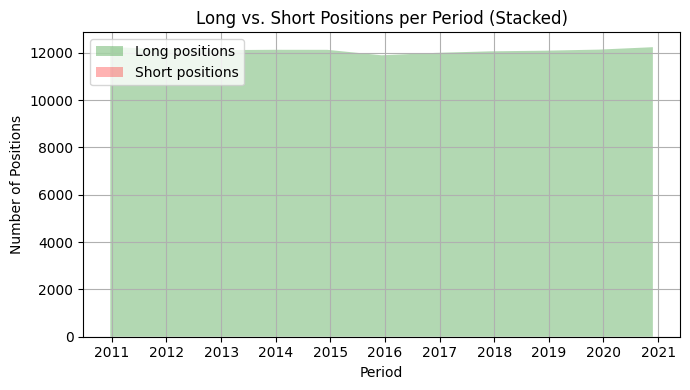

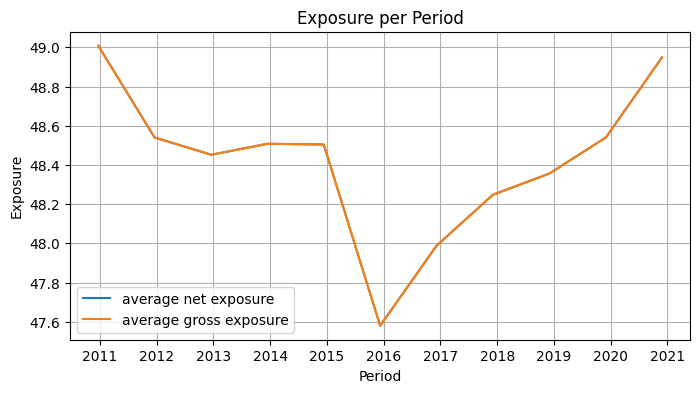

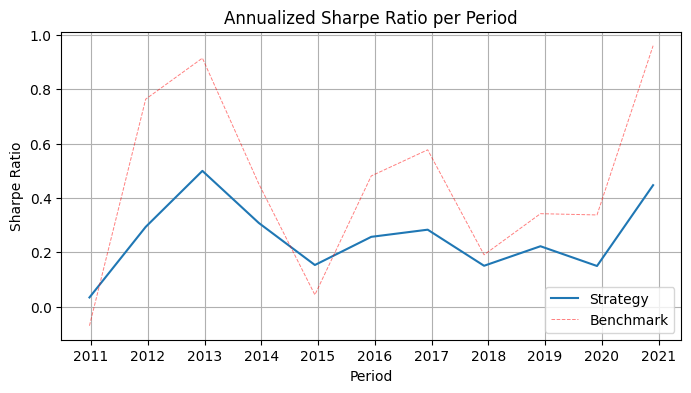

Benchmark  Strategy
overall mean daily return        0.0533%   0.0096%
overall volatility daily         2.0306%   0.6904%
overall annualized return         13.42%     2.41%
overall annualized volatility     32.24%    10.96%
overall max drawdown             -40.20%    -4.97%
overall sharpe ratio            0.416365  0.220317
overall hit ratio                 52.28%    53.45%
overall average net exposure         NaN     48.42
overall average gross exposure       NaN     48.42
overall total positions              NaN    133168
overall long %                       NaN   100.00%

In [ ]:
LSK_rel_LO_strategy_metrics = backtesting(results, LSK_relative_strategy_performance,
                                           K=0.10,
                                           leverage=1,
                                           LongOnly=True)
LSK_rel_LO_strategy_metrics

### 5.3 In-Sample sharpe ratio optimization.

Now that we have defined those strategies and backtested an *naïve* version of them, we can try to find a threshold (value for K) that optimizes the Sharpe ratio.

Why not try to optimize for final cumulative returns ? Because, in theory, with a profitable strategy, one can get any amount of cumulative returns with enough leverage.

Take for example a strategy with a return of 5% and volatility of 10%, if we double the leverage, we get 10% returns and 20% volatility. We doubled the returns but also doubled the risk. What didn't change is the amount of risk we have taken for a given level of returns, which is the Sharpe Ratio.

Our aim is to beat the sharpe ratio of the benchmark because no matter the leverage, the sharpe ratio stays the same.

Unfortunately, this analysis is done after training and is therefore in-sample.

Here are the strategies that we are going to optimize the sharpe ratio for :    

- Binary Classification
- Binary Classification Long Only
- Linear Transformation
- Linear Transformation Long Only
- Sinusoïdal Transformation
- Sinusoïdal Transformation Long Only
- Logistic Transformation
- Logistic Transformation Long Only
- Hyperbolic Transformation
- Hyperbolic Transformation Long Only
- Long/Short K with absolute K
- Long K with absolute K
- Long/Short K with relative K
- Long K with relative K

We create a dictionary holding all of the necessary information for the optimization.

In [ ]:
num = 200

K_values_linspace = np.linspace(0.000,0.499, num = num).tolist()
K_values_convolutions = np.linspace(0.001, 1000.000, num = num).tolist()
K_values_absolute = np.int64(np.linspace(1, 250, num = num)).tolist()
K_values_absolute_LO = np.int64(np.linspace(1, 475, num = num)).tolist()
K_values_relative_LO = np.linspace(0.001, 0.995, num = num).tolist()

def benchmark_performance(trade_predictions_df, leverage=1, convolution=None, K=None, LongOnly = False):
    df = trade_predictions_df.copy()
    df['strategy_position'] = 1 * leverage
    df['strategy_return'] = df['strategy_position'] * df['next_day_return']
    return df

strategies = [
    {
    'Name': 'Benchmark',
    'function': benchmark_performance,
    'Convolution' : None,
    'LongOnly': True,
    'K_values' : [None],
    },
    {
    'Name': 'Binary Classification',
    'function': binary_strategy_performance,
    'Convolution' : None,
    'LongOnly': False,
    'K_values' : K_values_linspace,
    },
    {
    'Name': 'Binary Classification Long Only',
    'function': binary_strategy_performance,
    'Convolution' : None,
    'LongOnly': True,
    'K_values' : K_values_linspace,
    },
    {
    'Name': 'Linear Transformation',
    'function': convolution_strategy_performance,
    'Convolution' : linear_mapping,
    'LongOnly': False,
    'K_values' : [None],
    },
    {
    'Name': 'Linear Transformation Long Only',
    'function': convolution_strategy_performance,
    'Convolution' : linear_mapping,
    'LongOnly': True,
    'K_values' : [None],
    },
    {
    'Name': 'Sinusoïdal Transformation',
    'function': convolution_strategy_performance,
    'Convolution' : sinusoidal_mapping,
    'LongOnly': False,
    'K_values' : [None],
    },
    {
    'Name': 'Sinusoïdal Transformation Long Only',
    'function': convolution_strategy_performance,
    'Convolution' : sinusoidal_mapping,
    'LongOnly': True,
    'K_values' : [None],
    },
    {
    'Name': 'Logistic Transformation',
    'function': convolution_strategy_performance,
    'Convolution' : logistic_mapping,
    'LongOnly': False,
    'K_values' : K_values_convolutions,
    },
    {
    'Name': 'Logistic Transformation Long Only',
    'function': convolution_strategy_performance,
    'Convolution' : logistic_mapping,
    'LongOnly': True,
    'K_values' : K_values_convolutions,
    },
    {
    'Name': 'Hyperbolic Transformation',
    'function': convolution_strategy_performance,
    'Convolution' : hyperbolic_mapping,
    'LongOnly': False,
    'K_values' : K_values_convolutions,
    },
    {
    'Name': 'Hyperbolic Transformation Long Only',
    'function': convolution_strategy_performance,
    'Convolution' : hyperbolic_mapping,
    'LongOnly': True,
    'K_values' : K_values_convolutions,
    },
    {
    'Name': 'Long Short K with absolute K',
    'function': LSK_absolute_strategy_performance,
    'Convolution' : None,
    'LongOnly': False,
    'K_values' : K_values_absolute,
    },
    {
    'Name': 'Long K with absolute K',
    'function': LSK_absolute_strategy_performance,
    'Convolution' : None,
    'LongOnly': True,
    'K_values' : K_values_absolute_LO,
    },
    {
    'Name': 'Long Short K with relative K',
    'function': LSK_relative_strategy_performance,
    'Convolution' : None,
    'LongOnly': False,
    'K_values' : K_values_linspace,
    },
    {
    'Name': 'Long K with relative K',
    'function': LSK_relative_strategy_performance,
    'Convolution' : None,
    'LongOnly': True,
    'K_values' : K_values_relative_LO,
    }
]

In [ ]:
#Inititialize parameters and lists :
optimization_results = []
trading_days = 252

#Accumulate all trade predictions in a single dataframe
all_trade_predictions_df = pd.concat(
  [period['trade_predictions'] for period in results],
  ignore_index=True)

#Get period dates from results
period_dates = [period['test_range'] for period in results]

for strategy in strategies:
    name       = strategy['Name']
    func       = strategy['function']
    conv       = strategy['Convolution']
    long_only  = strategy['LongOnly']
    K_values   = strategy['K_values']

    print(f'-- Processing {name}')

    for K in K_values:
        # call with or without convolution arg
        if conv is None:
            strategy_df = func(
                all_trade_predictions_df,
                leverage=1,
                LongOnly=long_only,
                K = K)

        if conv is not None:
            strategy_df = func(
                all_trade_predictions_df,
                leverage=1,
                convolution=conv,
                LongOnly=long_only,
                K = K)

        #Overall metrics :
        overall_mean_daily_return = strategy_df['strategy_return'].mean()
        overall_volatility_daily = strategy_df['strategy_return'].std()
        overall_annualized_return = overall_mean_daily_return * trading_days
        overall_annualized_volatility = overall_volatility_daily * np.sqrt(trading_days)
        overall_annualized_sharpe_ratio = np.sqrt(trading_days) * (overall_mean_daily_return / overall_volatility_daily) if overall_volatility_daily != 0 else 0

        #Append overall results to list of dicts :
        optimization_results.append({
                'Name': name,
                'Period': 'Overall',
                'Convolution': conv,
                'K': K,
                'Annualized return': overall_annualized_return,
                'Annualized Vol': overall_annualized_volatility,
                'Annualized Sharpe': overall_annualized_sharpe_ratio
                })

        #Per period metrics :
        for period_idx, (start_date, end_date) in enumerate(period_dates, start=1):

            #Truncate dataframe to period dataframe
            strategy_df_period = strategy_df[(strategy_df['date'] >= start_date) & (strategy_df['date'] <= end_date)]

            #Compute per period metrics
            mean_daily_return = strategy_df_period['strategy_return'].mean()
            volatility_daily = strategy_df_period['strategy_return'].std()
            annualized_return = mean_daily_return * trading_days
            annualized_volatility = volatility_daily * np.sqrt(trading_days)
            annualized_sharpe_ratio = np.sqrt(trading_days) * (mean_daily_return / volatility_daily) if volatility_daily != 0 else 0

            #Append per period results to list of dicts
            optimization_results.append({
                'Name': name,
                'Period': period_idx,
                'Convolution': conv.__name__ if conv is not None else None,
                'K': K,
                'Annualized return': annualized_return,
                'Annualized Vol': annualized_volatility,
                'Annualized Sharpe': annualized_sharpe_ratio
                })

optimization_results_df = pd.DataFrame(optimization_results)

-- Processing Benchmark
-- Processing Binary Classification
-- Processing Binary Classification Long Only
-- Processing Linear Transformation
-- Processing Linear Transformation Long Only
-- Processing Sinusoïdal Transformation
-- Processing Sinusoïdal Transformation Long Only
-- Processing Logistic Transformation
-- Processing Logistic Transformation Long Only
-- Processing Hyperbolic Transformation
-- Processing Hyperbolic Transformation Long Only
-- Processing Long Short K with absolute K
-- Processing Long K with absolute K
-- Processing Long Short K with relative K
-- Processing Long K with relative K


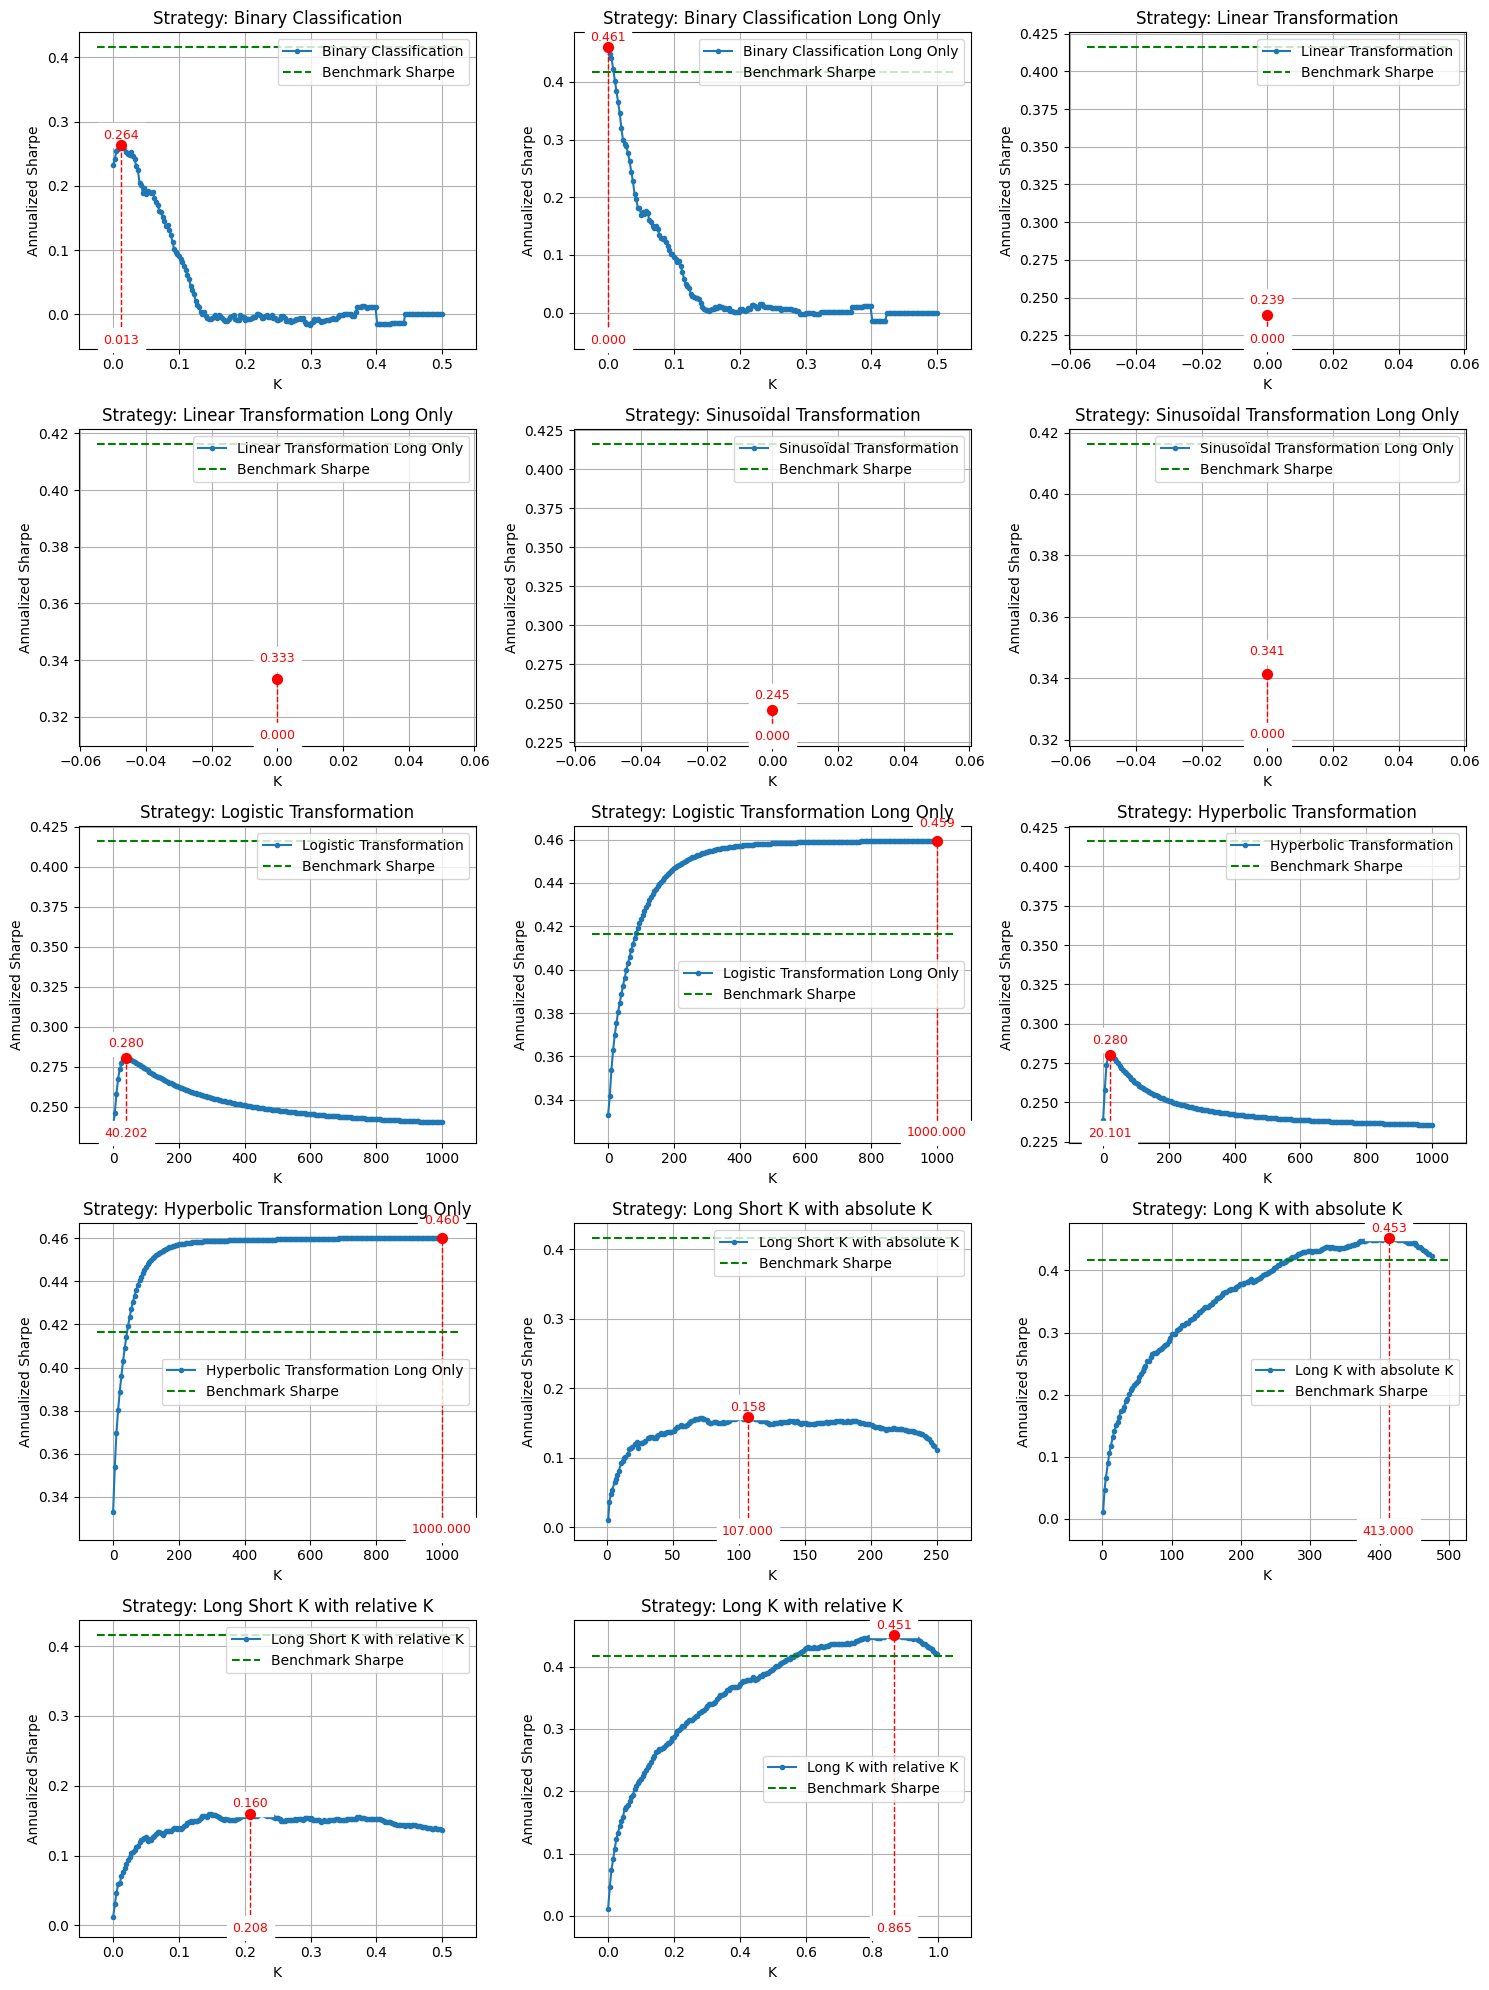

In [ ]:
# Filter overall results and benchmark Sharpe
overall_results = optimization_results_df[
    optimization_results_df['Period'] == 'Overall'
].fillna(0)

overall_benchmark = overall_results[overall_results['Name'] == 'Benchmark'].iloc[0]
overall_benchmark_sharpe = overall_benchmark['Annualized Sharpe']

# Filter strategies with results (excluding Benchmark)
plot_strategies = [
    s for s in strategies
    if not overall_results[overall_results['Name'] == s['Name']].empty and s['Name'] != 'Benchmark'
]

n_plots = len(plot_strategies)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
axs = axs.flatten()

for i, strategy in enumerate(plot_strategies):
    strat_name = strategy['Name']
    strat_df   = overall_results[overall_results['Name'] == strat_name]

    ax = axs[i]
    ax.plot(
        strat_df['K'],
        strat_df['Annualized Sharpe'],
        'o-',
        label=strat_name,
        markersize=3,
        linewidth=1.5
    )

    idx_max = strat_df['Annualized Sharpe'].idxmax()
    max_k   = strat_df.loc[idx_max, 'K']
    max_sr  = strat_df.loc[idx_max, 'Annualized Sharpe']

    # Highlight max point
    ax.scatter([max_k], [max_sr], color='red', s=50, zorder=5)

    # Vertical line
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    ax.vlines(x=max_k, ymin=y_min, ymax=max_sr, colors='red', linestyles='--', linewidth=1)

    # Horizontal benchmark line
    ax.hlines(y=overall_benchmark_sharpe, xmin=x_min, xmax=x_max,
              linestyles='--', colors='green', label='Benchmark Sharpe')

    # Annotations
    ax.text(max_k, max_sr + 0.005, f"{max_sr:.3f}", color='red',
            ha='center', va='bottom', fontsize=9, backgroundcolor='white')

    ax.text(max_k, y_min + 0.001, f"{max_k:.3f}", color='red',
            ha='center', va='top', fontsize=9, backgroundcolor='white')

    ax.set_title(f"Strategy: {strat_name}")
    ax.set_xlabel('K')
    ax.set_ylabel('Annualized Sharpe')
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
# idxmax + loc
idx = overall_results.groupby('Name')['Annualized Sharpe'].idxmax()
best_per_name = overall_results.loc[idx].reset_index(drop=True)
best_per_name.sort_values('Annualized Sharpe', ascending=False, inplace=True)
best_per_name.drop(columns=['Period', 'Convolution'], inplace=True)

# now display
best_per_name

Name            K  Annualized return  \
2       Binary Classification Long Only     0.000000           0.104491   
4   Hyperbolic Transformation Long Only  1000.000000           0.102971   
8     Logistic Transformation Long Only  1000.000000           0.101291   
9                Long K with absolute K   413.000000           0.131828   
10               Long K with relative K     0.865131           0.131712   
0                             Benchmark     0.000000           0.134216   
14  Sinusoïdal Transformation Long Only     0.000000           0.009113   
6       Linear Transformation Long Only     0.000000           0.005844   
3             Hyperbolic Transformation    20.101482           0.046605   
7               Logistic Transformation    40.201965           0.046604   
1                 Binary Classification     0.012538           0.068857   
13            Sinusoïdal Transformation     0.000000           0.010503   
5                 Linear Transformation     0.000000           0.006736   
12         Long Short K with relative K     0.208126           0.035136   
11         Long Short K with absolute K   107.000000           0.035731   

    Annualized Vol  Annualized Sharpe  
2         0.226677           0.460968  
4         0.223719           0.460270  
8         0.220457           0.459460  
9         0.291161           0.452767  
10        0.292043           0.451004  
0         0.322351           0.416365  
14        0.026686           0.341479  
6         0.017540           0.333150  
3         0.166194           0.280424  
7         0.166191           0.280424  
1         0.260933           0.263887  
13        0.042785           0.245473  
5         0.028214           0.238736  
12        0.219468           0.160095  
11        0.225666           0.158337

Check Persistence across periods

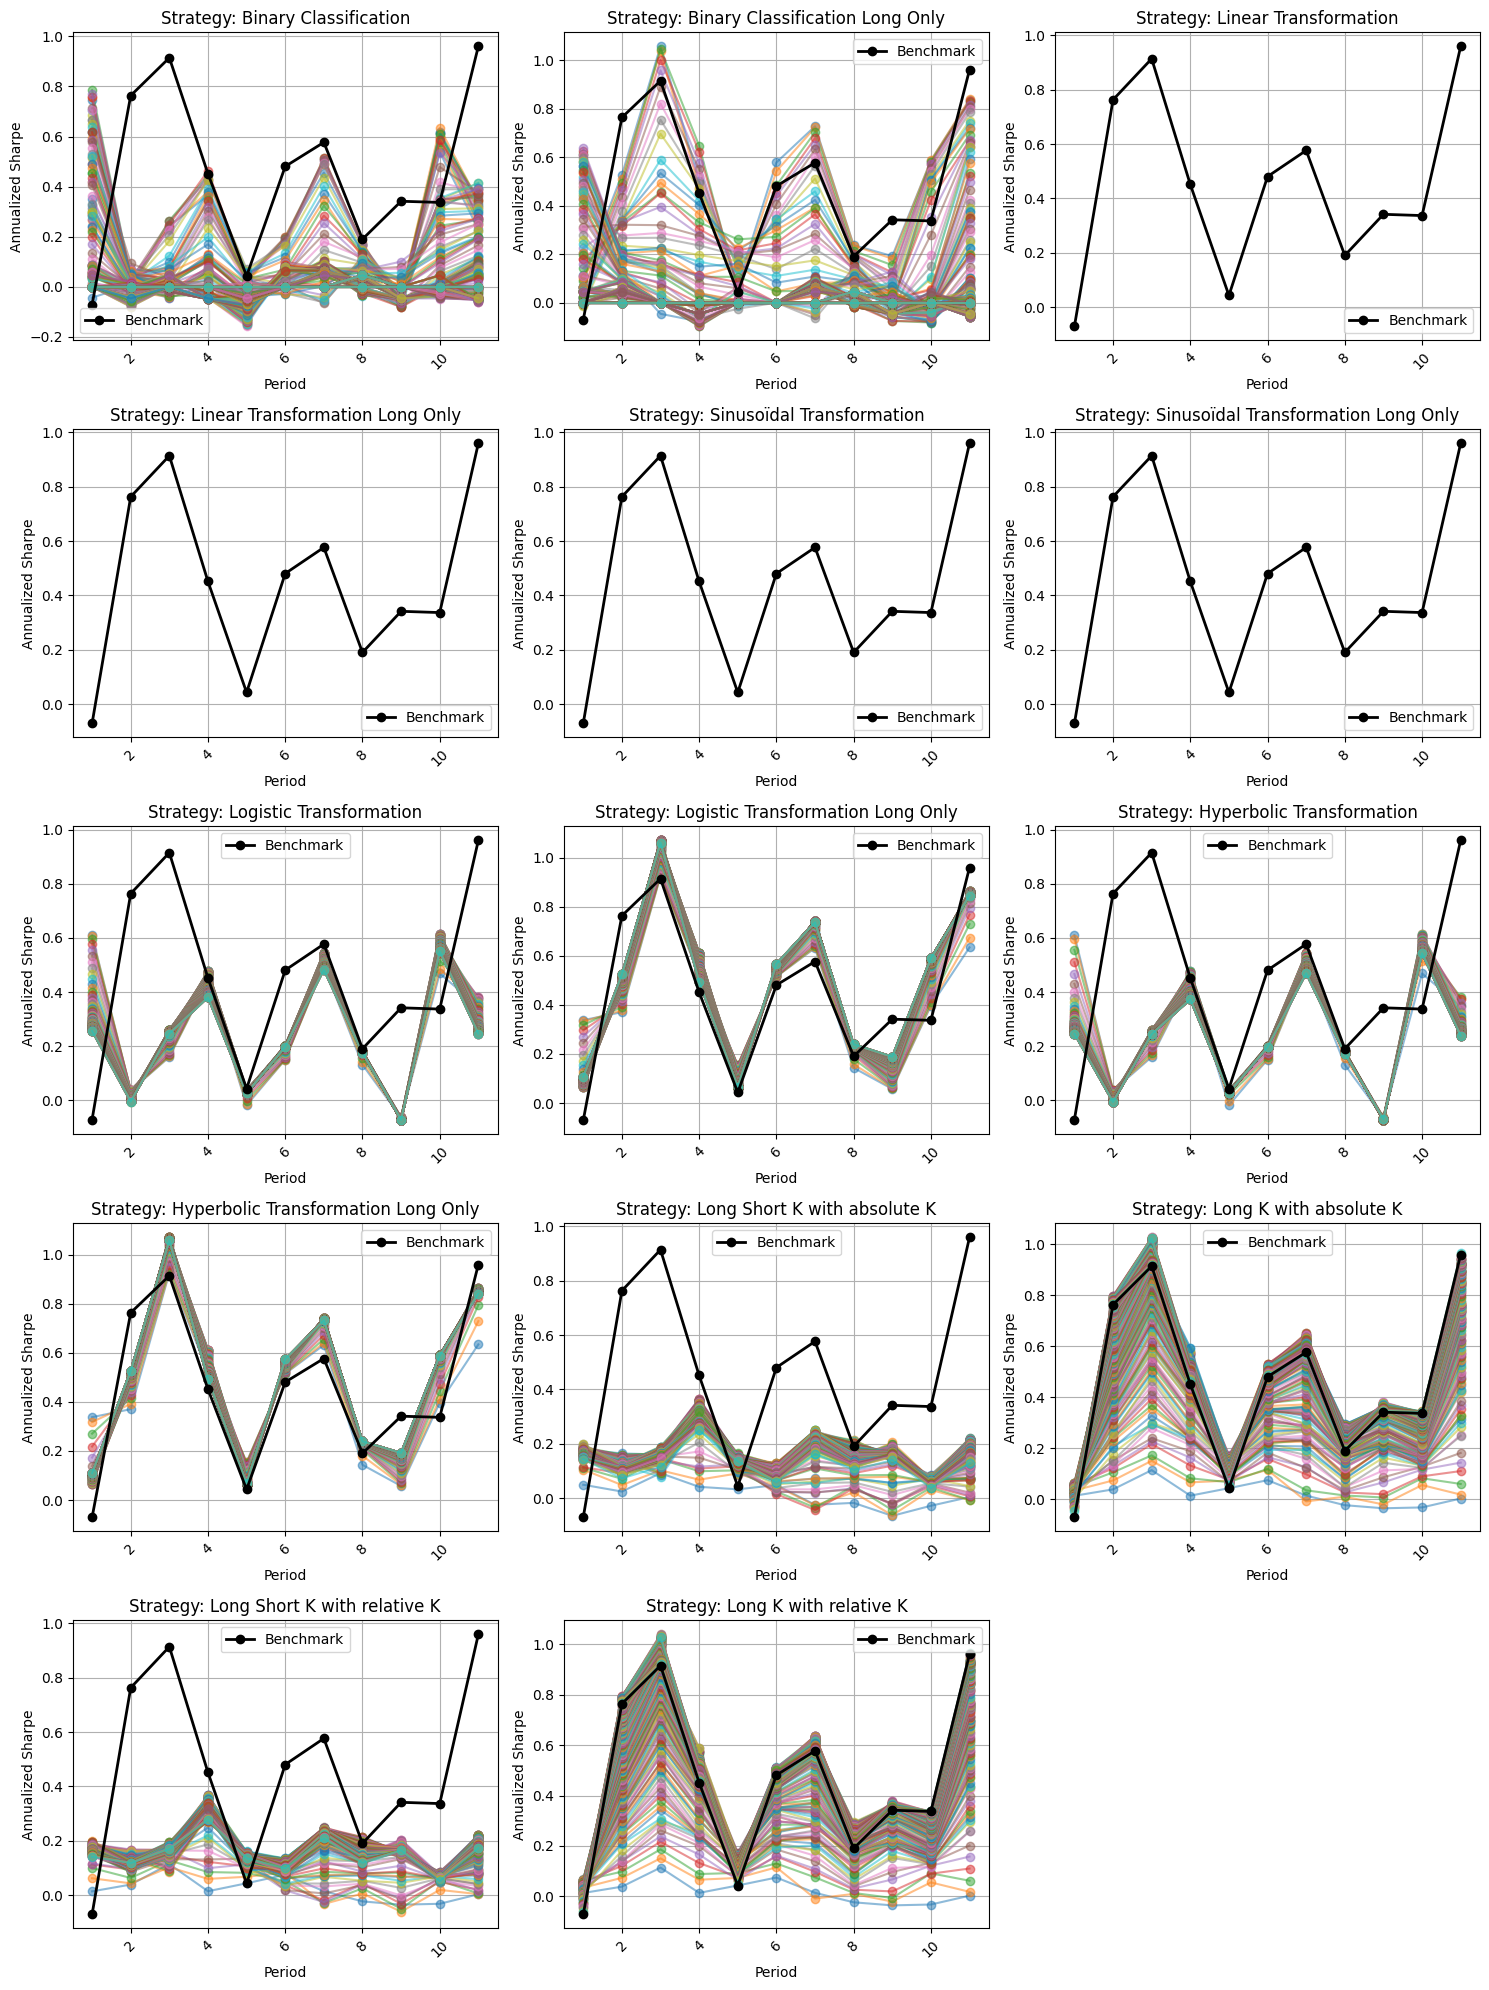

In [ ]:
# Preprocess data
per_period_optimization_results_df = optimization_results_df[optimization_results_df['Period']!='Overall'].copy()
per_period_optimization_results_df.sort_values(['Name', 'Period'], inplace=True)

strat_not_bench = [s for s in strategies if s['Name'] != 'Benchmark']

benchmark_results_df = per_period_optimization_results_df[per_period_optimization_results_df['Name'] == 'Benchmark']

per = per_period_optimization_results_df.copy()
per[['Annualized return','Annualized Vol','Annualized Sharpe']] = (
    per[['Annualized return','Annualized Vol','Annualized Sharpe']]
     .fillna(0)
)

# Filter strategies with data
plot_strategies = [s for s in strat_not_bench if not per[per['Name'] == s['Name']].empty]
n_plots = len(plot_strategies)
n_cols = 3  # layout configuration
n_rows = math.ceil(n_plots / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
axs = axs.flatten()

for i, strategy in enumerate(plot_strategies):
    name = strategy['Name']
    strat_df = per[per['Name'] == name]
    ax = axs[i]

    present_Ks = sorted(strat_df['K'].dropna().unique())
    for k in present_Ks:
        df_k = strat_df[strat_df['K'] == k]
        ax.plot(
            df_k['Period'],
            df_k['Annualized Sharpe'],
            'o-',
            alpha=0.5,
        )

    # Benchmark plot
    ax.plot(
        benchmark_results_df['Period'],
        benchmark_results_df['Annualized Sharpe'],
        'o-',
        color='black',
        linewidth=2,
        label='Benchmark'
    )

    ax.set_title(f"Strategy: {name}")
    ax.set_xlabel('Period')
    ax.set_ylabel('Annualized Sharpe')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='best')
    ax.grid(True)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
